# Inizio

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

#i grafici verranno visualizzati direttamente sotto le loro celle, inoltre è attivo l'autoreload del kernel

In [2]:
import sys
sys.path.append("C:\\Users\\celin\\AppData\\Local\\Programs\\Python\\Python312")
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\flu_2023")
sys.path.append("C:\\Users\\celin\\OneDrive\\Desktop\\polito\\drive-download-20241207T142618Z-001\\codice tesi\\flu_2023")

sys.path.append("./")
#queste istruzioni servono a dire a Python in quali percorsi bisogna cercare i moduli

In [3]:
#importiamo i moduli che ci servono
import pandas as pd #si usa per manipolare e analizzare dati: file excel, csv ecc.
import numpy as np #funzioni, array multidimensionali, calcoli complessi
from numpy import ones
import scipy as spy #si usa assieme a numpy: calcola integrali, minimizza e massimizza funzionali, trasformate fourier ecc
import os #permette di manipolare file
import copy
import pickle
import itertools
import datetime #fornisce classi e funzioni per manipolare date e orari
import matplotlib #si usa per creare grafici


from glob import glob #glob lo usiamo per dire a python che file ci serve, dando come input il percorso

import seaborn as sns #seaborn aggiunge opzioni grafiche a matplotlib
blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

import matplotlib.patches as mpatches #oggetti geometrici (patches) per i grafici
from collections import Counter, defaultdict #fornisce delle classi utili a manipolare dati aggregati
from itertools import combinations

from tqdm import tqdm_notebook #taqaddum, fornisce barra di avanzamento per i cicli for

import collections, functools, operator 
from bidict import bidict
from sklearn.decomposition import NMF
from matplotlib.colors import LogNorm

from multiprocessing import Pool

# LETTURA DATI INFLUCAST

In [7]:
'''
Lettura dati reali CON approssimazione nazionale per le province mancanti
'''
w = 1
y = 5
import os
import pandas as pd


folder_path = "C:\\Users\\celin\\OneDrive\\Desktop\\polito\\drive-download-20241207T142618Z-001\\codice tesi\\dati_reali_24-25\\202{}_{:02}".format(y, int(w))
print(folder_path)


weekly_cases_by_region = {}
latest_files = {}

# Raccogli i file più recenti per ogni regione
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        base_name = file_name[:-4]
        region_name, year_week, target = base_name.split('-')
        year, week = map(int, year_week.split('_'))
        
        if region_name not in latest_files or (year, week) > (latest_files[region_name]['year'], latest_files[region_name]['week']):
            latest_files[region_name] = {'file_name': file_name, 'year_week': year_week, 'year': year, 'week': week}

# Leggi i file regionali e raccogli i dati settimanali
for region_name, file_info in latest_files.items():
    file_name = file_info['file_name']
    file_path = os.path.join(folder_path, file_name)
    print(f"Elaborazione del file per la regione: {region_name}, settimana: {file_info['week']} del {file_info['year']}")
    
    df = pd.read_csv(file_path)
    
    if region_name not in weekly_cases_by_region:
        weekly_cases_by_region[region_name] = {}
    
    for _, row in df.iterrows():
        week = f"{int(row['anno'])}_W{int(row['settimana']):02d}"
        cases = row['incidenza']
        weekly_cases_by_region[region_name][week] = cases

# Debug: Stampa il dizionario settimanale dei casi
print("Dati settimanali iniziali per regione:", weekly_cases_by_region)


week_of_interest = "202{}_W{:02}".format(y, int(w))

# carichiamo l'incidenza reale per ogni regione
national_file = os.path.join(folder_path, "italia-202{}_{:02}-ILI.csv".format(y, int(w)))
national_df = pd.read_csv(national_file)
incidenza_nazionale = national_df['incidenza'].iloc[-1]  # Ultima settimana

for region_name, weeks_data in weekly_cases_by_region.items():
    # se influcast non ci ha inviato dati per quella regione
    if not weeks_data:
        print(f"Attenzione: Nessun dato disponibile per {region_name}. Verrà usata l'incidenza nazionale.")
        weekly_cases_by_region[region_name] = {week_of_interest: incidenza_nazionale}
        continue

    # se per quella settimana non ci sono dati
    if week_of_interest not in weeks_data:
        print(f"Attenzione: Nessun dato per la settimana {week_of_interest} in {region_name}. Verrà usata l'incidenza nazionale.")
        weekly_cases_by_region[region_name][week_of_interest] = incidenza_nazionale

# Debug: Verifica il dizionario dopo l'aggiornamento
print("Dati settimanali aggiornati per regione:", weekly_cases_by_region)

# Normalizzazione dei nomi delle regioni
def normalize_region_name(region_name):
    normalized_name = region_name.lower().replace("_", " ").strip()
    return normalized_name

region_name_mapping = {
    "provincia autonoma di bolzano": "P.A. Bolzano",
    "provincia autonoma di trento": "P.A. Trento",
    "valle d'aosta": "valle d aosta",
    "emilia-romagna": "emilia romagna",
    "italia": "Italia",
    "pa trento": "trentino"
}

pop_df = pd.read_csv("popREG2.csv")
pop_df['Regione'] = pop_df['Regione'].apply(normalize_region_name)
pop_df['Regione'] = pop_df['Regione'].replace(region_name_mapping)
pop_dict = pop_df.set_index('Regione')['PopolazioneRegionale'].to_dict()

normalized_weekly_cases_by_region = {
    normalize_region_name(region_name): weeks_data 
    for region_name, weeks_data in weekly_cases_by_region.items()
}
normalized_weekly_cases_by_region = {
    region_name_mapping.get(region_name, region_name): weeks_data 
    for region_name, weeks_data in normalized_weekly_cases_by_region.items()
}

# Calcola i casi totali provinciali
for region_name, weeks_data in normalized_weekly_cases_by_region.items():
    if region_name not in pop_dict:
        continue
    
    population_region = pop_dict[region_name]
    for week, incidence_per_1000 in weeks_data.items():
        estimated_cases = incidence_per_1000 * population_region / 1000
        normalized_weekly_cases_by_region[region_name][week] = estimated_cases

# Distribuzione provinciale dei casi
final_df = pd.DataFrame()
for region_name, weekly_cases in normalized_weekly_cases_by_region.items():
    region_df = pop_df[pop_df['Regione'].str.strip().str.lower() == region_name.strip().lower()]
    if region_df.empty:
        continue
    
    for week, total_cases in weekly_cases.items():
        region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
        region_df['Settimana'] = week
        final_df = pd.concat([final_df, region_df[['Territorio', 'Settimana', 'CasiDistribuiti']]], ignore_index=True)

# Salva il file finale
final_df.to_csv('casi_distribuiti_province.csv', index=False)

import pandas as pd
import numpy as np

risultati = pd.read_csv('risultati1.csv')
dati_reali = pd.read_csv('casi_distribuiti_province.csv')

risultati['Settimana'] = pd.to_datetime(risultati['Date']).dt.isocalendar().week
risultati['Anno'] = pd.to_datetime(risultati['Date']).dt.year
risultati['Settimana_Anno'] = risultati['Anno'].astype(str) + '_W' + risultati['Settimana'].astype(str)

dati_reali['Anno'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[0]))
dati_reali['Settimana_Numero'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[1]))

def espandi_settimana_a_giorni(df):
    expanded_rows = []
    for _, row in df.iterrows():
        inizio_settimana = pd.to_datetime(f'{row["Anno"]}-W{int(row["Settimana_Numero"])}-1', format='%Y-W%W-%w')
        for i in range(7):
            giorno = inizio_settimana + pd.Timedelta(days=i)
            expanded_rows.append({
                'Territorio': row['Territorio'],
                'Data': giorno,
                'Settimana_Numero': row['Settimana_Numero'],
                'CasiDistribuiti': row['CasiDistribuiti']  # non distribuiamo qui
            })
    return pd.DataFrame(expanded_rows)

dati_reali_giornalieri = espandi_settimana_a_giorni(dati_reali)

def normalize_province_name(province_name):
    return province_name.strip().lower().replace("'", "").replace(" ", "").replace("-", "")

risultati['Provincia_Normalizzata'] = risultati['Province'].apply(normalize_province_name)
dati_reali_giornalieri['Provincia_Normalizzata'] = dati_reali_giornalieri['Territorio'].apply(normalize_province_name)

dati_reali_giornalieri = dati_reali_giornalieri.sort_values(['Provincia_Normalizzata', 'Data'])
dati_reali_giornalieri['CasiDistribuiti'] = dati_reali_giornalieri.groupby('Provincia_Normalizzata')['CasiDistribuiti'].transform(lambda x: x.interpolate(method='linear'))

risultati['Date'] = pd.to_datetime(risultati['Date'])
dati_reali_giornalieri['Data'] = pd.to_datetime(dati_reali_giornalieri['Data'])

confronto = pd.merge(risultati, dati_reali_giornalieri, left_on=['Provincia_Normalizzata', 'Date'], right_on=['Provincia_Normalizzata', 'Data'], how='inner')

confronto.to_csv('confronto_risultati_reali_simulati_giornaliero.csv', index=False)

confronto.head()

C:\Users\celin\OneDrive\Desktop\polito\drive-download-20241207T142618Z-001\codice tesi\dati_reali_24-25\2025_01
Elaborazione del file per la regione: abruzzo, settimana: 1 del 2025
Elaborazione del file per la regione: basilicata, settimana: 1 del 2025
Elaborazione del file per la regione: calabria, settimana: 51 del 2024
Elaborazione del file per la regione: campania, settimana: 1 del 2025
Elaborazione del file per la regione: emilia_romagna, settimana: 1 del 2025
Elaborazione del file per la regione: friuli_venezia_giulia, settimana: 1 del 2025
Elaborazione del file per la regione: italia, settimana: 1 del 2025
Elaborazione del file per la regione: lazio, settimana: 1 del 2025
Elaborazione del file per la regione: liguria, settimana: 1 del 2025
Elaborazione del file per la regione: lombardia, settimana: 1 del 2025
Elaborazione del file per la regione: marche, settimana: 1 del 2025
Elaborazione del file per la regione: molise, settimana: 1 del 2025
Elaborazione del file per la regione

C:\Users\celin\AppData\Local\Temp\ipykernel_10376\2277820780.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
C:\Users\celin\AppData\Local\Temp\ipykernel_10376\2277820780.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['Settimana'] = week
C:\Users\celin\AppData\Local\Temp\ipykernel_10376\2277820780.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Date              Province  Suscettibili       Esposti       Infetti  \
0 2024-12-25                torino  2.135557e+06  11450.483191  10734.827992   
1 2024-12-25              vercelli  1.680891e+05    901.264484    844.935453   
2 2024-12-25                biella  1.731267e+05    928.275468    870.258252   
3 2024-12-25  verbano-cusio-ossola  1.523850e+05    817.061873    765.995506   
4 2024-12-25                novara  3.477290e+05   1864.462318   1747.933423   

   Non Contagiosi       Rimossi  Morti  Settimana  Anno Settimana_Anno  \
0    29752.257892  55887.725150    0.0         52  2024       2024_W52   
1     2341.792278   4398.907941    0.0         52  2024       2024_W52   
2     2411.976028   4530.743650    0.0         52  2024       2024_W52   
3     2123.005210   3987.930336    0.0         52  2024       2024_W52   
4     4844.508539   9100.101337    0.0         52  2024       2024_W52   

  Provincia_Normalizzata            Territorio       Data  Settimana_Numero  \
0                 torino                Torino 2024-12-25                52   
1               vercelli              Vercelli 2024-12-25                52   
2                 biella                Biella 2024-12-25                52   
3     verbanocusioossola  Verbano-Cusio-Ossola 2024-12-25                52   
4                 novara                Novara 2024-12-25                52   

   CasiDistribuiti  
0     17817.203221  
1      1402.387322  
2      1444.417008  
3      1271.366212  
4      2901.144297

In [ ]:
'''
Lettura dati reali SENZA approssimazione nazionale per le province mancanti


import os
import pandas as pd


folder_path = 'C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\2024_46'


weekly_cases_by_region = {}


latest_files = {}


for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Rimuovi l'estensione .csv
        base_name = file_name[:-4]
        
        # Estrai il nome della regione e anno-settimana dal nome del file
        region_name, year_week, target = base_name.split('-')
        year, week = map(int, year_week.split('_'))
        
        # Se non abbiamo ancora visto questo anno per la regione, o se questo file ha una settimana più alta, sostituiscilo
        if region_name not in latest_files or (year, week) > (latest_files[region_name]['year'], latest_files[region_name]['week']):
            latest_files[region_name] = {'file_name': file_name, 'year_week': year_week, 'year': year, 'week': week}

# only reads last week data
for region_name, file_info in latest_files.items():
    file_name = file_info['file_name']
    file_path = os.path.join(folder_path, file_name)
    print(f"Elaborazione del file per la regione: {region_name}, settimana: {file_info['week']} del {file_info['year']}")
    
    df = pd.read_csv(file_path)
    
    
    if region_name not in weekly_cases_by_region:
        weekly_cases_by_region[region_name] = {}
    
    # adds weekly data to the dict
    for _, row in df.iterrows():
        week = f"{int(row['anno'])}_W{int(row['settimana']):02d}"  
        cases = row['incidenza']
        weekly_cases_by_region[region_name][week] = cases

# debug
print("Dizionario settimanale dei casi per regione:")
print(weekly_cases_by_region)


def normalize_region_name(region_name):
    normalized_name = region_name.lower().replace("_", " ").strip()
    return normalized_name




region_name_mapping = {
    "provincia autonoma di bolzano": "P.A. Bolzano",
    "provincia autonoma di trento": "P.A. Trento",
    "valle d'aosta": "valle d aosta",
    "emilia-romagna": "emilia romagna",
    "italia": "Italia",
    "pa trento": "trentino"
}


pop_df = pd.read_csv("popREG2.csv")


pop_df['Regione'] = pop_df['Regione'].apply(normalize_region_name)

pop_df['Regione'] = pop_df['Regione'].replace(region_name_mapping)

#print("Regioni nel file popREG2.csv:", pop_df['Regione'].unique())

pop_dict = pop_df.set_index('Regione')['PopolazioneRegionale'].to_dict()

normalized_weekly_cases_by_region = {
    normalize_region_name(region_name): weeks_data 
    for region_name, weeks_data in weekly_cases_by_region.items()
}

normalized_weekly_cases_by_region = {
    region_name_mapping.get(region_name, region_name): weeks_data 
    for region_name, weeks_data in normalized_weekly_cases_by_region.items()
}



for region_name, weeks_data in normalized_weekly_cases_by_region.items():
    # Otteniamo la popolazione generale della regione
    if region_name not in pop_dict:
        #print(f"Attenzione: la popolazione della regione {region_name} non è presente nel file popREG2.csv")
        continue
    
    # Popolazione generale della regione
    population_region = pop_dict[region_name]
    
    # Debug: Stampa la popolazione e l'incidenza prima del calcolo
    #print(f"Regione: {region_name}, Popolazione: {population_region}")
    
    # Ora aggiorniamo i dati settimanali rapportandoli alla popolazione generale
    for week, incidence_per_1000 in weeks_data.items():
        # Debug: Stampa l'incidenza prima del calcolo
        #print(f"Settimana: {week}, Incidenza per 1000 abitanti: {incidence_per_1000}")
        
        # Calcoliamo il numero totale di casi nella popolazione generale
        estimated_cases = incidence_per_1000 * population_region / 1000
        
        # Debug: Stampa il numero di casi stimati
        #print(f"Settimana: {week}, Casi stimati: {estimated_cases}")
        
        # Aggiorniamo il dizionario con i casi stimati
        normalized_weekly_cases_by_region[region_name][week] = estimated_cases

#print(normalized_weekly_cases_by_region)


pop_df = pd.read_csv("popREG2.csv")

pop_df = pop_df.replace('Emilia-Romagna', 'emilia romagna')

final_df = pd.DataFrame()

normalized_weekly_cases_by_region['emilia_romagna'] = normalized_weekly_cases_by_region['emilia romagna']

for region_name, weekly_cases in normalized_weekly_cases_by_region.items():
    #print(f"Elaborazione regione: {region_name}")
    
    region_df = pop_df[pop_df['Regione'].str.strip().str.lower() == region_name.strip().lower()]
    
    if region_df.empty:
        #print(f"ATTENZIONE: Nessun dato trovato per la regione {region_name}!")
        continue
    
    for week, total_cases in weekly_cases.items():
        #print(f"Settimana: {week}, Casi totali: {total_cases}")
        
        region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
        
        region_df['Settimana'] = week
        
        final_df = pd.concat([final_df, region_df[['Territorio', 'Settimana', 'CasiDistribuiti']]], ignore_index=True)

#print(final_df)

final_df.to_csv('casi_distribuiti_province.csv', index=False)

import pandas as pd
import numpy as np

risultati = pd.read_csv('risultati1.csv')
dati_reali = pd.read_csv('casi_distribuiti_province.csv')

risultati['Settimana'] = pd.to_datetime(risultati['Date']).dt.isocalendar().week
risultati['Anno'] = pd.to_datetime(risultati['Date']).dt.year
risultati['Settimana_Anno'] = risultati['Anno'].astype(str) + '_W' + risultati['Settimana'].astype(str)

dati_reali['Anno'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[0]))
dati_reali['Settimana_Numero'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[1]))

def espandi_settimana_a_giorni(df):
    expanded_rows = []
    for _, row in df.iterrows():
        inizio_settimana = pd.to_datetime(f'{row["Anno"]}-W{int(row["Settimana_Numero"])}-1', format='%Y-W%W-%w')
        for i in range(7):
            giorno = inizio_settimana + pd.Timedelta(days=i)
            expanded_rows.append({
                'Territorio': row['Territorio'],
                'Data': giorno,
                'Settimana_Numero': row['Settimana_Numero'],
                'CasiDistribuiti': row['CasiDistribuiti']  # non distribuiamo qui
            })
    return pd.DataFrame(expanded_rows)

dati_reali_giornalieri = espandi_settimana_a_giorni(dati_reali)

def normalize_province_name(province_name):
    return province_name.strip().lower().replace("'", "").replace(" ", "").replace("-", "")

risultati['Provincia_Normalizzata'] = risultati['Province'].apply(normalize_province_name)
dati_reali_giornalieri['Provincia_Normalizzata'] = dati_reali_giornalieri['Territorio'].apply(normalize_province_name)

dati_reali_giornalieri = dati_reali_giornalieri.sort_values(['Provincia_Normalizzata', 'Data'])
dati_reali_giornalieri['CasiDistribuiti'] = dati_reali_giornalieri.groupby('Provincia_Normalizzata')['CasiDistribuiti'].transform(lambda x: x.interpolate(method='linear'))

risultati['Date'] = pd.to_datetime(risultati['Date'])
dati_reali_giornalieri['Data'] = pd.to_datetime(dati_reali_giornalieri['Data'])

confronto = pd.merge(risultati, dati_reali_giornalieri, left_on=['Provincia_Normalizzata', 'Date'], right_on=['Provincia_Normalizzata', 'Data'], how='inner')

confronto.to_csv('confronto_risultati_reali_simulati_giornaliero.csv', index=False)

confronto.head()

'''

Elaborazione del file per la regione: abruzzo, settimana: 46 del 2024
Elaborazione del file per la regione: basilicata, settimana: 45 del 2024
Elaborazione del file per la regione: calabria, settimana: 45 del 2024
Elaborazione del file per la regione: campania, settimana: 46 del 2024
Elaborazione del file per la regione: emilia_romagna, settimana: 46 del 2024
Elaborazione del file per la regione: friuli_venezia_giulia, settimana: 46 del 2024
Elaborazione del file per la regione: italia, settimana: 46 del 2024
Elaborazione del file per la regione: lazio, settimana: 46 del 2024
Elaborazione del file per la regione: liguria, settimana: 46 del 2024
Elaborazione del file per la regione: lombardia, settimana: 46 del 2024
Elaborazione del file per la regione: marche, settimana: 46 del 2024
Elaborazione del file per la regione: molise, settimana: 46 del 2024
Elaborazione del file per la regione: pa_bolzano, settimana: 46 del 2024
Elaborazione del file per la regione: pa_trento, settimana: 46 d

C:\Users\celin\AppData\Local\Temp\ipykernel_700\3161724980.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
C:\Users\celin\AppData\Local\Temp\ipykernel_700\3161724980.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['Settimana'] = week
C:\Users\celin\AppData\Local\Temp\ipykernel_700\3161724980.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Empty DataFrame
Columns: [Date, Province, Suscettibili, Esposti, Infetti, Non Contagiosi, Rimossi, Morti, Settimana, Anno, Settimana_Anno, Provincia_Normalizzata, Territorio, Data, Settimana_Numero, CasiDistribuiti]
Index: []

# Funzioni

In [8]:
from engine1 import parameters, readFluDataset1, readFluDatasetInflucast, normalizeNameProvince, aggiungiProvinceMancanti
# nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict = readFluDataset1()
flu_file = 'casi_distribuiti_province.csv'  # Inserisci il percorso del tuo file
nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, flu_df, recent_flu_df = readFluDatasetInflucast(flu_file)
# verifichiamo di aver letto bene il file .csv coi dati reali
print("Popolazioni:", nh)
print("Matrice di flusso (Whk):", Whk)
initial_case_i = initial_case_i / (7 * 0.34)
initial_case_e = initial_case_e / (7)
print("Casi iniziali (I):", initial_case_i)
print("Esposti iniziali (E):", initial_case_e)


Popolazioni: [2243382  176576  181868  160079  365286  586113  217407  426952  126620
  214073  280625  853939  218702  871334  586795  336127  180766 3035443
 1086890 1238075  535666  223659  357581  408187  504708  524877  899817
  858732  209720  876051  846275  920895  242167  310611  534944  139914
  232311  284440  427164  517772  685822  976053  352856  384428  390677
  322028  199437  387625  287645  972232  245299  334870  410728  343298
  266522  220124  655006  228209  362676  473642  319375  210182  312674
  154909 3995250  544887  492302  298087  306177  314391  387761   86989
  226156  905188  284560 3053247  428855 1092574  625657 1246742  584229
  400504  801170  377512  200050  713869  170718  359783  163216  550832
  429537 1242560  649320  272906  173377 1078045  307697  327751  159103
  549893  174813  391770  446520  399892  163678  840358  437421]
Matrice di flusso (Whk): [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.     

In [9]:
orderedPROV

['torino',
 'vercelli',
 'biella',
 'verbano-cusio-ossola',
 'novara',
 'cuneo',
 'asti',
 'alessandria',
 'valledaosta',
 'imperia',
 'savona',
 'genova',
 'laspezia',
 'varese',
 'como',
 'lecco',
 'sondrio',
 'milano',
 'bergamo',
 'brescia',
 'pavia',
 'lodi',
 'cremona',
 'mantova',
 'bolzano',
 'trento',
 'verona',
 'vicenza',
 'belluno',
 'treviso',
 'venezia',
 'padova',
 'rovigo',
 'pordenone',
 'udine',
 'gorizia',
 'trieste',
 'piacenza',
 'parma',
 'reggioemilia',
 'modena',
 'bologna',
 'ferrara',
 'ravenna',
 'forlì-cesena',
 'rimini',
 'massa-carrara',
 'lucca',
 'pistoia',
 'firenze',
 'prato',
 'livorno',
 'pisa',
 'arezzo',
 'siena',
 'grosseto',
 'perugia',
 'terni',
 'pesaroeurbino',
 'ancona',
 'macerata',
 'ascolipiceno',
 'viterbo',
 'rieti',
 'roma',
 'latina',
 'frosinone',
 'laquila',
 'teramo',
 'pescara',
 'chieti',
 'isernia',
 'campobasso',
 'caserta',
 'benevento',
 'napoli',
 'avellino',
 'salerno',
 'foggia',
 'bari',
 'taranto',
 'brindisi',
 'lecce',


In [10]:
recent_flu_df

Territorio  Settimana  CasiDistribuiti  Anno
0       agrigento          1      5217.386332  2025
1     alessandria          1      4422.149118  2025
2          ancona          1      6142.839767  2025
3          arezzo          1      4995.031773  2025
4    ascolipiceno          1      2725.928756  2025
..            ...        ...              ...   ...
102      vercelli          1      1828.883347  2025
103        verona          1      5820.423173  2025
104  vibovalentia          1      1891.294344  2025
105       vicenza          1      5554.666818  2025
106       viterbo          1      4142.543237  2025

[107 rows x 4 columns]

In [11]:
# debug per readFluDatasetInflucast(flu_file)

missing_provinces = [prov for prov in orderedPROV if prov not in flu_init_dict]
print("Province senza dati iniziali:", missing_provinces)

print(flu_init_dict)
print(recent_flu_df[['Territorio', 'Anno', 'Settimana', 'CasiDistribuiti']])

Province senza dati iniziali: []
{'agrigento': 5217.386331544736, 'alessandria': 4422.149118276393, 'ancona': 6142.839766901797, 'arezzo': 4995.031772740756, 'ascolipiceno': 2725.9287560793878, 'asti': 2251.7898343540123, 'avellino': 10270.506763660129, 'bari': 17104.85312611221, 'barletta-andria-trani': 5374.943901157562, 'belluno': 1356.5637766681791, 'benevento': 6814.83346274877, 'bergamo': 12098.38138065492, 'biella': 1883.6951597432285, 'bologna': 9387.0103204098, 'bolzano': 3726.032214765101, 'brescia': 13781.25065816627, 'brindisi': 5494.771248919537, 'cagliari': 5637.54383554407, 'caltanissetta': 3188.78445354418, 'campobasso': 1592.1948513724938, 'caserta': 21678.048469491976, 'catania': 12596.47327732274, 'catanzaro': 4169.049313843979, 'chieti': 6541.597847043694, 'como': 6531.727867826, 'cosenza': 8272.083629922727, 'cremona': 3980.302802009365, 'crotone': 1978.22509890911, 'cuneo': 6070.656856415548, 'enna': 2025.8326390849963, 'fermo': 2267.215002409844, 'ferrara': 3393.

In [12]:
flu_init_dict

{'agrigento': 5217.386331544736,
 'alessandria': 4422.149118276393,
 'ancona': 6142.839766901797,
 'arezzo': 4995.031772740756,
 'ascolipiceno': 2725.9287560793878,
 'asti': 2251.7898343540123,
 'avellino': 10270.506763660129,
 'bari': 17104.85312611221,
 'barletta-andria-trani': 5374.943901157562,
 'belluno': 1356.5637766681791,
 'benevento': 6814.83346274877,
 'bergamo': 12098.38138065492,
 'biella': 1883.6951597432285,
 'bologna': 9387.0103204098,
 'bolzano': 3726.032214765101,
 'brescia': 13781.25065816627,
 'brindisi': 5494.771248919537,
 'cagliari': 5637.54383554407,
 'caltanissetta': 3188.78445354418,
 'campobasso': 1592.1948513724938,
 'caserta': 21678.048469491976,
 'catania': 12596.47327732274,
 'catanzaro': 4169.049313843979,
 'chieti': 6541.597847043694,
 'como': 6531.727867826,
 'cosenza': 8272.083629922727,
 'cremona': 3980.302802009365,
 'crotone': 1978.22509890911,
 'cuneo': 6070.656856415548,
 'enna': 2025.8326390849963,
 'fermo': 2267.215002409844,
 'ferrara': 3393.52

In [13]:
# crea i compartimenti iniziali ricevendo come input una istanza della classe parameters e, volendo, anche gli esposti e infetti iniziali. 
# restituisce come output le matrici S, E, I, N, R all'istante t = 0
from datetime import datetime, timedelta

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}

def initialStates(p, initialCaseI=None, initialCaseE=None, start_date=None):
    shape = (3, p.Whk.shape[0])  # Tre classi: giovani, anziani, anziani vaccinati
    
    I = np.zeros(shape)
    E = np.zeros(shape)
    N = np.zeros(shape)
    R = np.zeros(shape)
    
    # Distribuzione degli infetti iniziali
    if initialCaseI is not None:
        I[0] = initialCaseI * p.eta[0]  # Giovani
        I[1] = initialCaseI * p.eta[1]  # Anziani
        I[2] = initialCaseI * p.eta[2]  # Anziani vaccinati
        
    # Distribuzione degli esposti iniziali
    if initialCaseE is not None:
        E[0] = initialCaseE * p.eta[0]  # Giovani
        E[1] = initialCaseE * p.eta[1]  # Anziani
        E[2] = initialCaseE * p.eta[2]  # Anziani vaccinati
    
    # Calcoliamo i suscettibili iniziali
    Stot = np.ones(shape) * p.eta.reshape(-1, 1).dot(p.nh.reshape(1, -1))
    S = Stot - E - I - N
    
    #verifichiamo che il numero di suscettibili non sia negativo
    if np.any(S < 0):
        raise ValueError("Numero negativo di suscettibili, errore nell'inizializzazione.")

    if start_date is not None:
        start_date = datetime.strptime(start_date, '%d-%m-%Y')
    else:
        start_date = datetime.now()
    
    return S, E, I, N, R, start_date

def initialStatesMemory(p, initialCaseI=None, initialCaseE=None, start_date=None, initialN=None, initialR=None):
    shape = (3, p.Whk.shape[0])  # Tre classi: giovani, anziani, anziani vaccinati
    
    I = np.zeros(shape)
    E = np.zeros(shape)
    N = np.zeros(shape)
    R = np.zeros(shape)
    
    # Distribuzione degli infetti iniziali
    if initialCaseI is not None:
        I[0] = initialCaseI * p.eta[0]  # Giovani
        I[1] = initialCaseI * p.eta[1]  # Anziani
        I[2] = initialCaseI * p.eta[2]  # Anziani vaccinati
        
    # Distribuzione degli esposti iniziali
    if initialCaseE is not None:
        E[0] = initialCaseE * p.eta[0]  # Giovani
        E[1] = initialCaseE * p.eta[1]  # Anziani
        E[2] = initialCaseE * p.eta[2]  # Anziani vaccinati

    #distribuzione non contagiosi iniziali
    if initialN is not None:
        N[0] = initialN * p.eta[0]  # Giovani
        N[1] = initialN * p.eta[1]  # Anziani
        N[2] = initialN * p.eta[2]  # Anziani vaccinati

    #distribuzione rimossi iniziali
    if initialR is not None:
        R[0] = initialR * p.eta[0]  # Giovani
        R[1] = initialR * p.eta[1]  # Anziani
        R[2] = initialR * p.eta[2]  # Anziani vaccinati

    # Calcoliamo i suscettibili iniziali
    Stot = np.ones(shape) * p.eta.reshape(-1, 1).dot(p.nh.reshape(1, -1))
    S = Stot - E - I - N - R
    
    
    if np.any(S < 0):
        raise ValueError("Numero negativo di suscettibili, errore nell'inizializzazione.")

    
    if start_date is not None:
        start_date = datetime.strptime(start_date, '%d-%m-%Y')
    else:
        start_date = datetime.now()
    
    return S, E, I, N, R, start_date



# this function advances our model by one time step (one day)
def oneStep(SEINR, p):
    S, E, I, N, R = SEINR
    Lambda, Nu, Beta, Gamma = p.Lambda, p.Nu, p.Beta, p.Gamma
    m, eta, ai, alpha, nh, b, Whk = p.m, p.eta, p.ai, p.alpha, p.nh, p.b, p.Whk
    aAvg = (eta * ai * alpha).sum()
    nhTilde = (1 - b * aAvg) * nh + (b * aAvg * (Whk @ nh))
    ph = (1 / nhTilde) * (((1 - b) * alpha * ai).reshape(-1, 1) * I).sum(0) + (Whk @ (((b * alpha * ai).reshape(-1, 1) * I).sum(0).reshape(-1, 1))).sum(0)
    PIt1 = (alpha * ai * (1 - b) * Lambda * m).reshape(-1, 1) * ph
    PIt2 = ((1 - alpha * ai * b) * Lambda * m).reshape(-1, 1) * ph
    PI = PIt1 + PIt2
    St1 = (1 - PI) * S
    Et1 = PI * S + (1 - Nu) * E
    It1 = Nu * E + (1 - Beta) * I
    Nt1 = Beta * I + (1 - Gamma) * N
    Rt1 = R + Gamma * N
    S, E, I, N, R = St1, Et1, It1, Nt1, Rt1

    # these conditions make sure that there no compartments with <0 people
    if S.min().min() < 0:
        E += np.minimum(0, S)
        S = np.maximum(0, S)
    if E.min().min() < 0:
        I += np.minimum(0, E)
        E = np.maximum(0, E)
    if I.min().min() < 0:
        N += np.minimum(0, I)
        I = np.maximum(0, I)
    if N.min().min() < 0:
        R += np.minimum(0, N)
        N = np.maximum(0, N)
    R = np.maximum(0, R)

    _nh = S.sum(0) + E.sum(0) + I.sum(0) + N.sum(0) + R.sum(0)
    assert np.isclose(nh, _nh, rtol=0, atol=1e3).all(), f"Population not preserved! {nh}, {_nh}"

    return S, E, I, N, R

def oneStepCorretto(SEINR, p):
    

    beta = 1 # no lockdown
    S, E, I, N, R = SEINR
    Lambda, Nu, Beta, Gamma = p.Lambda, p.Nu, p.Beta, p.Gamma
    m, eta, ai, alpha, nh, b, Whk = p.m, p.eta, p.ai, p.alpha, p.nh, p.b, p.Whk
    # Calcola <a>
    aAvg = (eta * ai).sum()  # media pesata delle attività
    #print("Dimensioni di nh:", nh.shape)
    #print("Dimensioni di Whk:", Whk.shape)
    #print("Dimensioni di Whk @ nh:", (Whk @ nh).shape)

    
    alpha_matrix = np.tile(alpha[:, None], (1, 107))  # Estende alpha a dimensione (3, 107)
    ai_matrix = np.tile(ai[:, None], (1, 107))  # Estende ai a dimensione (3, 107)
    weighted_alpha_ai = alpha_matrix * ai_matrix  # Dimensione (3, 107)

    
    nhTilde = (1 - alpha_matrix.sum(axis=0) * beta * aAvg * b) * nh + \
              (alpha_matrix.sum(axis=0) * beta * aAvg * b * (Whk @ nh))
    if (nhTilde < 0).any():
        print("Warning: nhTilde has negative values:", nhTilde)

    # Calcolo ph
    ph_numerator_1 = ((1 - b * beta * weighted_alpha_ai) * I).sum(axis=0)
    ph_numerator_2 = (Whk @ ((b * beta * weighted_alpha_ai) * I).sum(axis=0))
    ph = (1 / nhTilde) * (ph_numerator_1 + ph_numerator_2)

    # Calcolo qh
    qh_numerator_1 = ((1 - beta * b) * weighted_alpha_ai * I).sum(axis=0)
    qh_numerator_2 = (Whk @ ((beta * b * weighted_alpha_ai) * I).sum(axis=0))
    qh = (1 / nhTilde) * (qh_numerator_1 + qh_numerator_2)

    #debug valori di ph e qh
    if (ph < 0).any():
        print("Warning: ph has negative values:", ph)
    if (ph > 1).any():
        print("Warning: ph exceeds 1:", ph)
    if (qh < 0).any():
        print("Warning: qh has negative values:", qh)
    if (qh > 1).any():
        print("Warning: qh exceeds 1:", qh)

    #calcolo PI
    PIt1 = (weighted_alpha_ai * (1 - beta * b) * Lambda[:, None] * m) * ph
    PIt2 = ((1 - weighted_alpha_ai * beta * b) * Lambda[:, None] * m) * qh
    PIt3 = (weighted_alpha_ai * beta * b * Lambda[:, None] * m) * (Whk @ ph)
    PIt4 = (weighted_alpha_ai * beta * b * Lambda[:, None] * m) * (Whk @ qh)

    PI = PIt1.sum(axis=0) + PIt2.sum(axis=0) + PIt3.sum(axis=0) + PIt4.sum(axis=0)
    #print(PI)
    #print("Dimensioni di nhTilde:", nhTilde.shape)  # Deve essere (107,)
    #print("Dimensioni di ph:", ph.shape)  # Deve essere (107,)
    #print("Dimensioni di qh:", qh.shape)  # Deve essere (107,)
    #print("Dimensioni di PIt1:", PIt1.shape)  # Deve essere (3, 107)
    #print("Dimensioni di PI:", PI.shape)  # Deve essere (107,)

    if (PI < 0).any():
        print("Warning: PI has negative values:", PI)
    if (PI > 1).any():
        print("Warning: PI exceeds 1:", PI)

    St1 = (1 - PI) * S
    Et1 = PI * S + (1 - Nu) * E
    It1 = Nu * E + (1 - Beta) * I
    Nt1 = Beta * I + (1 - Gamma) * N
    Rt1 = R + Gamma * N
    S, E, I, N, R = St1, Et1, It1, Nt1, Rt1

    # these conditions make sure that there no compartments with <0 people
    if S.min().min() < 0:
        E += np.minimum(0, S)
        S = np.maximum(0, S)
    if E.min().min() < 0:
        I += np.minimum(0, E)
        E = np.maximum(0, E)
    if I.min().min() < 0:
        N += np.minimum(0, I)
        I = np.maximum(0, I)
    if N.min().min() < 0:
        R += np.minimum(0, N)
        N = np.maximum(0, N)
    R = np.maximum(0, R)

    _nh = S.sum(0) + E.sum(0) + I.sum(0) + N.sum(0) + R.sum(0)
    assert np.isclose(nh, _nh, rtol=0, atol=1e3).all(), f"Population not preserved! {nh}, {_nh}"

    return S, E, I, N, R

def calculate_deaths(R, mortality_rate):
    deaths = (R * mortality_rate.reshape(-1, 1)).sum(axis=0)
    return deaths


def vaccinate_elders(S, p, vaccinate_rate):
    vaccinated_elderly_idx = 2  # index for the new class of vaccinated elder people
    elderly_idx = 1  # index for the class of elder people who choose not to vaccinate
    
    
    num_elderly_to_vaccinate = S[elderly_idx] * vaccinate_rate
    
    # our assumption is that only people in the S compartment get vaccinated
    S[vaccinated_elderly_idx] += num_elderly_to_vaccinate
    S[elderly_idx] -= num_elderly_to_vaccinate
    
    return S


def save_results(filename, results):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)

In [7]:
# Esempio di esecuzione della simulazione con tre classi di cittadini
#nh = np.array([1000, 2000, 1500])
#Whk = np.array([[0.3, 0.2, 0.5], [0.2, 0.4, 0.4], [0.5, 0.4, 0.1]])

#params = parameters(nh, Whk)

#initial_case_i = np.array([100, 50, 0])
#initial_case_e = np.array([20, 10, 0])
#start_date = '01-01-2020'

# Simulazioni

In [18]:
import pandas as pd
import glob
import os

def carica_memoria_recente():
    # questa funzione trova il file di memoria più recente fra quelli nella cartella di lavoro
    file_pattern = "memoria_N_R_giorno_7_*.csv"
    files = glob.glob(file_pattern)
    
    if not files:
        print("Nessun file di memoria trovato. Inizializzazione da zero.")
        return None, None
    
    
    latest_file = max(files, key=os.path.getmtime)
    print(f"Caricamento della memoria da {latest_file}")
    
    # Carica i dati
    memoria = pd.read_csv(latest_file)
    
    # Converte i valori di N e R in array NumPy
    initialN = memoria["N_medio_giorno"].to_numpy()
    initialR = memoria["R_medio_giorno"].to_numpy()
    
    return initialN, initialR

# Carica la memoria più recente
initialN, initialR = carica_memoria_recente()

# se non ci sono file salvati, iniziamo con N e R vuoti
if initialN is None or initialR is None:
    initialN = np.zeros(len(orderedPROV))
    initialR = np.zeros(len(orderedPROV))
    

Caricamento della memoria da memoria_N_R_giorno_7_2024-12-22.csv


In [44]:
# SIMULAZIONI

results = {
    'Date': [],
    'Province': [],
    'Suscettibili': [],
    'Esposti': [],
    'Infetti': [],
    'Non Contagiosi': [],
    'Rimossi': [],
    'Morti': []
}

vaccinate_day = 30
vaccinate_rate = 0
t = 120

params = parameters(nh, Whk)
#S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e, '13-11-2017')
#S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e)
S, E, I, N, R, current_date = initialStatesMemory(params, initial_case_i, initial_case_e, start_date=None,initialN=initialN, initialR=initialR)
zero_date = current_date - timedelta(days=1)

# we use real data to establish initial conditions
for province_idx, province in enumerate(orderedPROV):
    results['Date'].append(zero_date.strftime('%Y-%m-%d'))  # t = 0
    results['Province'].append(province)
    results['Suscettibili'].append(S[:, province_idx].sum())
    results['Esposti'].append(E[:, province_idx].sum())
    results['Infetti'].append(I[:, province_idx].sum())
    results['Non Contagiosi'].append(N[:, province_idx].sum())
    results['Rimossi'].append(R[:, province_idx].sum())
    results['Morti'].append(0)  
    
for day in range(t):
    current_date_step = current_date + timedelta(days=day)
    if day == vaccinate_day:
        S = vaccinate_elders(S, params, vaccinate_rate)
    
    #S, E, I, N, R = oneStep((S, E, I, N, R), params)
    S, E, I, N, R = oneStepCorretto((S, E, I, N, R), params)
    deaths = calculate_deaths(R, np.array([0.001, 0.05, 0.02]))  # mortality rates for each class
    
    for province_idx, province in enumerate(orderedPROV):
        results['Date'].append(current_date_step.strftime('%Y-%m-%d'))
        results['Province'].append(province)
        results['Suscettibili'].append(S[:, province_idx].sum())
        results['Esposti'].append(E[:, province_idx].sum())
        results['Infetti'].append(I[:, province_idx].sum())
        results['Non Contagiosi'].append(N[:, province_idx].sum())
        results['Rimossi'].append(R[:, province_idx].sum())
        results['Morti'].append(deaths[province_idx])


total_deaths = deaths.sum()
print(f"Numero totale di morti in tutte le province: {total_deaths}")

save_results('risultati1.csv', results)

Numero totale di morti in tutte le province: 647948.952537535


In [12]:
import json

end_date = current_date + timedelta(days=t-1)  # Ultimo giorno della simulazione

#salviamo N, R e la data dell'ultimo giorno di simulazione
compartment_memory = {
    "N": N.sum(axis=0).tolist(),  # Somma lungo l'asse delle classi
    "R": R.sum(axis=0).tolist(),
    "end_date": end_date.strftime('%Y-%m-%d')  # Data dell'ultimo giorno della simulazione
}


with open("compartment_memory.json", "w") as f:
    json.dump(compartment_memory, f)

print(f"Comparti N e R salvati con successo! Data finale simulazione: {end_date.strftime('%Y-%m-%d')}")


Comparti N e R salvati con successo! Data finale simulazione: 2025-04-06


# Grafici e salvataggio dati

C:\Users\celin\AppData\Local\Temp\ipykernel_4860\1600508605.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  infected_by_region = infected_df.groupby(level=0, axis=1).sum()
C:\Users\celin\AppData\Local\Temp\ipykernel_4860\1600508605.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  removed_by_region = removed_df.groupby(level=0, axis=1).sum()
C:\Users\celin\AppData\Local\Temp\ipykernel_4860\1600508605.py:45: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  deaths_by_region = deaths_df.groupby(level=0, axis=1).sum()


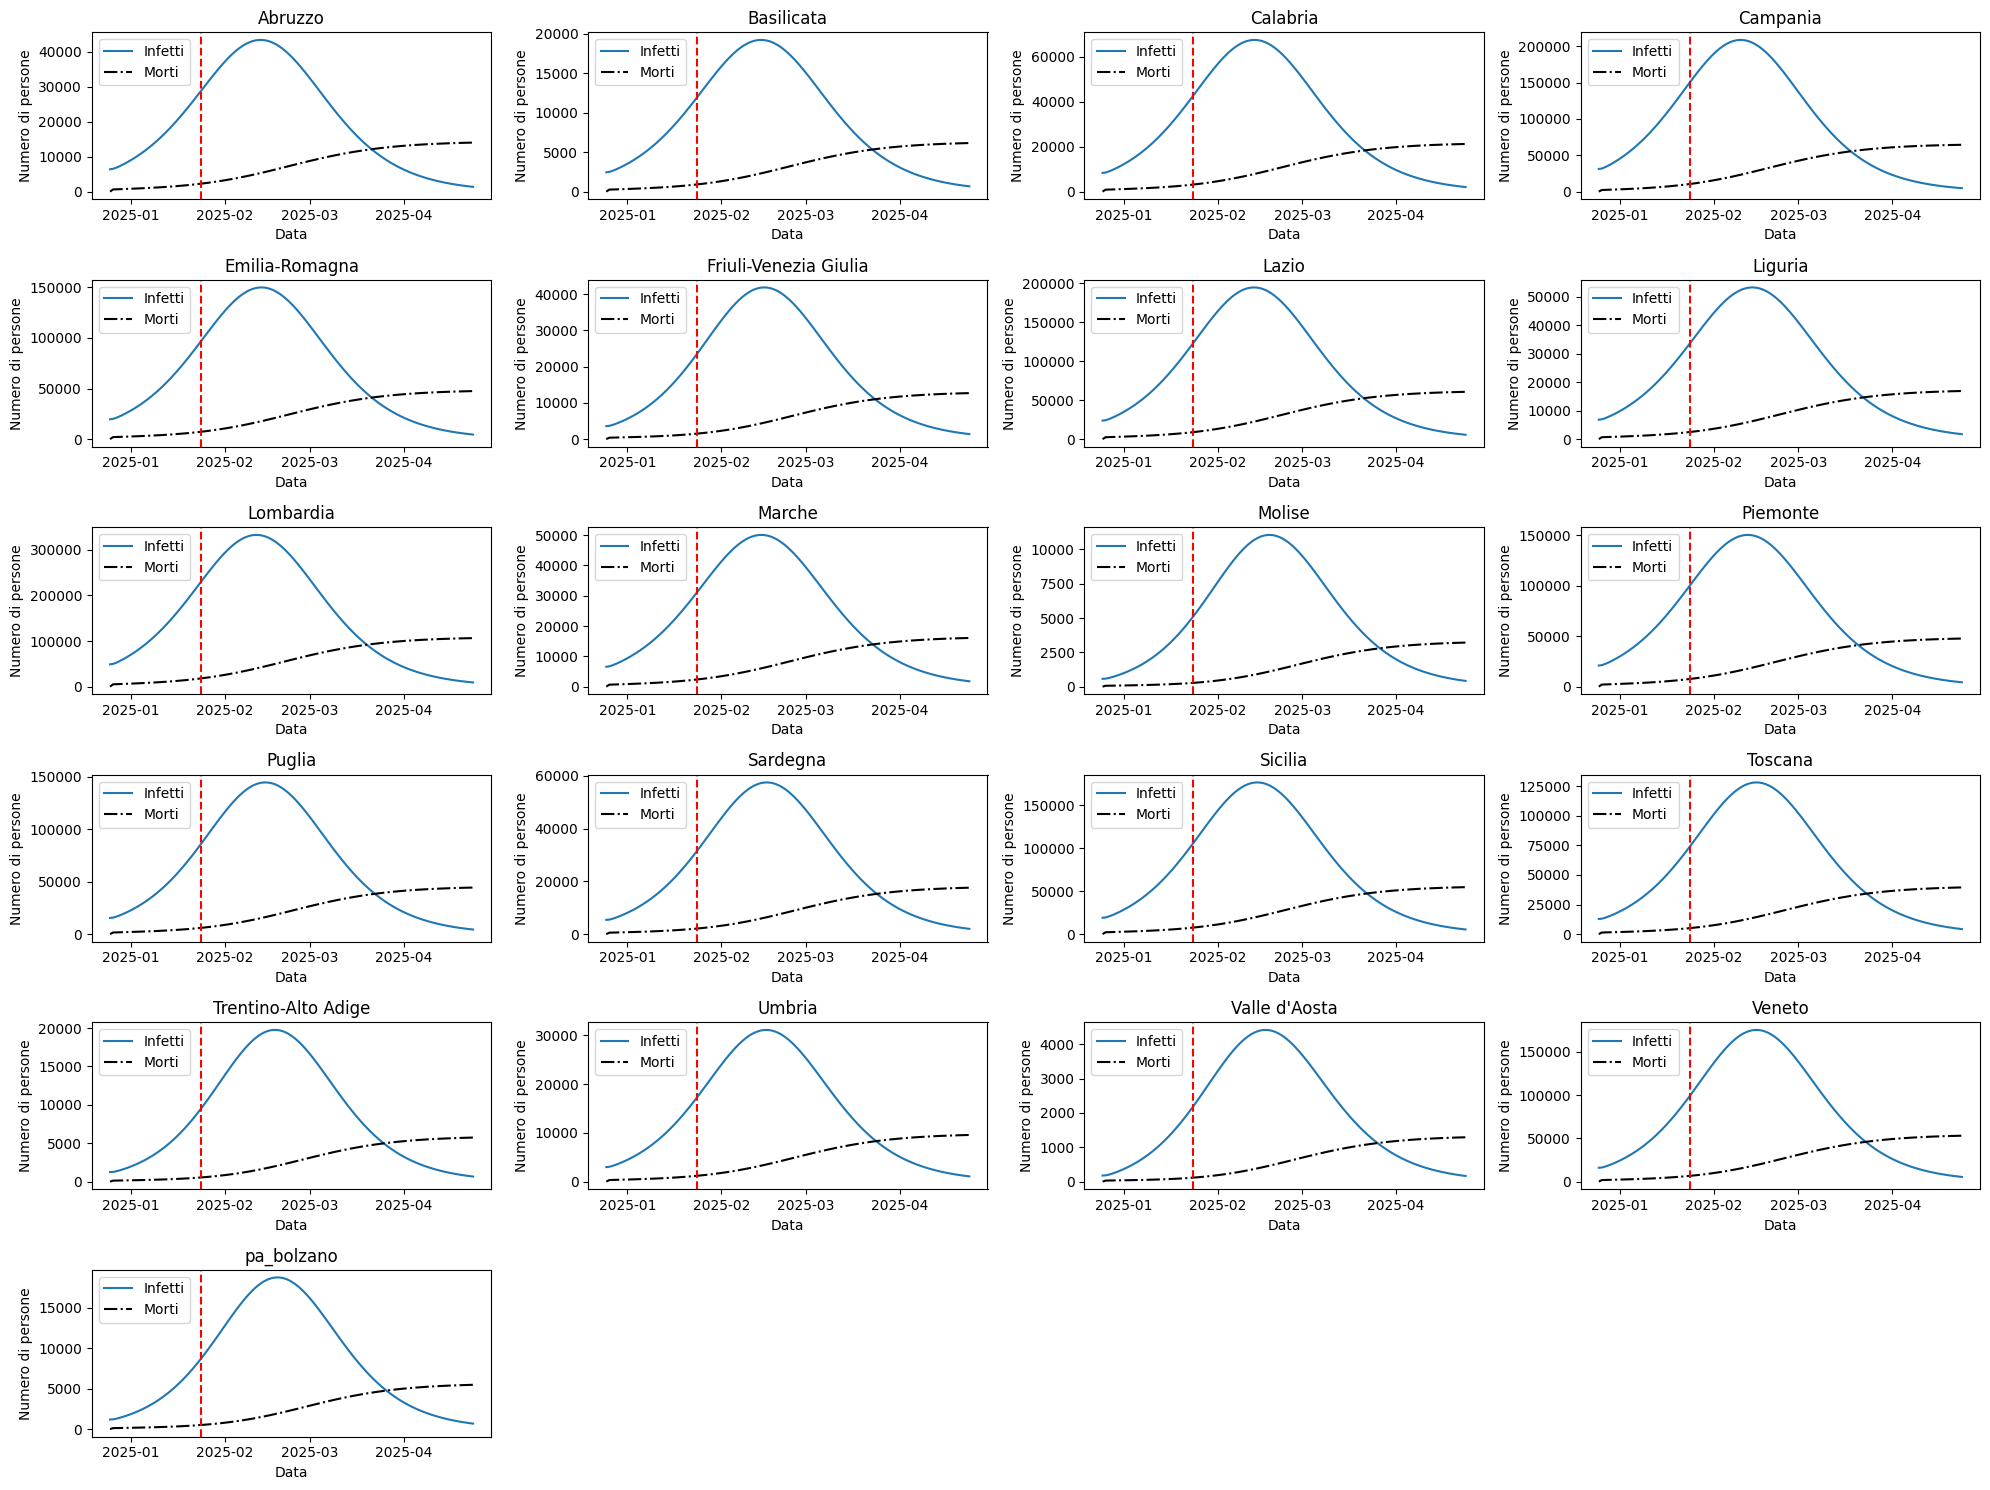

In [45]:
# GRAFICI

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates

province_classification_df = pd.read_csv('popREG.csv')

province_classification_df["Territorio"] = province_classification_df['Territorio'].apply(normalizeNameProvince)


dictProvinceRegioni = dict(province_classification_df[["Territorio", "Regione"]])



dictProvinceRegioni = aggiungiProvinceMancanti(dictProvinceRegioni)


results_df = pd.DataFrame(results)
infected_df = results_df.pivot(index='Date', columns='Province', values='Infetti')

# Normalizziamo i nomi delle province nel DataFrame e nel dizionario
infected_df.columns = [normalizeNameProvince(prov) for prov in infected_df.columns]

infected_df.columns = [dictProvinceRegioni[prov] for prov in infected_df.columns]

vaccination_date = zero_date + timedelta(days=vaccinate_day)


results_df['Date'] = pd.to_datetime(results_df['Date'])
infected_df = results_df.pivot(index='Date', columns='Province', values='Infetti')
removed_df = results_df.pivot(index='Date', columns='Province', values='Rimossi')
deaths_df = results_df.pivot(index='Date', columns='Province', values='Morti')


infected_df.columns = [dictProvinceRegioni[prov] for prov in infected_df.columns]
removed_df.columns = [dictProvinceRegioni[prov] for prov in removed_df.columns]
deaths_df.columns = [dictProvinceRegioni[prov] for prov in deaths_df.columns]


infected_by_region = infected_df.groupby(level=0, axis=1).sum()
removed_by_region = removed_df.groupby(level=0, axis=1).sum()
deaths_by_region = deaths_df.groupby(level=0, axis=1).sum()


num_regions = len(infected_by_region.columns)


cols = 4  
rows = math.ceil(num_regions / cols)  



fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  


for i, region in enumerate(infected_by_region.columns):
    ax = axes[i]
    
    # num of infected people
    ax.plot(infected_by_region.index, infected_by_region[region], label='Infetti')
    
    
    #ax.plot(removed_by_region.index, removed_by_region[region], label='Rimossi', color='green')
    
    
    ax.plot(deaths_by_region.index, deaths_by_region[region], label='Morti', color='black', linestyle='-.')
    
    # Configurazioni grafiche
    ax.set_title(region)
    ax.set_xlabel('Data')
    ax.set_ylabel('Numero di persone')
    ax.legend(loc='upper left')
    
    # Configura i tick delle date per mostrare solo l'inizio di ogni mese
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Aggiungi una linea verticale al giorno delle vaccinazioni
    ax.axvline(vaccination_date, color='red', linestyle='--', label='Vaccinazioni')


for i in range(num_regions, len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


# Simulazioni per Influcast

In [14]:
# tutte queste info ci servono per trasformare i dati delle simulazioni provinciali in dati regionali
# da inviare a influcast

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}

# associamo ogni codice a una regione e al suo numero di abitanti
popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia_romagna"]["abitanti"],
    "06": regioni_info["friuli_venezia_giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa_bolzano"]["abitanti"],
    "13": regioni_info["pa_trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle_d_aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  # Popolazione totale Italia
}

In [15]:
import pandas as pd
import glob
import os

def carica_memoria_recente():
    # questa funzione trova il file di memoria più recente fra quelli nella cartella di lavoro
    file_pattern = "memoria_N_R_giorno_7_*.csv"
    files = glob.glob(file_pattern)
    
    if not files:
        print("Nessun file di memoria trovato. Inizializzazione da zero.")
        return None, None
    
    
    latest_file = max(files, key=os.path.getmtime)
    print(f"Caricamento della memoria da {latest_file}")
    
    # Carica i dati
    memoria = pd.read_csv(latest_file)
    
    # Converte i valori di N e R in array NumPy
    initialN = memoria["N_medio_giorno"].to_numpy()
    initialR = memoria["R_medio_giorno"].to_numpy()
    
    return initialN, initialR

# Carica la memoria più recente
initialN, initialR = carica_memoria_recente()

# se non ci sono file salvati, iniziamo con N e R vuoti
if initialN is None or initialR is None:
    initialN = np.zeros(len(orderedPROV))
    initialR = np.zeros(len(orderedPROV))
    

Caricamento della memoria da memoria_N_R_giorno_7_2025-01-05.csv


In [8]:
initialN = np.zeros(len(orderedPROV))
initialR = np.zeros(len(orderedPROV))

In [16]:
initialR

array([ 76873.91554559,   6010.8582014 ,   6193.71605285,   5457.11804   ,
        12469.00291305,  20045.05401424,   7424.39336591,  14597.28764466,
         2282.94190896,   7661.75933591,  10096.59803883,  30854.46103786,
         7853.70189648,  33462.11845914,  22530.20671527,  12890.24223399,
         6915.49349277, 116568.59690913,  41711.96843509,  47563.12337891,
        20555.81289975,   8560.17591523,  13688.75416969,  15671.12025514,
         8771.84876366,   9093.93332694,  23723.70560991,  22564.70160134,
         5523.81462667,  23094.77694024,  22292.91480986,  24316.06339299,
         6424.30589048,   7812.17116904,  13550.52838939,   3505.19834127,
         5850.17150157,   9820.39070559,  14709.21503712,  17837.56827201,
        23611.41428105,  33627.23743347,  12149.43303721,  13211.81745623,
        13457.62279829,  11069.51165522,   5862.72795291,  11380.68926507,
         8459.9691028 ,  28571.94603387,   7209.31531215,   9844.58599572,
        12053.24286158,  

In [17]:
import pandas as pd
import numpy as np
from datetime import timedelta

''' combinazione migliore finora nella stagione 23/24

'''

# Estrarre i dati reali degli infetti (CasiDistribuiti) a partire dal confronto reali+simulati
# real_infected = confronto[['Date', 'Province', 'CasiDistribuiti']]

# estrai i dati reali a partire da casi_distribuiti_province, salvato prima
file_path = 'casi_distribuiti_province.csv'  
real_infected = pd.read_csv(file_path)
real_infected['Anno'] = real_infected['Settimana'].str.split('_W').str[0].astype(int)
real_infected['SettimanaISO'] = real_infected['Settimana'].str.split('_W').str[1].astype(int)
real_infected['Date'] = real_infected.apply(
    lambda row: datetime.strptime(f'{row.Anno}-W{int(row.SettimanaISO):02}-1', "%Y-W%U-%w"), axis=1
)

#trova l'ultima data disponibile nei dati reali
first_date = pd.to_datetime(real_infected['Date']).max()
#first_date = pd.to_datetime(real_infected['Date']).min()
first_date_str = first_date.strftime('%d-%m-%Y')



# associamo province-regioni
provincia_to_regione = aggiungiProvinceMancanti({})
region_to_code = {  
    'Abruzzo': '01', 'Basilicata': '02', 'Calabria': '03', 'Campania': '04',
    'Emilia-Romagna': '05', 'Friuli-Venezia Giulia': '06', 'Lazio': '07',
    'Liguria': '08', 'Lombardia': '09', 'Marche': '10', 'Molise': '11',
    'Provincia autonoma di Bolzano': '12', 'Provincia autonoma di Trento': '13', 
    'Piemonte': '14', 'Puglia': '15', 'Sardegna': '16', 'Sicilia': '17',
    'Toscana': '18', 'Umbria': '19', 'Valle d\'Aosta': '20', 'Veneto': '21', 'Italia': 'IT'
}

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from numpy import linalg as LA
import time

params = parameters(nh, Whk)
# misuriamo quanto durano le simulazioni
start_time = time.time()
# con 20000 simulazioni crasha
t = 30 # t giorni di simulazione
n = 0
# variamo nu e lambda
nu_values = np.linspace(0.35, 0.40, 15)
lambda_values = np.linspace(0.725e-2, 0.755e-2, 20)

# se per sfizio vogliamo variare b e ai
#b_values = np.linspace(0.15, 0.45, 5)  # Tasso di contatto tra province
#ai_values = [  # Livelli di attività per giovani, anziani, e anziani vaccinati
#    np.array([0.1, 0.4, 0.4]),
#    np.array([0.2, 0.5, 0.5]),
#    np.array([0.15, 0.45, 0.45]),
#    np.array([0.25, 0.55, 0.55]),
#    np.array([0.3, 0.6, 0.6])
#]

# variamo gamma e beta
gamma_values = np.linspace(0.10, 0.10, 1)
beta_values = np.linspace(0.29, 0.36, 15)

# quanti giorni dopo la simulazione dobbiamo salvare N e R?
giorno_salvataggio = 7  # per influcast, 7 giorni


N_specific_day = []
R_specific_day = []

min_error = float('inf')
optimal_params = {}
error_data = []
risultati_provinciali = []
risultati_regionali = []
risultati_simulazioni = []
total_error = 0
for lam in lambda_values:
    for nu in nu_values:
        for beta in beta_values:
            for gamma in gamma_values:
                
                # imponiamo una data combinazione di parametri
                params.Lambda = np.array([lam, lam * 1.3, lam * 1.2])
                params.Nu = nu
                params.Beta = beta
                params.Gamma = gamma

                # impostiamo condizioni iniziali
                #S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e, first_date_str)
                S, E, I, N, R, current_date = initialStatesMemory(params, initial_case_i, initial_case_e, first_date_str, initialN=initialN, initialR=initialR)
                total_error = 0
                risultati_giornalieri = []

                for day in range(t):
                    current_date_step = current_date + timedelta(days=day)
                    #if day == vaccinate_day:
                    #    S = vaccinate_elders(S, params, vaccinate_rate)
                    S, E, I, N, R = oneStepCorretto((S, E, I, N, R), params)

                    # salva N e R di un giorno specifico
                    if day == giorno_salvataggio - 1:  
                        N_specific_day.append(N.sum(axis=0))  
                        R_specific_day.append(R.sum(axis=0))

                    simulated_infected = I.sum(axis=0)  # Totale infetti in una provincia
                    simulated_exposed = E.sum(axis=0)  # Totale esposti in una provincia
                    # salviamo il totale
                    for provincia, infetti, esposti in zip(orderedPROV, simulated_infected, simulated_exposed):
                        risultati_giornalieri.append({
                            "Lambda": lam, "Nu": nu, "Beta": beta, "Gamma": gamma,
                            "giorno": current_date_step, "provincia": provincia, "infetti": infetti, "nuovi_infetti": esposti * nu
                        })
                    #print(day, E.sum()*nu, "nuovi_infetti_giornalieri", lam, nu, beta)
                    # confrontiamo errore (utile se vogliamo trovare combinazione ideale dei parametri)
                    #daily_real_data = real_infected[real_infected['Date'] == current_date_step.strftime('%Y-%m-%d')]
                    #common_provinces = daily_real_data['Territorio'].values
                    #province_mask = [province in common_provinces for province in orderedPROV]

                    #filtered_simulated_infected = simulated_infected[province_mask]
                    #filtered_real_infected = daily_real_data['CasiDistribuiti'].values

                    #if len(filtered_real_infected) > 0:
                    #    error = LA.norm(filtered_simulated_infected - filtered_real_infected, ord=1)
                    #    total_error += error

                # Media dell'errore
                #total_error /= t
                n += 1
                
                risultati_provinciali.extend(risultati_giornalieri)

                

# Calcolo della media o mediana per provincia
N_mean = np.array(N_specific_day).mean(axis=0)
R_mean = np.array(R_specific_day).mean(axis=0)

# Se preferisci la mediana, usa:
# N_median = np.median(N_weekly, axis=0)
# R_median = np.median(R_weekly, axis=0)



#tempo totale impiegato
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tempo totale richiesto per la simulazione: {elapsed_time:.2f} secondi, per un totale di {n} combinazioni di parametri. ")


Tempo totale richiesto per la simulazione: 99.20 secondi, per un totale di 4500 combinazioni di parametri. 


In [18]:
# Calcola la data di cui verrà salvato il numero di N e R (di regola, una settimana dopo l'inizio della simulazione)
data_salvataggio = current_date + timedelta(days=giorno_salvataggio - 1)


province_results = pd.DataFrame({
    "Provincia": orderedPROV,
    "N_medio_giorno": N_mean,
    "R_medio_giorno": R_mean
})


file_name = f"memoria_N_R_giorno_{giorno_salvataggio}_{data_salvataggio.strftime('%Y-%m-%d')}.csv"
province_results.to_csv(file_name, index=False)
print(f"Risultati di N e R salvati per il giorno {giorno_salvataggio} ({data_salvataggio.strftime('%Y-%m-%d')}) in {file_name}")



Risultati di N e R salvati per il giorno 7 (2025-01-12) in memoria_N_R_giorno_7_2025-01-12.csv


# influcast: processiamo i risultati di n simulazioni e li trasformiamo in quantili

In [113]:
df_regionali_completo.query("regione=='Lombardia' and settimana_relativa==1")["giorni_relativi"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [143]:
(df_provinciali
 .groupby(["Lambda","Nu","Beta","Gamma","giorno","provincia"])
 .size()
 .sort_values(ascending=False)
 .head(20)
)

Lambda        Nu        Beta      Gamma  giorno      provincia          
7.618863e-09  0.316036  0.297305  0.1    2024-12-16  cagliari               17
                                                     brindisi               17
                                                     brescia                17
                                                     bolzano                17
                                                     bari                   17
                                                     avellino               17
                                                     asti                   17
                                                     ascolipiceno           17
                                                     arezzo                 17
                                                     ancona                 17
                                                     alessandria            17
                                                     agrig

In [19]:
'''
15000 simulazioni: 5 minuti di processing, 90 secondi di calcolo
'''

df_provinciali = []
df_regionali_completo = []
# convertiamo dati provinciali in regionali
df_provinciali = pd.DataFrame(risultati_provinciali)
df_provinciali["regione"] = df_provinciali["provincia"].map(provincia_to_regione)
#df_provinciali.to_csv("debug2.csv")
(df_provinciali
 .groupby(["Lambda","Nu","Beta","Gamma","giorno","provincia"])
 .size()
 .sort_values(ascending=False)
 .head(20)
)

df_regionali = (
    df_provinciali.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])["nuovi_infetti"]
    .sum()
    .reset_index()
)
risultati_regionali.append(df_regionali)

df_regionali_completo = pd.concat(risultati_regionali)
first_date_str = df_regionali_completo["giorno"].min().strftime("%Y-%m-%d")

# Calcoliamo anno, settimana e settimane relative rispetto all'inizio della simulazione
#df_regionali_completo["anno"] = df_regionali_completo["giorno"].dt.year
#df_regionali_completo["settimana"] = df_regionali_completo["giorno"].dt.isocalendar().week
df_regionali_completo["anno"] = df_regionali_completo["giorno"].dt.isocalendar().year
df_regionali_completo["settimana"] = df_regionali_completo["giorno"].dt.isocalendar().week

df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_regionali_completo["settimana_relativa"] = (df_regionali_completo["giorni_relativi"] // 7) + 1

# Debugging
print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
print("Esempio di valori unici per settimana:", df_regionali_completo["settimana"].unique())
print("Esempio di valori unici per settimana_relativa:", df_regionali_completo["settimana_relativa"].unique())

df_regionali_completo["tipo_valore"] = "quantile"

df_regionali_completo = df_regionali_completo.drop_duplicates(subset=["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])

df_regionali_completo = df_regionali_completo[df_regionali_completo["settimana_relativa"].isin([1, 2, 3, 4])]

df_regionali_completo.query("regione=='Lombardia' and settimana_relativa==1")["giorni_relativi"].unique()


print(df_regionali_completo.head())


df_incidenza_settimanale = (
    df_regionali_completo.groupby(["Lambda", "Nu", "Beta", "Gamma", "regione", "settimana_relativa", "anno", "settimana"])["nuovi_infetti"]
    .sum()
    .reset_index()
)

df_incidenza_settimanale["regione"] = df_incidenza_settimanale["regione"].replace({
    'Trentino-Alto Adige': 'Provincia autonoma di Bolzano',  # Bolzano
    'Trentino-Alto Adige': 'Provincia autonoma di Trento'    # Trento
})
df_incidenza_settimanale["luogo"] = df_incidenza_settimanale["regione"].map(lambda r: region_to_code.get(r, 'Unknown'))
# Aggiunta della popolazione regionale
df_incidenza_settimanale["popolazione"] = df_incidenza_settimanale["luogo"].map(popolazione_regioni)

# Debugging
regioni_senza_popolazione = df_incidenza_settimanale[df_incidenza_settimanale["popolazione"].isna()]["regione"].unique()
if len(regioni_senza_popolazione) > 0:
    print(f"Attenzione: le seguenti regioni non hanno popolazione mappata: {regioni_senza_popolazione}")

# Calcolo dell'incidenza settimanale
df_incidenza_settimanale["incidenza"] = (
    df_incidenza_settimanale["nuovi_infetti"] / df_incidenza_settimanale["popolazione"]
) * 1000
######### DEBUG BAYESIANO
df_problematic = (
    df_incidenza_settimanale
    .query("settimana_relativa == 1 and regione == 'Lombardia'")
    .sort_values("incidenza", ascending=False)
)

print(df_problematic.head(10))  # i 10 peggiori

test_group = df_incidenza_settimanale.query("settimana_relativa==1 and regione=='Lombardia'")
print(len(test_group), "rows per la Lombardia settimana_relativa=1")
print("incidenza range:", test_group["incidenza"].min(), test_group["incidenza"].max())

# Calcolo dei nuovi infetti settimanali totali per ogni simulazione
df_nazionali = df_incidenza_settimanale.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa", "anno", "settimana"]).agg({
    "nuovi_infetti": "sum"
}).reset_index()

# Aggiungiamo la popolazione totale italiana
popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
df_nazionali["popolazione"] = popolazione_italia

# Calcoliamo l'incidenza nazionale
df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000

print(df_nazionali.head())  # Debug


quantili = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

df_quantili_regionali = df_incidenza_settimanale.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "regione": [x["regione"].iloc[0]] * len(quantili),
        "settimana_relativa": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),
        "settimana": [x["settimana"].iloc[0]] * len(quantili),
        "tipo_valore": ["quantile"] * len(quantili)
    })
).reset_index(drop=True)




df_quantili_regionali["orizzonte"] = df_quantili_regionali["settimana_relativa"]
df_quantili_regionali["luogo"] = df_quantili_regionali["regione"].map(region_to_code)
df_quantili_regionali["target"] = "ILI"

print(df_quantili_regionali.head())

Colonne disponibili in df_regionali_completo: Index(['Lambda', 'Nu', 'Beta', 'Gamma', 'giorno', 'regione', 'nuovi_infetti',
       'anno', 'settimana', 'settimana_inizio', 'giorni_relativi',
       'settimana_relativa'],
      dtype='object')
Esempio di valori unici per settimana: <IntegerArray>
[2, 3, 4, 5, 6]
Length: 5, dtype: UInt32
Esempio di valori unici per settimana_relativa: [1 2 3 4 5]
    Lambda    Nu  Beta  Gamma     giorno         regione  nuovi_infetti  anno  \
0  0.00725  0.35  0.29    0.1 2025-01-06         Abruzzo    3372.499222  2025   
1  0.00725  0.35  0.29    0.1 2025-01-06      Basilicata    1987.762210  2025   
2  0.00725  0.35  0.29    0.1 2025-01-06        Calabria    3511.698069  2025   
3  0.00725  0.35  0.29    0.1 2025-01-06        Campania   21104.156077  2025   
4  0.00725  0.35  0.29    0.1 2025-01-06  Emilia-Romagna    6556.855801  2025   

   settimana  settimana_inizio  giorni_relativi  settimana_relativa  \
0          2                 2              

C:\Users\celin\AppData\Local\Temp\ipykernel_10376\305330417.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili_regionali = df_incidenza_settimanale.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(


In [20]:
risultati_provinciali

[{'Lambda': np.float64(0.00725),
  'Nu': np.float64(0.35),
  'Beta': np.float64(0.29),
  'Gamma': np.float64(0.1),
  'giorno': datetime.datetime(2025, 1, 6, 0, 0),
  'provincia': 'torino',
  'infetti': np.float64(10804.319882354172),
  'nuovi_infetti': np.float64(3649.0124090737077)},
 {'Lambda': np.float64(0.00725),
  'Nu': np.float64(0.35),
  'Beta': np.float64(0.29),
  'Gamma': np.float64(0.1),
  'giorno': datetime.datetime(2025, 1, 6, 0, 0),
  'provincia': 'vercelli',
  'infetti': np.float64(850.405141677418),
  'nuovi_infetti': np.float64(280.42386439934006)},
 {'Lambda': np.float64(0.00725),
  'Nu': np.float64(0.35),
  'Beta': np.float64(0.29),
  'Gamma': np.float64(0.1),
  'giorno': datetime.datetime(2025, 1, 6, 0, 0),
  'provincia': 'biella',
  'infetti': np.float64(875.8918669954505),
  'nuovi_infetti': np.float64(294.6583459300607)},
 {'Lambda': np.float64(0.00725),
  'Nu': np.float64(0.35),
  'Beta': np.float64(0.29),
  'Gamma': np.float64(0.1),
  'giorno': datetime.datetime

In [21]:
# sommiamo tutti gli infetti nuovi in una data settimana e con una data combo di parametri
df_nazionali = (
    df_incidenza_settimanale.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa"])["nuovi_infetti"]
    .sum()
    .reset_index()
)


popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
popolazione_italia = sum(
    popolazione for regione, popolazione in popolazione_regioni.items() if regione != "IT"
)

df_nazionali["popolazione"] = popolazione_italia

df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000


df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")


#df_nazionali["anno"] = df_nazionali["data"].dt.year
#df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week
df_nazionali["anno"] = df_nazionali["data"].dt.isocalendar().year
df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week
df_nazionali["orizzonte"] = df_nazionali["settimana_relativa"]

df_quantili_nazionali = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "luogo": ["IT"] * len(quantili),
        "orizzonte": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),
        "settimana": [x["settimana"].iloc[0]] * len(quantili)
    })
).reset_index(drop=True)

df_quantili_nazionali["tipo_valore"] = "quantile"
df_quantili_nazionali["target"] = "ILI"

# uniamo dati regionali e IT
df_quantili_completo = pd.concat([df_quantili_regionali, df_quantili_nazionali], ignore_index=True)

# Debugging
print(df_quantili_completo.head())

df_quantili_completo = df_quantili_completo[["anno", "settimana", "luogo", "tipo_valore", "id_valore", "orizzonte", "valore", "target"]]

# debug per bolzano e trento
bolzano_data = df_quantili_completo[df_quantili_completo["luogo"] == "13"]
bolzano_data["valore"] = bolzano_data["valore"] * 0.5

trentino_data = bolzano_data.copy()
trentino_data["luogo"] = "12"


df_quantili_completo = pd.concat([df_quantili_completo, trentino_data], ignore_index=True)

df_quantili_completo.to_csv("la_fine.csv", index=False)
print("File 'la_fine.csv' salvato con successo!")



   id_valore     valore  regione  settimana_relativa  anno  settimana  \
0      0.010  16.464769  Abruzzo                 1.0  2025          2   
1      0.025  16.602048  Abruzzo                 1.0  2025          2   
2      0.050  16.740186  Abruzzo                 1.0  2025          2   
3      0.100  16.927259  Abruzzo                 1.0  2025          2   
4      0.150  17.064084  Abruzzo                 1.0  2025          2   

  tipo_valore  orizzonte luogo target  
0    quantile          1    01    ILI  
1    quantile          1    01    ILI  
2    quantile          1    01    ILI  
3    quantile          1    01    ILI  
4    quantile          1    01    ILI  
File 'la_fine.csv' salvato con successo!


C:\Users\celin\AppData\Local\Temp\ipykernel_10376\970500173.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili_nazionali = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
C:\Users\celin\AppData\Local\Temp\ipykernel_10376\970500173.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bolzano_data["valore"] = bolzano_data["valore"] * 0.5


In [ ]:
'''
df_provinciali = []
# convertiamo dati provinciali in regionali
df_provinciali = pd.DataFrame(risultati_provinciali)
df_provinciali["regione"] = df_provinciali["provincia"].map(provincia_to_regione)

df_regionali = (
    df_provinciali.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])["nuovi_infetti"]
    .sum()
    .reset_index()
)
risultati_regionali.append(df_regionali)

df_regionali_completo = pd.concat(risultati_regionali)

### FILE ENORME CON 1 MILIONE E MEZZO DI RIGHE, USARE SOLO PER DEBUGGING E PER CAPIRE SE I DATI SONO STATI CONVERTITI CORRETTAMENTE IN DATI REGIONALI
#df_regionali_completo.to_csv("debug1.csv", index=False)


# Calcoliamo anno, settimana e settimane relative rispetto all'inizio della simulazione
df_regionali_completo["anno"] = df_regionali_completo["giorno"].dt.year
df_regionali_completo["settimana"] = df_regionali_completo["giorno"].dt.isocalendar().week
df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_regionali_completo["settimana_relativa"] = (df_regionali_completo["giorni_relativi"] // 7) + 1

# Debugging
#print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
#print("Esempio di valori unici per settimana_relativa:", df_regionali_completo["settimana_relativa"].unique())

df_regionali_completo["tipo_valore"] = "quantile"

print("Valori di settimana_relativa prima del filtro:", df_regionali_completo["settimana_relativa"].unique())

# Filtriamo solo le settimane relative 1, 2, 3, 4 (cioé 7, 14, 21 e 28 giorni dopo l'inizio della simulazione)
df_regionali_completo = df_regionali_completo[df_regionali_completo["settimana_relativa"].isin([1, 2, 3, 4])]
print("Valori di settimana_relativa dopo il filtro:", df_regionali_completo["settimana_relativa"].unique())

print("Valori di settimana_relativa dopo il filtro:", df_regionali_completo["settimana_relativa"].unique())
print("Righe disponibili dopo il filtro:", len(df_regionali_completo))




#if "settimana_relativa" in df_regionali_completo.columns:
#    df_regionali_completo = df_regionali_completo.drop(columns=["settimana_relativa"])

# che quantili servono a influcast?
quantili = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

# debug
if "settimana_relativa" not in df_regionali_completo.columns:
    print("Errore: La colonna 'settimana_relativa' non è presente nel DataFrame.")

print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
print("Esempio di valori:", df_regionali_completo.head())

# troviamo i quantili che ci servono in base a tutte le combinazioni di parmetri che abbiamo testato
df_quantili = df_regionali_completo.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["nuovi_infetti"], [q * 100 for q in quantili]),
        "regione": [x["regione"].iloc[0]] * len(quantili),  
        "settimana_relativa": [x["settimana_relativa"].iloc[0]] * len(quantili)  
    })
).reset_index(drop=True)

print("Colonne in df_quantili:", df_quantili.columns)
print("Valori unici di settimana_relativa in df_quantili:", df_quantili["settimana_relativa"].unique())



df_quantili["orizzonte"] = df_quantili["settimana_relativa"]


df_quantili["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_quantili["orizzonte"] - 1) * 7, unit="D")
df_quantili["anno"] = df_quantili["data"].dt.year
df_quantili["settimana"] = df_quantili["data"].dt.isocalendar().week
df_quantili["regione"] = df_quantili["regione"].replace({
    'Trentino-Alto Adige': 'Provincia autonoma di Bolzano',  # Bolzano
    'Trentino-Alto Adige': 'Provincia autonoma di Trento'    # Trento
})
df_quantili["luogo"] = df_quantili["regione"].map(lambda r: region_to_code.get(r, 'Unknown'))

# Debugging
regioni_non_trovate = df_quantili[df_quantili["luogo"] == 'Unknown']["regione"].unique()
if len(regioni_non_trovate) > 0:
    print(f"Attenzione: Le seguenti regioni non sono state mappate: {regioni_non_trovate}")


df_quantili["target"] = "ILI"
df_quantili["popolazione"] = df_quantili["luogo"].map(lambda x: popolazione_regioni.get(x, 1))
df_quantili["incidenza"] = (df_quantili["valore"] / df_quantili["popolazione"]) * 1000 * 4
df_quantili["valore"] = df_quantili["incidenza"]
df_quantili["tipo_valore"] = "quantile"


df_quantili = df_quantili.drop(columns=["popolazione", "incidenza"])

# debug
print("Colonne disponibili in df_quantili:", df_quantili.columns)


df_quantili = df_quantili[["anno", "settimana", "luogo", "tipo_valore", "id_valore", "orizzonte", "valore", "target"]]

#### CALCOLO PREVALENZA COMPLESSIVA IN ITALIA
####
popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
df_nazionali = df_regionali_completo.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno"]).agg({
    "nuovi_infetti": "sum"
}).reset_index()

# calcoliamo la prevalenza (""incidenza"") nazionale facendo media pesata di quella regionale
df_nazionali["popolazione"] = popolazione_italia
df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000 * 4


df_nazionali["giorni_relativi"] = (df_nazionali["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_nazionali["settimana_relativa"] = (df_nazionali["giorni_relativi"] // 7) + 1
df_nazionali = df_nazionali[df_nazionali["settimana_relativa"].isin([1, 2, 3, 4])]
df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")
df_nazionali["anno"] = df_nazionali["data"].dt.year
df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week

df_italia_quantili = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "luogo": ["IT"] * len(quantili),
        "orizzonte": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),  # Propagare anno
        "settimana": [x["settimana"].iloc[0]] * len(quantili)  # Propagare settimana
    })
).reset_index(drop=True)



df_italia_quantili["tipo_valore"] = "quantile"
df_italia_quantili["target"] = "ILI"

# uniamo il df appena creato con quello coi dati regionali, concatenando i dati nazionali in fondo
df_quantili = pd.concat([df_quantili, df_italia_quantili], ignore_index=True)



df_quantili.to_csv("tentativo_finale.csv", index=False)
print("File CSV salvato con successo nel formato richiesto!")


'''

C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:22: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:23: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days


Valori di settimana_relativa prima del filtro: [1 2 3 4 5 6]
Valori di settimana_relativa dopo il filtro: [1 2 3 4]
Valori di settimana_relativa dopo il filtro: [1 2 3 4]
Righe disponibili dopo il filtro: 1120000
Colonne disponibili in df_regionali_completo: Index(['Lambda', 'Nu', 'Beta', 'Gamma', 'giorno', 'regione', 'nuovi_infetti',
       'anno', 'settimana', 'settimana_inizio', 'giorni_relativi',
       'settimana_relativa', 'tipo_valore'],
      dtype='object')
Esempio di valori:          Lambda    Nu  Beta  Gamma     giorno         regione  nuovi_infetti  \
0  7.800000e-09  0.36  0.25    0.1 2024-11-25         Abruzzo    2910.764975   
1  7.800000e-09  0.36  0.25    0.1 2024-11-25      Basilicata    1125.243764   
2  7.800000e-09  0.36  0.25    0.1 2024-11-25        Calabria    3815.517018   
3  7.800000e-09  0.36  0.25    0.1 2024-11-25        Campania   10126.822577   
4  7.800000e-09  0.36  0.25    0.1 2024-11-25  Emilia-Romagna    9971.682414   

   anno  settimana  settimana

C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili = df_regionali_completo.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:75: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_quantili["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_quantili["orizzonte"] - 1) * 7, unit="D")


Colonne in df_quantili: Index(['id_valore', 'valore', 'regione', 'settimana_relativa'], dtype='object')
Valori unici di settimana_relativa in df_quantili: [1 2 3 4]
Colonne disponibili in df_quantili: Index(['id_valore', 'valore', 'regione', 'settimana_relativa', 'orizzonte',
       'data', 'anno', 'settimana', 'luogo', 'target', 'tipo_valore'],
      dtype='object')


C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:117: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_nazionali["giorni_relativi"] = (df_nazionali["giorno"] - pd.to_datetime(first_date_str)).dt.days
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:120: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the 

File CSV salvato con successo nel formato richiesto!


In [43]:
print(df_pivot.columns)



Index([], dtype='float64', name='id_valore')


# dai quantili ai grafici

Regione: 01, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 02, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 03, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 04, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 05, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 06, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 07, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 08, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 09, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.95], dtype='float64', name='id_valore')
Regione: 10, Colonne del pivot: Index([0.05, 0.25, 0.5, 0.75, 0.

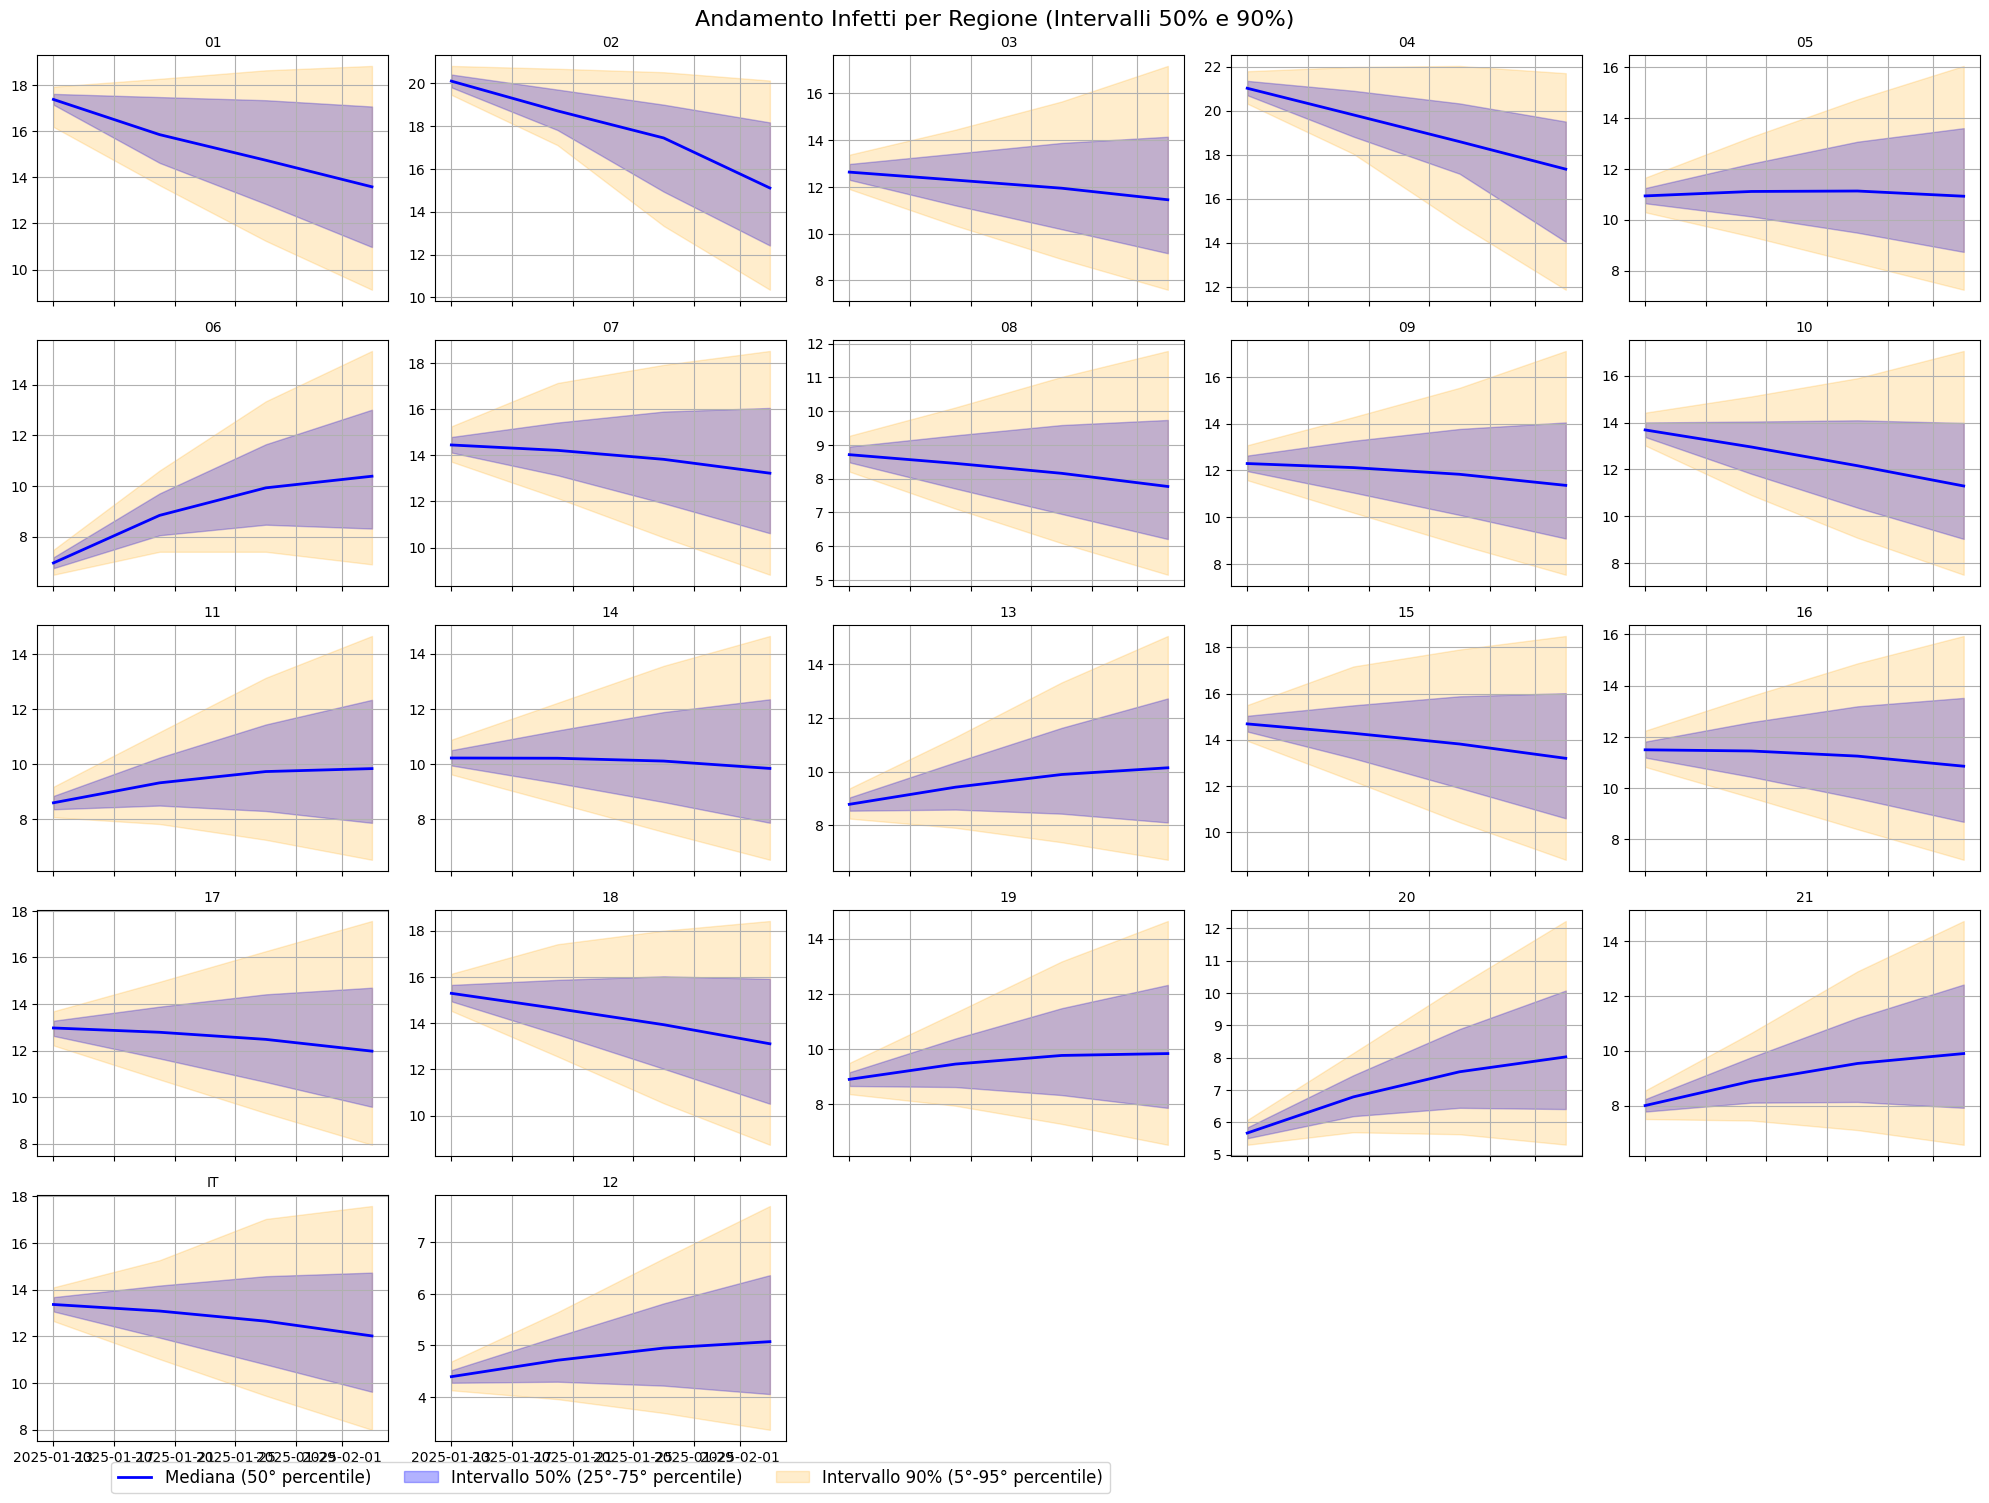

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math


df_quantili = pd.read_csv("la_fine.csv")


df_quantili = df_quantili[df_quantili["target"] == "ILI"]


def normalizza_valore(valore):
    if valore > 17:
        return 17 + (valore - 17) * 0.5
    elif valore > 13:
        return 13 + (valore - 13) * 0.85
    return valore


df_quantili['valore'] = df_quantili['valore'].apply(normalizza_valore)


df_quantili = df_quantili.dropna(subset=["luogo"])

df_quantili.to_csv("influcast_12-01.csv", index=False)


df_quantili["data"] = pd.to_datetime(
    df_quantili["anno"].astype(str) + "-W" + df_quantili["settimana"].astype(str) + "-1", 
    format="%Y-W%W-%w",
    errors="coerce"  # Gestisce eventuali errori di conversione
)

invalid_dates = df_quantili[df_quantili["data"].isnull()]
if not invalid_dates.empty:
    print("Date non valide trovate:")
    print(invalid_dates)



quantili_interesse = [0.05, 0.25, 0.5, 0.75, 0.95]
df_filtered = df_quantili[df_quantili["id_valore"].isin(quantili_interesse)]


if df_filtered["data"].isnull().any():
    print("Errore: alcune date non sono valide")
    df_filtered = df_filtered.dropna(subset=["data"])  


regioni = df_filtered["luogo"].unique()
num_regions = len(regioni)
cols = 5  
rows = math.ceil(num_regions / cols)  
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=True)
axes = axes.flatten()  


for i, regione in enumerate(regioni):
    ax = axes[i]
    df_region = df_filtered[df_filtered["luogo"] == regione]
    
    
    df_pivot = df_region.pivot(index="data", columns="id_valore", values="valore")
    
    
    print(f"Regione: {regione}, Colonne del pivot: {df_pivot.columns}")
    
    
    required_columns = [0.05, 0.25, 0.5, 0.75, 0.95]
    for col in required_columns:
        if col not in df_pivot.columns:
            print(f"Avviso: Colonna {col} mancante per la regione {regione}")
            #df_pivot[col] = None  # Aggiungi colonna vuota per evitare errori
            df_pivot[col] = np.nan


    
    data = df_pivot.index
    q05 = df_pivot[0.05]
    q25 = df_pivot[0.25]
    median = df_pivot[0.5]
    q75 = df_pivot[0.75]
    q95 = df_pivot[0.95]

    
    ax.plot(data, median, label="Mediana (50° percentile)", color="blue", linewidth=2)
    ax.fill_between(data, q25, q75, color="blue", alpha=0.3, label="Intervallo 50% (25°-75° percentile)")
    ax.fill_between(data, q05, q95, color="orange", alpha=0.2, label="Intervallo 90% (5°-95° percentile)")
    ax.set_title(f"{regione}", fontsize=10)
    ax.grid(True)


for i in range(len(regioni), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Andamento Infetti per Regione (Intervalli 50% e 90%)", fontsize=16)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
plt.show()


# Simulazioni per Influcast con metodo bayesiano 1

In [32]:
popolazione_italia

NameError: name 'popolazione_italia' is not defined

In [26]:
flu_df.to_csv("debug1.csv")

In [117]:
W = 45 # settimana corrente (da cui prendere i dati)

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os

# ====================
# FUNZIONI DI SUPPORTO
# parte di codice in cui diamo forma alla distribuzione a posteriori dei parametri, utilizzando
# i dati reali di quest'anno, delle settimane precedenti
# ====================

import os
import numpy as np
import pandas as pd


# --- FUNZIONI DI SUPPORTO ---
def normalizeNameProvince(name: str) -> str:
    name = name.lower().replace("'", "").replace("-", "").replace(" ", "")
    return name

def initialStatesMemoryBayes(p, initialCaseI=None, initialCaseE=None, start_date=None, initialN=None, initialR=None):
    """
    Inizializza gli stati S, E, I, N, R in modo che la popolazione totale sia conservata:
    S + E + I + N + R = p.nh.sum(0).
    
    Parametri
    ---------
    p : oggetto con attributi:
        - Whk (matrice di flussi) per dedurre il movimento dei pendolari
        - nh (popolazione per ogni provincia)
        - eta (vettore [eta_giovani, eta_anziani, eta_anz_vaccinati])
    initialCaseI : vettore numero di infetti iniziali totali per provincia
    initialCaseE : vettore numero di esposti iniziali totali 
    start_date : str, data di inizio simulazione in formato 'dd-mm-YYYY'
    initialN : vettore numero non contagiosi iniziali totali (ripartiti in base a p.eta) 
    initialR : vettore numero rimossi iniziali totali (ripartiti in base a p.eta)
    
    Ritorna
    -------
    S, E, I, N, R, current_date
    """

    import datetime
    from datetime import datetime as dt

    # shape = (3, numero_province), perché p.eta ha dimensione 3 (giovani, anziani, anziani vaccinati)
    shape = (3, p.Whk.shape[0])  
    
    I = np.zeros(shape)
    E = np.zeros(shape)
    N = np.zeros(shape)
    R = np.zeros(shape)
    
    
    if initialCaseI is not None:
        I[0] = initialCaseI * p.eta[0]  # Giovani
        I[1] = initialCaseI * p.eta[1]  # Anziani
        I[2] = initialCaseI * p.eta[2]  # Anziani vaccinati
        
    
    if initialCaseE is not None:
        E[0] = initialCaseE * p.eta[0]  # Giovani
        E[1] = initialCaseE * p.eta[1]  # Anziani
        E[2] = initialCaseE * p.eta[2]  # Anziani vaccinati

    
    if initialN is not None:
        N[0] = initialN * p.eta[0]
        N[1] = initialN * p.eta[1]
        N[2] = initialN * p.eta[2]

    
    if initialR is not None:
        R[0] = initialR * p.eta[0]
        R[1] = initialR * p.eta[1]
        R[2] = initialR * p.eta[2]

    
    Stot = np.ones(shape) * p.eta.reshape(-1, 1).dot(p.nh.reshape(1, -1))

    
    S = Stot - E - I - N - R
    
    # Se c'è un errore nel bilancio e S diventa negativa arrestiamo tutto
    if np.any(S < 0):
        raise ValueError("Numero negativo di suscettibili, errore nell'inizializzazione: "
                         "la somma E+I+N+R ha superato la popolazione.")
    
    
    if start_date is not None:
        current_date = dt.strptime(start_date, '%d-%m-%Y')
    else:
        current_date = datetime.datetime.now()
    
    return S, E, I, N, R, current_date


def iso_week_to_date(year, week, day=1):
    first_week_day = datetime.date(year, 1, 4)
    delta = datetime.timedelta(weeks=week-1, days=day - first_week_day.isoweekday())
    return first_week_day + delta


def week_str_to_date_iso(week_str):
    """Prende una stringa 'YYYY_Www' e restituisce il lunedì di quella settimana ISO."""
    year_str, week_str = week_str.split('_W')
    year = int(year_str)
    week = int(week_str)
    return iso_week_to_date(year, week, 1)


def normal_prior_sampling(N_samples, mu, sigma):
    return np.random.normal(mu, sigma, N_samples)

def uniform_prior_sampling(N_samples, low, high):
    return np.random.uniform(low, high, N_samples)

def gaussian_likelihood(y_obs, y_pred, sigma):
    """
    Calcola la log-likelihood di y_obs ~ N(y_pred, sigma^2) per un insieme di dati (quindi y_obs si considera estratto da una normale).
    y_obs e y_pred devono avere la stessa numerosità
    Ritorna la somma delle log-likelihood su tutti i punti.
    """
    residuals = y_obs - y_pred
    ll = -0.5 * np.sum((residuals**2) / sigma**2) - (len(residuals)/2)*np.log(2*np.pi*sigma**2)
    return ll


def readFluDatasetInflucastBayes(
    flu_file: str,
    target_week_str: str,
    pop_file: str = 'Data\\FinalForCommuting\\pop.csv',
    flow_file: str = 'Data\\FinalForCommuting\\A_adj_province.csv'
):
    """
    Legge i dati di influenza (casi distribuiti per provincia), la popolazione provinciale,
    la matrice dei flussi provinciali e restituisce:
      - nh: array con la popolazione per provincia (nell'ordine definito da orderedPROV)
      - Whk: matrice di flusso normalizzata
      - initial_case_i: vettore di infetti iniziali (per la settimana target)
      - initial_case_e: vettore di esposti iniziali (per la settimana target)
      - orderedPROV: lista ordinata delle province
      - flu_init_dict: dizionario {provincia: casi} per la settimana target
      - flu_df: dataframe completo con tutte le settimane
      - week_flu_df: dataframe filtrato per la settimana target
    """

    # ================================
    # 1) Lettura e normalizzazione popolazione
    # ================================
    pop_df = pd.read_csv(pop_file)
    pop_df['Territorio'] = pop_df['Territorio'].apply(normalizeNameProvince)
    
    # Dizionario provincia -> popolazione
    popPROV = dict(zip(pop_df['Territorio'], pop_df['Value']))
    # orderedPROV: elenco coerente di province
    orderedPROV = pop_df['Territorio'].tolist()
    
    # ================================
    # 2) Lettura e normalizzazione matrice di flusso
    # ================================
    flowMatrix = pd.read_csv(flow_file, sep=";", index_col=0)
    flowMatrix.index = flowMatrix.index.to_series().apply(normalizeNameProvince)
    flowMatrix.columns = flowMatrix.columns.to_series().apply(normalizeNameProvince)
    
    # Riordiniamo righe e colonne
    flowMatrix = flowMatrix.loc[orderedPROV, orderedPROV]
    Whk = flowMatrix.to_numpy(dtype=float)

    # Azzeriamo la diagonale per non avere auto-flusso
    np.fill_diagonal(Whk, 0)

    # Evitiamo divisioni per zero
    row_sums = Whk.sum(axis=1)
    row_sums[row_sums == 0] = 1e-12
    Whk = Whk / row_sums.reshape(-1, 1)

    # ================================
    # 3) Lettura dati reali (flu_file)
    # ================================
    flu_df = pd.read_csv(flu_file)
    flu_df['Territorio'] = flu_df['Territorio'].apply(normalizeNameProvince)
    
    
    required_cols = {"Territorio", "Settimana", "CasiDistribuiti"}
    missing_cols = required_cols - set(flu_df.columns)
    if missing_cols:
        raise ValueError(f"Mancano le colonne {missing_cols} nel file {flu_file}.")
    
    # Ricaviamo Anno e Numero di settimana dalla colonna "Settimana"
    flu_df['Anno'] = flu_df['Settimana'].str.split('_W').str[0].astype(int)
    flu_df['WeekNum'] = flu_df['Settimana'].str.split('_W').str[1].astype(int)

    
    # Estraiamo anno e settimana target
    try:
        year_str, week_str = target_week_str.split('_W')
        year = int(year_str)
        week = int(week_str)
    except Exception as e:
        raise ValueError(f"Errore nel parsing di target_week_str={target_week_str}. "
                         f"Formato atteso: 'YYYY_Www'. Dettagli: {e}")
    
    # ================================
    # 4) Filtraggio della settimana target
    # ================================
    week_flu_df = flu_df[(flu_df['Anno'] == year) & (flu_df['WeekNum'] == week)].copy()
    
    # Costruiamo il dizionario {provincia -> casi} per la settimana target
    flu_init_dict = dict(zip(week_flu_df['Territorio'], week_flu_df['CasiDistribuiti']))

    # Se qualche provincia manca, assegniamo 0
    for prov in orderedPROV:
        if prov not in flu_init_dict:
            flu_init_dict[prov] = 0.0

    # Eventuali correzioni, se servono
    if "reggionellemilia" in flu_init_dict:
        flu_init_dict["reggioemilia"] = flu_init_dict["reggionellemilia"]
    if "monzaedellabrianza" in flu_init_dict:
        flu_init_dict["monzaebrianza"] = flu_init_dict["monzaedellabrianza"]

    # ================================
    # 5) Creazione stati iniziali
    # ================================
    nh = np.array([popPROV[prov] for prov in orderedPROV], dtype=float)

    # Infetti iniziali
    initial_case_i = np.array([flu_init_dict[prov] for prov in orderedPROV], dtype=float)

    # Esposti iniziali (se la tua ipotesi è E = I * (1/ nu ))
    initial_case_e = initial_case_i * (1.0 / 0.33)

    # ================================
    # 6) Output
    # ================================
    return (
        nh,              # array popolazione
        Whk,             # matrice flussi normalizzata
        initial_case_i,  # infetti
        initial_case_e,  # esposti
        orderedPROV,     # elenco province
        flu_init_dict,   # {prov: casi}
        flu_df,          # dataset completo
        week_flu_df      # dataset filtrato per la settimana target
    )

############################
# Codice Principale
############################

# Parametri generali
N_SAMPLES = 2000
SIGMA_LIKELIHOOD = 1.5
#POSTERIOR_FILE = "posterior_parameters_prev_week.csv"
POSTERIOR_FILE = "posterior_parameters_current_week.csv"


# Supponiamo di voler fare la previsione per la settimana "2024_W43"
CURRENT_WEEK = f"2024_W{W+1}"
PREV_WEEK = f"2024_W{W}"

print(f"simuliamo la settimana {CURRENT_WEEK} partendo dai dati reali della settimana {PREV_WEEK}")

# 1) Leggiamo i dati reali della settimana PREV_WEEK (oppure CURRENT_WEEK, a seconda della logica)
#    In genere, se vogliamo prevedere la settimana "2024_W43", partiamo dai dati di "2024_W42".
target_week_str = PREV_WEEK
flu_file = "casi_distribuiti_province.csv"

(
    nh, Whk, initial_case_i, initial_case_e, 
    orderedPROV, flu_init_dict, flu_df, week_flu_df
) = readFluDatasetInflucastBayes(
    flu_file=flu_file,
    target_week_str=target_week_str
)

# Se vuoi la data di inizio simulazione dal LUNEDÌ di CURRENT_WEEK:
first_date = week_str_to_date_iso(CURRENT_WEEK)
first_date_str = first_date.strftime('%d-%m-%Y')

# Adatta i casi iniziali (se lo fai ancora)
initial_case_i = initial_case_i / (7 * 0.33)
initial_case_e = initial_case_e / 7

# 2) Caricamento Prior/Posterior
if os.path.exists(POSTERIOR_FILE):
    print("acquisiti dati sulla distribuzione a posteriori della settimana precedente")
    df_prior = pd.read_csv(POSTERIOR_FILE)
    df_prior["weight"] = df_prior["weight"] / df_prior["weight"].sum()
    params_index = np.random.choice(df_prior.index, size=N_SAMPLES, p=df_prior["weight"].values)
    sampled_params = df_prior.loc[params_index, ["Lambda", "Nu", "Beta", "Gamma"]].values
else:
    # Generazione di un prior (uniforme) di esempio
    # col campionamento uniforme (non bayesiano) usavamo
    # nu_values = np.linspace(0.27, 0.33, 12)
    # lambda_values = np.linspace(0.73e-8, 0.83e-8, 20)
    # gamma_values = np.linspace(0.10, 0.10, 1)
    # beta_values = np.linspace(0.29, 0.36, 13)
    print("non sono stati trovati dati sulla distribuzione a posteriori della settimana precedente")
    Lambda_samples = uniform_prior_sampling(N_SAMPLES, 7.8e-3, 8.2e-3)
    Nu_samples = uniform_prior_sampling(N_SAMPLES, 0.3, 0.6)
    Beta_samples = uniform_prior_sampling(N_SAMPLES, 0.2, 0.45)
    Gamma_samples = np.random.uniform(0.1, 0.1, N_SAMPLES)
    sampled_params = np.column_stack([Lambda_samples, Nu_samples, Beta_samples, Gamma_samples])

memoria_file = "memoria_settimana_precedente_bayes.csv"

if os.path.exists(memoria_file):
    # Se esiste, leggiamo i valori N_medio e R_medio
    print("Carico i valori di N e R dalla settimana precedente...")
    df_memoria = pd.read_csv(memoria_file)
    # Ad esempio, la colonna "N_medio" e "R_medio" contengono i valori finali medi
    N_iniziali = df_memoria["N_medio"].values  # deve avere dimensioni coerenti con le province
    R_iniziali = df_memoria["R_medio"].values
else:
    # Se non esiste, partiamo con N_iniziali e R_iniziali = 0
    print("Nessuna memoria trovata. Inizializzo N e R a zero...")
    N_iniziali = None
    R_iniziali = None


simulation_results = []
accumulated_N = []
accumulated_R = []
#print(initial_case_e)
#print(initial_case_i)
for (Lambda_val, Nu_val, Beta_val, Gamma_val) in sampled_params:
    # Crea parametri del modello
    params = parameters(nh, Whk)
    params.Lambda = np.array([Lambda_val, Lambda_val*1.3, Lambda_val*1.2])
    params.Nu = Nu_val
    params.Beta = Beta_val
    params.Gamma = Gamma_val
    
    # Inizializza stato
    S, E, I, N, R, current_date = initialStatesMemoryBayes(
        params, 
        initial_case_i, 
        initial_case_e, 
        first_date_str, 
        initialN=N_iniziali, 
        initialR=R_iniziali
    )

    # Accumulatore per i 7 giorni
    nuovi_casi_settimanali = 0.0

    # Simuliamo 7 giorni
    for day in range(7):
        S, E, I, N, R = oneStepCorretto((S, E, I, N, R), params)
        #print(f"Giorno {day}: S={S.sum()}, E={E.sum()}, I={I.sum()}, N={N.sum()}, R={R.sum()}")
        nuovi_giornalieri = E.sum() * params.Nu
        #print(f"Giorno {day}, nuovi infetti: {nuovi_giornalieri}")
        pop_model = S.sum() + E.sum() + I.sum() + N.sum() + R.sum()
        pop_real = nh.sum()
        #print(f"Giorno {day}: pop_model={pop_model}, pop_real={pop_real}")

        #print(E.sum())
        # Calcolo dei nuovi infetti nella giornata
        # (somma di tutti gli esposti * tasso di transizione)
        nuovi_casi_settimanali += E.sum() * params.Nu
        #print(nuovi_casi_settimanali)
    
    accumulated_N.append(N.sum(axis=0))
    accumulated_R.append(R.sum(axis=0))


    # Adesso converti in incidenza su 1000 persone
    popolazione_nazionale = nh.sum()
    incidenza_settimanale = (nuovi_casi_settimanali / popolazione_nazionale) * 1000
    #print(f"Ecco l'incidenza settimanale simulata per la settimana {CURRENT_WEEK}")
    #print(incidenza_settimanale)
    simulation_results.append({
        "Lambda": Lambda_val,
        "Nu": Nu_val,
        "Beta": Beta_val,
        "Gamma": Gamma_val,
        "incidenza_simulata": incidenza_settimanale
    })

mean_N = np.mean(accumulated_N, axis=0)
mean_R = np.mean(accumulated_R, axis=0)

df_memoria = pd.DataFrame({
    "province": orderedPROV,
    "N_medio": mean_N,
    "R_medio": mean_R
})
df_memoria.to_csv(memoria_file, index=False)
print(f"File {memoria_file} salvato correttamente, con i valori medi di N e R.")

df_sim = pd.DataFrame(simulation_results)

# 4) Calcolo della likelihood
#    Ora vogliamo confrontare i risultati della simulazione (per CURRENT_WEEK)
#    con i dati reali di CURRENT_WEEK, che potremmo leggere dalla stessa funzione,
#    ma passandole target_week_str=CURRENT_WEEK.
def get_real_incidence_for_week(week_str):
    """
    leggiamo il file con l'incidenza nazionale
    """
    df_real = pd.read_csv(f"C:\\Users\\celin\\OneDrive\\Desktop\\polito\\drive-download-20241207T142618Z-001\\codice tesi\\dati_reali_24-25\\2024_{W+1}\\italia-2024_{W+1}-ILI.csv")
    # Normalizza Territorio se serve
    #df_real["Territorio"] = df_real["Territorio"].apply(normalizeNameProvince)
    
    
    y, w = week_str.split('_W')
    y, w = int(y), int(w)
    df_filtered = df_real[(df_real["anno"] == y) & (df_real["settimana"] == w)]
    
    # Somma i casi
    totale_casi = df_filtered["incidenza"].sum()
    print(f"stando ai dati, l'incidenza settimanale reale nella settimana {W+1} (cioé 7 giorni dopo l'inizio di queste simulazioni)sarà: ")
    print(totale_casi)
    return totale_casi

y_obs = get_real_incidence_for_week(CURRENT_WEEK)
y_pred = df_sim["incidenza_simulata"].values

# Se stai confrontando un singolo valore di incidenza globale, la dimensione di y_obs è 1
# e y_pred è un array di dimensione N_SAMPLES. Creiamo un array [y_obs] di dimensione 1
log_likelihoods = []
for pred in y_pred:
    ll = gaussian_likelihood(np.array([y_obs]), np.array([pred]), SIGMA_LIKELIHOOD)
    log_likelihoods.append(ll)

df_sim["log_likelihood"] = log_likelihoods

# 5) Creazione e salvataggio della posterior
max_ll = df_sim["log_likelihood"].max()
df_sim["weight"] = np.exp(df_sim["log_likelihood"] - max_ll)
df_sim["weight"] = df_sim["weight"] / df_sim["weight"].sum()

df_posterior = df_sim[["Lambda", "Nu", "Beta", "Gamma", "weight"]]
df_posterior["week_end"] = CURRENT_WEEK
df_posterior.to_csv("posterior_parameters_current_week.csv", index=False)
# salviamo la posterior anche in un file con nome personalizzato per una consultazione più facile
df_posterior.to_csv(f"posterior_parameters_{CURRENT_WEEK}.csv", index=False)
print("Posterior salvata in 'posterior_parameters_current_week.csv'")

W += 1

simuliamo la settimana 2024_W50 partendo dai dati reali della settimana 2024_W49
acquisiti dati sulla distribuzione a posteriori della settimana precedente
Carico i valori di N e R dalla settimana precedente...
File memoria_settimana_precedente_bayes.csv salvato correttamente, con i valori medi di N e R.
stando ai dati, l'incidenza settimanale reale nella settimana 50 (cioé 7 giorni dopo l'inizio di queste simulazioni)sarà: 
9.51798042146654
Posterior salvata in 'posterior_parameters_current_week.csv'


C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3783367033.py:445: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posterior["week_end"] = CURRENT_WEEK


In [123]:
mean_N

array([31190.02837764,  2313.44869294,  2383.71891182,  2111.97349338,
        4967.18061684,  8057.44926315,  2928.66324505,  5749.20803784,
         754.0163041 ,  2738.53663683,  3650.42146019, 11141.78474464,
        2810.01196807, 14557.97738795,  9922.14357833,  5550.78113794,
        2883.05020697, 51058.13418722, 18291.23537937, 21062.33892804,
        9003.54087493,  3647.09484569,  5890.07516486,  6906.68844204,
        3167.9489798 ,  3330.94086412, 10101.12979495,  9565.63003527,
        2329.06512441,  9958.14001196,  9432.60939129, 10440.44056517,
        2683.05184274,  3361.19888623,  5784.54052064,  1473.16693702,
        2469.89317606,  3966.00358952,  5835.0213731 ,  7133.1937148 ,
        9668.82875826, 13743.25834101,  4922.55969898,  5313.28356046,
        5458.5226408 ,  4423.38452868,  2124.31802024,  4034.7208216 ,
        3054.25386045, 10222.39146283,  2578.88758407,  3532.04681735,
        4202.16328963,  3634.54300662,  2749.10990571,  2336.96407341,
      

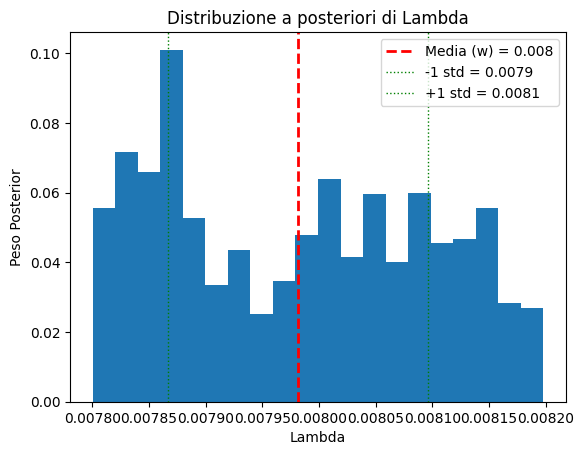

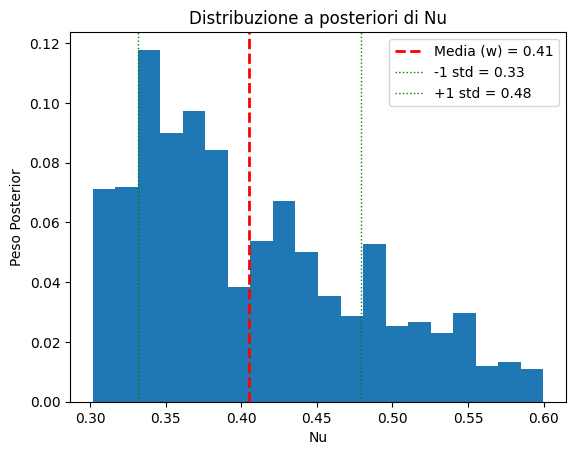

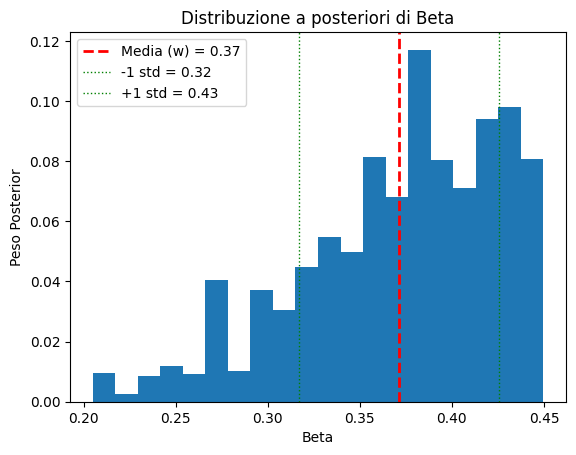

In [124]:
import matplotlib.pyplot as plt

import numpy as np

def weighted_mean_var(values, weights):
    """Ritorna la (media_pesata, varianza_pesata)."""
    w_sum = np.sum(weights)
    mean_w = np.sum(weights * values) / w_sum
    var_w = np.sum(weights * (values - mean_w)**2) / w_sum
    return mean_w, var_w

for param in ["Lambda", "Nu", "Beta"]:
    values = df_posterior[param].values
    weights = df_posterior["weight"].values
    
    mean_w, var_w = weighted_mean_var(values, weights)
    std_w = np.sqrt(var_w)
    
    plt.hist(values, weights=weights, bins=20)
    plt.xlabel(param)
    plt.ylabel("Peso Posterior")
    plt.title(f"Distribuzione a posteriori di {param}")
    plt.axvline(mean_w, color='red', linestyle='--', linewidth=2, 
                label=f"Media (w) = {mean_w:.2g}")
    plt.axvline(mean_w - std_w, color='green', linestyle=':', linewidth=1, 
                label=f"-1 std = {mean_w - std_w:.2g}")
    plt.axvline(mean_w + std_w, color='green', linestyle=':', linewidth=1, 
                label=f"+1 std = {mean_w + std_w:.2g}")
    plt.legend()
    plt.show()


# Simulazioni con metodo bayesiano 2

In [113]:
# tutte queste info ci servono per trasformare i dati delle simulazioni provinciali in dati regionali
# da inviare a influcast

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}


popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia_romagna"]["abitanti"],
    "06": regioni_info["friuli_venezia_giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa_bolzano"]["abitanti"],
    "13": regioni_info["pa_trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle_d_aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  # Popolazione totale Italia
}

import pandas as pd
import glob
import os

def carica_memoria_recente():
    # questa funzione trova il file di memoria più recente fra quelli nella cartella di lavoro, necessaria per conservare N e R
    file_pattern = "memoria_N_R_giorno_7_*.csv"
    files = glob.glob(file_pattern)
    
    if not files:
        print("Nessun file di memoria trovato. Inizializzazione da zero.")
        return None, None
    
    
    latest_file = max(files, key=os.path.getmtime)
    print(f"Caricamento della memoria da {latest_file}")
    
    
    memoria = pd.read_csv(latest_file)
    
    
    initialN = memoria["N_medio_giorno"].to_numpy()
    initialR = memoria["R_medio_giorno"].to_numpy()
    
    return initialN, initialR


initialN, initialR = carica_memoria_recente()

# se non ci sono file salvati, iniziamo con N e R vuoti
if initialN is None or initialR is None:
    initialN = np.zeros(len(orderedPROV))
    initialR = np.zeros(len(orderedPROV))
    


Caricamento della memoria da memoria_N_R_giorno_7_2024-12-22.csv


In [125]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# estrai i dati reali a partire da casi_distribuiti_province, salvato prima
file_path = 'casi_distribuiti_province.csv'  
real_infected = pd.read_csv(file_path)
real_infected['Anno'] = real_infected['Settimana'].str.split('_W').str[0].astype(int)
real_infected['SettimanaISO'] = real_infected['Settimana'].str.split('_W').str[1].astype(int)
real_infected['Date'] = real_infected.apply(
    lambda row: datetime.strptime(f'{row.Anno}-W{int(row.SettimanaISO):02}-1', "%Y-W%U-%w"), axis=1
)

#trova l'ultima data disponibile nei dati reali
first_date = pd.to_datetime(real_infected['Date']).max()
#first_date = pd.to_datetime(real_infected['Date']).min()
first_date_str = first_date.strftime('%d-%m-%Y')

# associamo province-regioni
provincia_to_regione = aggiungiProvinceMancanti({})
region_to_code = {  
    'Abruzzo': '01', 'Basilicata': '02', 'Calabria': '03', 'Campania': '04',
    'Emilia-Romagna': '05', 'Friuli-Venezia Giulia': '06', 'Lazio': '07',
    'Liguria': '08', 'Lombardia': '09', 'Marche': '10', 'Molise': '11',
    'Provincia autonoma di Bolzano': '12', 'Provincia autonoma di Trento': '13', 
    'Piemonte': '14', 'Puglia': '15', 'Sardegna': '16', 'Sicilia': '17',
    'Toscana': '18', 'Umbria': '19', 'Valle d\'Aosta': '20', 'Veneto': '21', 'Italia': 'IT'
}

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from numpy import linalg as LA
import time

params = parameters(nh, Whk)
# misuriamo quanto durano le simulazioni
start_time = time.time()

t = 30  # t giorni di simulazione
n = 0

# ==============================
# NUOVA PARTE: Carico la POSTERIOR
# ==============================
posterior_file = "posterior_parameters_2024_W50.csv"
df_posterior = pd.read_csv(posterior_file)

# normalizziamo i pesi della psoterior in caso non lo siano già
df_posterior["weight"] = df_posterior["weight"] / df_posterior["weight"].sum()

# numero di campioni (simulazioni da eseguire) da estrarre dalla distribuzione a posteriori
N_SAMPLES = 5000  


params_indices = np.random.choice(
    df_posterior.index,
    size=N_SAMPLES,
    p=df_posterior["weight"].values
)


# quanti giorni dopo la simulazione dobbiamo salvare N e R?
giorno_salvataggio = 7  # per influcast, 7 giorni
N_specific_day = []
R_specific_day = []
min_error = float('inf')
optimal_params = {}
error_data = []
risultati_provinciali = []
risultati_regionali = []
risultati_simulazioni = []
total_error = 0

# ==============================
# LOOP SUI PARAMETRI ESTRATTI DALLA POSTERIOR
# ==============================
for i, idx in enumerate(params_indices):
    lam = df_posterior.loc[idx, "Lambda"]
    nu = df_posterior.loc[idx, "Nu"]
    beta = df_posterior.loc[idx, "Beta"]
    gamma = df_posterior.loc[idx, "Gamma"]
    #print(f"debug: a sto giro simuliamo con la combinazione di parametri lambda={lam}, nu={nu}, beta={beta}")
    # imponiamo una data combinazione di parametri
    params.Lambda = np.array([lam, lam * 1.3, lam * 1.2])
    params.Nu = nu
    params.Beta = beta
    params.Gamma = gamma

    # impostiamo condizioni iniziali
    S, E, I, N, R, current_date = initialStatesMemory(
        params, initial_case_i, initial_case_e,
        first_date_str,
        initialN=initialN,
        initialR=initialR
    )
    total_error = 0
    risultati_giornalieri = []

    for day in range(t):
        current_date_step = current_date + timedelta(days=day)
        S, E, I, N, R = oneStepCorretto((S, E, I, N, R), params)

        # di solito conviene salvare N e R dopo 7 giorni
        if day == giorno_salvataggio - 1:
            N_specific_day.append(N.sum(axis=0))
            R_specific_day.append(R.sum(axis=0))

        simulated_infected = I.sum(axis=0)   # Totale infetti in una provincia
        simulated_exposed = E.sum(axis=0)    # Totale esposti in una provincia
        #print(day, E.sum()*nu, "nuovi_infetti_giornalieri", lam, nu, beta)
        for provincia, infetti, esposti in zip(orderedPROV, simulated_infected, simulated_exposed):
            risultati_giornalieri.append({
                "sample_id": i,  # <--- ID univoco per ogni estrazione, necessario nel caso bayesiano perché lo stesso parametro potrebbe essere estratto più volte
                "Lambda": lam,
                "Nu": nu,
                "Beta": beta,
                "Gamma": gamma,
                "giorno": current_date_step,
                "provincia": provincia,
                "infetti": infetti,
                "nuovi_infetti": esposti * nu
            })

    n += 1
    risultati_provinciali.extend(risultati_giornalieri)


N_mean = np.array(N_specific_day).mean(axis=0)
R_mean = np.array(R_specific_day).mean(axis=0)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tempo totale richiesto per la simulazione: {elapsed_time:.2f} secondi, per un totale di {n} combinazioni di parametri. ")

'''
2000 simulazioni bayesiane 7.6 secondi
'''


Tempo totale richiesto per la simulazione: 30.60 secondi, per un totale di 5000 combinazioni di parametri. 


'\n2000 simulazioni bayesiane 7.6 secondi\n'

In [145]:
asdf = pd.DataFrame(risultati_provinciali)

asdf.to_csv("debug1.csv")

In [66]:
# Calcola la data di cui verrà salvato il numero di N e R (di regola, una settimana dopo l'inizio della simulazione)
data_salvataggio = current_date + timedelta(days=giorno_salvataggio - 1)


province_results = pd.DataFrame({
    "Provincia": orderedPROV,
    "N_medio_giorno": N_mean,
    "R_medio_giorno": R_mean
})

# Salveremo il file con il giorno di fine simulazione nel nome
file_name = f"memoria_N_R_giorno_{giorno_salvataggio}_{data_salvataggio.strftime('%Y-%m-%d')}.csv"
province_results.to_csv(file_name, index=False)
print(f"Risultati di N e R salvati per il giorno {giorno_salvataggio} ({data_salvataggio.strftime('%Y-%m-%d')}) in {file_name}")


Risultati di N e R salvati per il giorno 7 (2024-12-22) in memoria_N_R_giorno_7_2024-12-22.csv


# bayes: da risultati simulazioni a quantili

In [115]:
'''
15000 simulazioni: 5 minuti di processing, 90 secondi di calcolo
'''

df_provinciali = []
df_regionali_completo = []
# convertiamo dati provinciali in regionali
df_provinciali = pd.DataFrame(risultati_provinciali)
df_provinciali["regione"] = df_provinciali["provincia"].map(provincia_to_regione)
#df_provinciali.to_csv("debug2.csv")
'''
(df_provinciali
 .groupby(["Lambda","Nu","Beta","Gamma","giorno","provincia"])
 .size()
 .sort_values(ascending=False)
 .head(20)
)
'''
df_regionali = (
    df_provinciali
    .groupby(["sample_id", "giorno", "regione"], as_index=False)["nuovi_infetti"]
    .sum()
)


df_regionali["anno"] = df_regionali["giorno"].dt.isocalendar().year
df_regionali["settimana"] = df_regionali["giorno"].dt.isocalendar().week

first_date_str = df_regionali["giorno"].min().strftime("%Y-%m-%d")
df_regionali["giorni_relativi"] = (
    df_regionali["giorno"] - pd.to_datetime(first_date_str)
).dt.days
df_regionali["settimana_relativa"] = (df_regionali["giorni_relativi"] // 7) + 1

df_regionali["luogo"] = df_regionali["regione"].map(region_to_code)
df_regionali["popolazione"] = df_regionali["luogo"].map(popolazione_regioni)
# df_regionali["incidenza_giornaliera"] = (df_regionali["nuovi_infetti"] / df_regionali["popolazione"]) * 1000


#debugging
print("Colonne disponibili in df_regionali:", df_regionali.columns)
print("Esempio di valori unici per settimana:", df_regionali["settimana"].unique())
print("Esempio di valori unici per settimana_relativa:", df_regionali["settimana_relativa"].unique())

df_regionali = df_regionali[df_regionali["settimana_relativa"].isin([1, 2, 3, 4])]

df_regionali.query("regione=='Lombardia' and settimana_relativa==1")["giorni_relativi"].unique()


print(df_regionali.head())


df_incidenza_settimanale = (
    df_regionali
    .groupby(["sample_id", "regione", "settimana_relativa", "settimana", "anno"], as_index=False)["nuovi_infetti"]
    .sum()
)


df_incidenza_settimanale["regione"] = df_incidenza_settimanale["regione"].replace({
    'Trentino-Alto Adige': 'Provincia autonoma di Bolzano',  
    'Trentino-Alto Adige': 'Provincia autonoma di Trento'    
})
df_incidenza_settimanale["luogo"] = df_incidenza_settimanale["regione"].map(lambda r: region_to_code.get(r, 'Unknown'))

df_incidenza_settimanale["popolazione"] = df_incidenza_settimanale["luogo"].map(popolazione_regioni)



# Debugging
regioni_senza_popolazione = df_incidenza_settimanale[df_incidenza_settimanale["popolazione"].isna()]["regione"].unique()
if len(regioni_senza_popolazione) > 0:
    print(f"Attenzione: le seguenti regioni non hanno popolazione mappata: {regioni_senza_popolazione}")


df_incidenza_settimanale["incidenza"] = (
    df_incidenza_settimanale["nuovi_infetti"] / df_incidenza_settimanale["popolazione"]
) * 1000

df_incidenza_settimanale.to_csv("debug1.csv")

######### DEBUG BAYESIANO
df_problematic = (
    df_incidenza_settimanale
    .query("settimana_relativa == 1 and regione == 'Lombardia'")
    .sort_values("incidenza", ascending=False)
)

print(df_problematic.head(10))  # i 10 peggiori

test_group = df_incidenza_settimanale.query("settimana_relativa==1 and regione=='Lombardia'")
print(len(test_group), "rows per la Lombardia settimana_relativa=1")
print("incidenza range:", test_group["incidenza"].min(), test_group["incidenza"].max())

# calcolo nuovi infetti settimanali totali per ogni simulazione
df_nazionali = df_incidenza_settimanale.groupby(["sample_id", "anno", "settimana", "settimana_relativa", "luogo"]).agg({
#df_nazionali = df_incidenza_settimanale.groupby(["sample_id", "settimana"]).agg({
    "nuovi_infetti": "sum"
}).reset_index()




popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
df_nazionali["popolazione"] = popolazione_italia


df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000

df_incidenza_settimanale.to_csv("debug1.csv")

print(df_nazionali.head())  # Debug


quantili = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

df_quantili_regionali = (
    df_incidenza_settimanale
    .groupby(["regione", "settimana_relativa", "anno", "settimana"])
    .apply(lambda g: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.quantile(g["incidenza"], quantili),
        "regione": [g["regione"].iloc[0]] * len(quantili),
        "settimana_relativa": [g["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [g["anno"].iloc[0]] * len(quantili),
        "settimana": [g["settimana"].iloc[0]] * len(quantili),
        "tipo_valore": ["quantile"] * len(quantili)
    }))
    .reset_index(drop=True)
)

df_quantili_regionali.to_csv("debug2.csv")


df_quantili_regionali["orizzonte"] = df_quantili_regionali["settimana_relativa"]
df_quantili_regionali["luogo"] = df_quantili_regionali["regione"].map(region_to_code)
df_quantili_regionali["target"] = "ILI"
df_quantili_regionali.to_csv("debug3.csv")
print(df_quantili_regionali.head())

df_nazionali = (
    df_incidenza_settimanale
    .groupby(["sample_id", "settimana_relativa"], as_index=False)["nuovi_infetti"]
    .sum()
)



popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
popolazione_italia = sum(
    popolazione for regione, popolazione in popolazione_regioni.items() if regione != "IT"
)

df_nazionali["popolazione"] = popolazione_italia

df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000


df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")


#df_nazionali["anno"] = df_nazionali["data"].dt.year
#df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week
df_nazionali["anno"] = df_nazionali["data"].dt.isocalendar().year
df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week
df_nazionali["orizzonte"] = df_nazionali["settimana_relativa"]

df_quantili_nazionali = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "luogo": ["IT"] * len(quantili),
        "orizzonte": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),
        "settimana": [x["settimana"].iloc[0]] * len(quantili)
    })
).reset_index(drop=True)

df_quantili_nazionali["tipo_valore"] = "quantile"
df_quantili_nazionali["target"] = "ILI"

# uniamo dati regionali e IT
df_quantili_completo = pd.concat([df_quantili_regionali, df_quantili_nazionali], ignore_index=True)

# Debugging
print(df_quantili_completo.head())

df_quantili_completo = df_quantili_completo[["anno", "settimana", "luogo", "tipo_valore", "id_valore", "orizzonte", "valore", "target"]]

# debug per bolzano e trento
bolzano_data = df_quantili_completo[df_quantili_completo["luogo"] == "13"]
bolzano_data["valore"] = bolzano_data["valore"] * 0.5

trentino_data = bolzano_data.copy()
trentino_data["luogo"] = "12"


df_quantili_completo = pd.concat([df_quantili_completo, trentino_data], ignore_index=True)

df_quantili_completo.to_csv("la_fine.csv", index=False)
print("File 'la_fine.csv' salvato con successo!")



Colonne disponibili in df_regionali: Index(['sample_id', 'giorno', 'regione', 'nuovi_infetti', 'anno', 'settimana',
       'giorni_relativi', 'settimana_relativa', 'luogo', 'popolazione'],
      dtype='object')
Esempio di valori unici per settimana: <IntegerArray>
[51, 52, 1, 2, 3]
Length: 5, dtype: UInt32
Esempio di valori unici per settimana_relativa: [1 2 3 4 5]
   sample_id     giorno         regione  nuovi_infetti  anno  settimana  \
0          0 2024-12-16         Abruzzo    2439.875037  2024         51   
1          0 2024-12-16      Basilicata      28.275591  2024         51   
2          0 2024-12-16        Calabria     152.556829  2024         51   
3          0 2024-12-16        Campania    9844.643176  2024         51   
4          0 2024-12-16  Emilia-Romagna    6301.156593  2024         51   

   giorni_relativi  settimana_relativa luogo  popolazione  
0                0                   1    01    1306416.0  
1                0                   1    02     577562.0  
2

C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3707677320.py:120: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.DataFrame({
C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3707677320.py:168: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili_nazionali = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3

In [149]:
df_incidenza_settimanale

sample_id     regione  settimana_relativa  nuovi_infetti    luogo  \
0              0     Abruzzo                   1   11485.870975       01   
1              0     Abruzzo                   2   11775.670709       01   
2              0     Abruzzo                   3   13107.960712       01   
3              0     Abruzzo                   4   14515.059143       01   
4              0  Basilicata                   1    3302.261686       02   
...          ...         ...                 ...            ...      ...   
83995        999      Veneto                   4   70503.389701       21   
83996        999  pa_bolzano                   1    3517.943346  Unknown   
83997        999  pa_bolzano                   2    5082.415672  Unknown   
83998        999  pa_bolzano                   3    6225.177618  Unknown   
83999        999  pa_bolzano                   4    7415.094683  Unknown   

       popolazione  incidenza  
0        1306416.0   8.791894  
1        1306416.0   9.013722  
2        1306416.0  10.033527  
3        1306416.0  11.110595  
4         577562.0   5.717588  
...            ...        ...  
83995    4853657.0  14.525829  
83996          NaN        NaN  
83997          NaN        NaN  
83998          NaN        NaN  
83999          NaN        NaN  

[84000 rows x 7 columns]

# Ottimizzazione

In [20]:

# associamo ogni codice a una regione e al suo numero di abitanti

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli venezia giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle d aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}
popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia romagna"]["abitanti"],
    "06": regioni_info["friuli venezia giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa bolzano"]["abitanti"],
    "13": regioni_info["pa trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle d aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  # Popolazione totale Italia
}

region_name_to_code = {
    'Abruzzo': '01',
    'Basilicata': '02',
    'Calabria': '03',
    'Campania': '04',
    'Emilia-Romagna': '05',
    'Friuli-Venezia Giulia': '06',
    'Lazio': '07',
    'Liguria': '08',
    'Lombardia': '09',
    'Marche': '10',
    'Molise': '11',
    'pa_bolzano': '12',
    'Trentino-Alto Adige': '13',
    'Piemonte': '14',
    'Puglia': '15',
    'Sardegna': '16',
    'Sicilia': '17',
    'Toscana': '18',
    'Umbria': '19',
    "Valle d'Aosta": '20',
    'Veneto': '21',
    'Italia': 'IT'
}


In [21]:
import os
import pandas as pd



folder_path = 'C:\\Users\\celin\\OneDrive\\Desktop\\polito\\drive-download-20241207T142618Z-001\\codice tesi\\2023-2024'

import os
import pandas as pd

def carica_dati_reali(folder_path):
    dati_reali = []
    regione_files = {}
    incidenza_nazionale = {}

    # legge tutti i file nella cartella folder_path
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            base_name = file_name[:-4]
            region_name, year_week, _ = base_name.split('-')
            year, week = map(int, year_week.split('_'))
            
            # tiene solo il file più recente per ogni regione, a patto che sia nel formato corretto
            if region_name not in regione_files or (year, week) > regione_files[region_name]['year_week']:
                regione_files[region_name] = {
                    'file_path': os.path.join(folder_path, file_name),
                    'year_week': (year, week)
                }

    # leggiamo i dati nazionali
    if "italia" in regione_files:
        file_path = regione_files["italia"]["file_path"]
        df_nazionale = pd.read_csv(file_path)
        for _, row in df_nazionale.iterrows():
            week_key = f"{row['anno']}_W{int(row['settimana']):02d}"
            incidenza_nazionale[week_key] = row["incidenza"]

    
    for region_name, info in regione_files.items():
        file_path = info['file_path']
        df = pd.read_csv(file_path)
        
        # aggiungiamo per comodità una colonna col nome normalizzato della regione
        df["regione"] = region_name.lower().replace("_", " ").strip()
        dati_reali.append(df)

    
    df_dati_reali = pd.concat(dati_reali, ignore_index=True)

    
    region_name_mapping = {
        "provincia autonoma di bolzano": "pa_bolzano",
        "provincia autonoma di trento": "pa_trento",
        "valle d'aosta": "valle d aosta",
        "emilia-romagna": "emilia romagna"
    }
    df_dati_reali["regione"] = df_dati_reali["regione"].replace(region_name_mapping)

    # debug per trovare le regioni che non sono nella cartella
    regioni_presenti = df_dati_reali["regione"].unique()
    regioni_totali = [
        "abruzzo", "basilicata", "calabria", "campania", "emilia romagna", "friuli venezia giulia", "italia",
        "lazio", "liguria", "lombardia", "marche", "molise", "piemonte", "puglia", "sardegna",
        "sicilia", "toscana", "pa_bolzano", "pa_trento", "umbria", "valle d aosta", "veneto"
    ]
    regioni_mancanti = set(regioni_totali) - set(regioni_presenti)

    # se una regione non è nella cartella, usiamo l'incidenza IT
    dati_mancanti = []
    for regione in regioni_mancanti:
        print(f"[DEBUG] Regione mancante: {regione}. Utilizzo l'incidenza nazionale per approssimare i dati.")
        for week_key, incidenza in incidenza_nazionale.items():
            anno, settimana = week_key.split("_W")
            dati_mancanti.append({
                "anno": int(anno),
                "settimana": int(settimana),
                "incidenza": incidenza,
                "regione": regione
            })

    # aggiungiamo i dati approssimati
    df_dati_reali = pd.concat([df_dati_reali, pd.DataFrame(dati_mancanti)], ignore_index=True)

    # Debug
    print("Numero di righe totali nel DataFrame reale:", len(df_dati_reali))
    print("Regioni presenti:", df_dati_reali["regione"].unique())

    return df_dati_reali






prova = carica_dati_reali(folder_path)

# Calcolo della prevalenza giornaliera utilizzando beta
prova['prevalenza_giornaliera'] = prova['incidenza'] / (0.33 * 7) # sostituisci qui il valore di beta ottimale


dati_provinciali = []

for regione, gruppo_regionale in prova.groupby("regione"):
    if regione not in regioni_info:
        print(f"Attenzione: la regione '{regione}' non è presente in regioni_info. Salto questa regione.")
        continue

    info_regione = regioni_info[regione]
    pop_totale_regione = info_regione["abitanti"]
    province_della_regione = info_regione["province"]

    for _, riga in gruppo_regionale.iterrows():
        prevalenza_regionale = riga["prevalenza_giornaliera"]  # Prevalenza giornaliera regionale su 1000
        #giorno = riga["giorno"]

        numero_infetti_regione = prevalenza_regionale * pop_totale_regione / 1000

        for provincia, pop_provincia in province_della_regione.items():
            numero_infetti_provinciali = numero_infetti_regione * pop_provincia / pop_totale_regione  

            dati_provinciali.append({
                "anno": riga["anno"],
                "settimana": riga["settimana"],
                #"giorno": giorno,
                "provincia": provincia,
                "regione": regione,
                "numero_infetti": numero_infetti_provinciali
            })

df_dati_provinciali = pd.DataFrame(dati_provinciali)

df_dati_provinciali['Territorio'] = df_dati_provinciali['provincia']
df_dati_provinciali['CasiDistribuiti'] = df_dati_provinciali['numero_infetti']

# Debugging
print("Dati provinciali calcolati:")
print(df_dati_provinciali.head())




df_dati_provinciali.to_csv("debug2.csv")
# dobbiamo definire una funzione diversa rispetto a readFluDatasetInflucast
def readFluDatasetFromProvincialData(df_dati_provinciali):
    pop_df = pd.read_csv('Data\\FinalForCommuting\\pop.csv')
    province_classification_df = pd.read_csv('Data\\General\\ProvincieRegioneClassificazione.csv')
    flowMatrix = pd.read_csv('Data\\FinalForCommuting\\A_adj_province.csv', sep=";", index_col=0)
    
    pop_df['Territorio'] = pop_df['Territorio'].apply(normalizeNameProvince)
    popPROV = dict(zip(pop_df['Territorio'], pop_df['Value']))
    orderedPROV = pop_df['Territorio'].tolist()
    
    flowMatrix.index = flowMatrix.index.to_series().apply(normalizeNameProvince)
    flowMatrix.columns = flowMatrix.columns.to_series().apply(normalizeNameProvince)
    flowMatrix = flowMatrix.loc[orderedPROV, orderedPROV]
    Whk = flowMatrix.to_numpy()
    np.fill_diagonal(Whk, 0)  
    Whk = Whk / Whk.sum(1).reshape(-1, 1)  # Normalizzazione
    
    df_dati_provinciali = df_dati_provinciali.sort_values(by=['anno', 'settimana'], ascending=True)
    first_week_df = df_dati_provinciali.groupby('Territorio').first().reset_index()  # Prima settimana disponibile per ogni provincia
    
    first_week_df['Territorio'] = first_week_df['Territorio'].apply(normalizeNameProvince)
    
    flu_init_dict = dict(zip(first_week_df['Territorio'], first_week_df['CasiDistribuiti']))
    nh = np.array([popPROV[prov] for prov in orderedPROV])
    flu_init_dict["reggioemilia"] = flu_init_dict.get("reggionellemilia", 0)
    flu_init_dict["monzaebrianza"] = flu_init_dict.get("monzaedellabrianza", 0)
    
    province_mancanti = [prov for prov in orderedPROV if prov not in flu_init_dict]
    if province_mancanti:
        print(f"Attenzione: Le seguenti province non sono presenti in flu_init_dict: {province_mancanti}")
    
    initial_case_i = np.array([flu_init_dict.get(prov, 0) for prov in orderedPROV])
    # Supponiamo che il numero di esposti iniziali sia proporzionale al numero di infetti e alla durata del periodo asintomatico
    initial_case_e = initial_case_i * (1 / 0.42) #metti qui il valore di nu ottimale
    
    # Debugging: Verifica i valori di initial_case_i ed E
    print("Initial cases (I):", initial_case_i)
    print("Initial cases (E):", initial_case_e)
    
    return nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, first_week_df



nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, first_week_df = readFluDatasetFromProvincialData(df_dati_provinciali)

initialN = None

initialR = None


df_dati_provinciali = df_dati_provinciali.sort_values(by=['anno', 'settimana'], ascending=True)
prima_settimana = df_dati_provinciali.iloc[0]


anno_inizio = prima_settimana['anno']
settimana_inizio = prima_settimana['settimana']

# Calcola la data corrispondente al primo giorno della settimana ISO
first_date = pd.to_datetime(f'{anno_inizio}-W{settimana_inizio:02}-1', format='%G-W%V-%u')
first_date_str = first_date.strftime('%d-%m-%Y')  # Formatta come stringa nel formato richiesto

# Debugging
print(f"Data di inizio simulazioni: {first_date_str}")

[DEBUG] Regione mancante: calabria. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: pa_trento. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: valle d aosta. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: pa_bolzano. Utilizzo l'incidenza nazionale per approssimare i dati.
Numero di righe totali nel DataFrame reale: 601
Regioni presenti: ['abruzzo' 'basilicata' 'campania' 'emilia romagna'
 'friuli venezia giulia' 'italia' 'lazio' 'liguria' 'lombardia' 'marche'
 'molise' 'pa bolzano' 'pa trento' 'piemonte' 'puglia' 'sardegna'
 'sicilia' 'toscana' 'umbria' 'veneto' 'calabria' 'pa_trento'
 'valle d aosta' 'pa_bolzano']
Attenzione: la regione 'italia' non è presente in regioni_info. Salto questa regione.
Attenzione: la regione 'pa_bolzano' non è presente in regioni_info. Salto questa regione.
Attenzione: la regione 'pa_trento' non è presente in regioni_info. Salto questa regione.
Dati prov

C:\Users\celin\AppData\Local\Temp\ipykernel_14400\2161404164.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dati_reali = pd.concat(dati_reali, ignore_index=True)


In [25]:
df_dati_provinciali.to_csv("debug1.csv")

In [26]:
# testare se t viene calcolato correttamente
# associamo province-regioni
provincia_to_regione = aggiungiProvinceMancanti({})
region_to_code = {  
    'Abruzzo': '01', 'Basilicata': '02', 'Calabria': '03', 'Campania': '04',
    'Emilia-Romagna': '05', 'Friuli-Venezia Giulia': '06', 'Lazio': '07',
    'Liguria': '08', 'Lombardia': '09', 'Marche': '10', 'Molise': '11',
    'Provincia autonoma di Bolzano': '12', 'Provincia autonoma di Trento': '13', 
    'Piemonte': '14', 'Puglia': '15', 'Sardegna': '16', 'Sicilia': '17',
    'Toscana': '18', 'Umbria': '19', 'Valle d\'Aosta': '20', 'Veneto': '21', 'Italia': 'IT'
}
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from numpy import linalg as LA
import time

from datetime import timedelta

# Data di inizio già calcolata prima
first_date = datetime.datetime.strptime(first_date_str, '%d-%m-%Y')


last_row = df_dati_provinciali.sort_values(by=["anno", "settimana"]).iloc[-1]
last_week = last_row["settimana"]
last_year = last_row["anno"]


last_date = datetime.datetime.strptime(f'{last_year}-W{last_week:02}-7', "%G-W%V-%u")  # Ultimo giorno della settimana (domenica)


t = (last_date - first_date).days + 1  # Inclusivo dell'ultimo giorno

print(f"L'ultimo giorno disponibile nei dati reali è: {last_date}")
print(f"Numero totale di giorni (t): {t}")

from datetime import datetime

params = parameters(nh, Whk)
# misuriamo quanto durano le simulazioni
start_time = time.time()


n = 0
# variamo nu e lambda
nu_values = np.linspace(0.25, 0.45, 5)
lambda_values = np.linspace(0.6e-2, 0.9e-2, 30)

# se per sfizio vogliamo variare b e ai
#b_values = np.linspace(0.15, 0.45, 5)  # Tasso di contatto tra province
#ai_values = [  # Livelli di attività per giovani, anziani, e anziani vaccinati
#    np.array([0.1, 0.4, 0.4]),
#    np.array([0.2, 0.5, 0.5]),
#    np.array([0.15, 0.45, 0.45]),
#    np.array([0.25, 0.55, 0.55]),
#    np.array([0.3, 0.6, 0.6])
#]

# variamo gamma e beta
gamma_values = np.linspace(0.10, 0.10, 1)
beta_values = np.linspace(0.30, 0.35, 5)

# quanti giorni dopo la simulazione dobbiamo salvare N e R?
giorno_salvataggio = 7  # per influcast, 7 giorni


N_specific_day = []
R_specific_day = []

min_error = float('inf')
optimal_params = {}

risultati_provinciali = []
risultati_regionali = []
risultati_simulazioni = []
total_error = 0

risultati_settimanali = []

for lam in lambda_values:
    for nu in nu_values:
        for beta in beta_values:
            for gamma in gamma_values:
                
                
                params.Lambda = np.array([lam, lam * 1.3, lam * 1.2])
                params.Nu = nu
                params.Beta = beta
                params.Gamma = gamma

                
                S, E, I, N, R, current_date = initialStatesMemory(
                    params, initial_case_i, initial_case_e, first_date_str, initialN=initialN, initialR=initialR
                )
                n += 1
                
                weekly_accumulator = {}  # conteggia il numero di nuovi infetti ogni settimana
                
                for day in range(t):
                    current_date_step = current_date + timedelta(days=day)
                    #S, E, I, N, R = oneStep((S, E, I, N, R), params)
                    S, E, I, N, R = oneStepCorretto((S, E, I, N, R), params)
                    simulated_exposed = E.sum(axis=0)  # Totale esposti in una provincia
                    nuovi_infetti = simulated_exposed * nu  # Calcola i nuovi infetti del giorno: il valore dipende dalla velocità con cui si passa da E a I
                    
                    # settimana relativa rispetto all'inizio della simulazione
                    delta_days = (current_date_step - pd.to_datetime(first_date_str)).days
                    settimana_relativa = delta_days // 7 + 1

                    # conteggiamo i nuovi infetti della settimana
                    for provincia, nuovi in zip(orderedPROV, nuovi_infetti):
                        if (settimana_relativa, provincia) not in weekly_accumulator:
                            weekly_accumulator[(settimana_relativa, provincia)] = 0
                        weekly_accumulator[(settimana_relativa, provincia)] += nuovi

                    
                    if (day + 1) % 7 == 0 or day == t - 1:  # Fine della settimana o fine simulazione
                        for (week, provincia), total_nuovi_infetti in weekly_accumulator.items():
                            risultati_settimanali.append({
                                "Lambda": lam, "Nu": nu, "Beta": beta, "Gamma": gamma,
                                "settimana_relativa": week, "provincia": provincia,
                                "nuovi_infetti_settimanali": total_nuovi_infetti
                            })
                        
                        # resettiamo il conteggio dei nuovi infetti settimanali
                        weekly_accumulator = {}
                    #print(t)



N_mean = np.array(N_specific_day).mean(axis=0)
R_mean = np.array(R_specific_day).mean(axis=0)


# N_median = np.median(N_weekly, axis=0)
# R_median = np.median(R_weekly, axis=0)



#tempo totale impiegato
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tempo totale richiesto per la simulazione: {elapsed_time:.2f} secondi, per un totale di {n} combinazioni di parametri. ")




L'ultimo giorno disponibile nei dati reali è: 2024-04-28 00:00:00
Numero totale di giorni (t): 196


C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3827283563.py:108: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  delta_days = (current_date_step - pd.to_datetime(first_date_str)).days


Tempo totale richiesto per la simulazione: 68.29 secondi, per un totale di 750 combinazioni di parametri. 


C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3827283563.py:132: RuntimeWarning: Mean of empty slice.
  N_mean = np.array(N_specific_day).mean(axis=0)
c:\Users\celin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3827283563.py:133: RuntimeWarning: Mean of empty slice.
  R_mean = np.array(R_specific_day).mean(axis=0)


In [27]:
# Calcolo dell'incidenza regionale
df_risultati_settimanali = pd.DataFrame(risultati_settimanali)
df_risultati_settimanali["regione"] = df_risultati_settimanali["provincia"].map(provincia_to_regione)

# sommiamo TUTTE le righe che hanno la stessa settimana relativa, regione e combinazione dei parametri. In questo modo otteniamo il numero di nuovi infetti settimanali in una data regione
df_risultati_regionali = (
    df_risultati_settimanali.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa", "regione"])["nuovi_infetti_settimanali"]
    .sum()
    .reset_index()
)

df_risultati_regionali["codice_regione"] = df_risultati_regionali["regione"].map(region_name_to_code)
df_risultati_regionali["popolazione"] = df_risultati_regionali["codice_regione"].map(popolazione_regioni)
df_risultati_regionali["incidenza"] = (
    df_risultati_regionali["nuovi_infetti_settimanali"] / df_risultati_regionali["popolazione"]
) * 1000
#df_risultati_regionali.to_csv("debug1.csv")

df_risultati_regionali["data"] = pd.to_datetime(first_date) + pd.to_timedelta((df_risultati_regionali["settimana_relativa"] - 1) * 7, unit="D")
df_risultati_regionali["anno"] = df_risultati_regionali["data"].dt.year
df_risultati_regionali["settimana"] = df_risultati_regionali["data"].dt.isocalendar().week
#df_risultati_regionali.to_csv("debug2.csv")
# Calcolo dell'incidenza nazionale
popolazione_italia = sum(popolazione_regioni.values()) / 2 # Popolazione totale italiana
# ora sommiamo i dati di tutte le regioni per una data settimana e una data combinazione di parametri
df_risultati_nazionali = df_risultati_regionali.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa"]).agg({
    "nuovi_infetti_settimanali": "sum"
}).reset_index()
df_risultati_nazionali.to_csv("debug1.csv")
df_risultati_nazionali["codice_regione"] = 'IT'
df_risultati_nazionali["popolazione"] = popolazione_italia
df_risultati_nazionali["incidenza"] = (
    df_risultati_nazionali["nuovi_infetti_settimanali"] / df_risultati_nazionali["popolazione"]
) * 1000

# Aggiungi le colonne "regione", "anno", "settimana" ai dati nazionali
df_risultati_nazionali["regione"] = "italia"
df_risultati_nazionali["data"] = pd.to_datetime(first_date) + pd.to_timedelta((df_risultati_nazionali["settimana_relativa"] - 1) * 7, unit="D")
df_risultati_nazionali["anno"] = df_risultati_nazionali["data"].dt.year
df_risultati_nazionali["settimana"] = df_risultati_nazionali["data"].dt.isocalendar().week

# Unisci i dati regionali e nazionali
df_risultati_completo = pd.concat([df_risultati_regionali, df_risultati_nazionali], ignore_index=True)

# Debugging: Verifica i dati uniti
print("Colonne finali:", df_risultati_completo.columns)
print(df_risultati_completo[df_risultati_completo["regione"] == "italia"].head())
df_risultati_regionali = df_risultati_completo
df_risultati_regionali["regione"] = df_risultati_regionali["regione"].str.lower()

Colonne finali: Index(['Lambda', 'Nu', 'Beta', 'Gamma', 'settimana_relativa', 'regione',
       'nuovi_infetti_settimanali', 'codice_regione', 'popolazione',
       'incidenza', 'data', 'anno', 'settimana'],
      dtype='object')
        Lambda    Nu  Beta  Gamma  settimana_relativa regione  \
441000   0.006  0.25   0.3    0.1                   1  italia   
441001   0.006  0.25   0.3    0.1                   2  italia   
441002   0.006  0.25   0.3    0.1                   3  italia   
441003   0.006  0.25   0.3    0.1                   4  italia   
441004   0.006  0.25   0.3    0.1                   5  italia   

        nuovi_infetti_settimanali codice_regione  popolazione  incidenza  \
441000              468240.044786             IT   61175750.5   7.654014   
441001              419070.675446             IT   61175750.5   6.850274   
441002              386193.215944             IT   61175750.5   6.312848   
441003              353612.567900             IT   61175750.5   5.780273   

In [16]:
df_risultati_nazionali

Lambda    Nu  Beta  Gamma  settimana_relativa  \
0       0.006  0.25  0.30    0.1                   1   
1       0.006  0.25  0.30    0.1                   2   
2       0.006  0.25  0.30    0.1                   3   
3       0.006  0.25  0.30    0.1                   4   
4       0.006  0.25  0.30    0.1                   5   
...       ...   ...   ...    ...                 ...   
20995   0.009  0.45  0.35    0.1                  24   
20996   0.009  0.45  0.35    0.1                  25   
20997   0.009  0.45  0.35    0.1                  26   
20998   0.009  0.45  0.35    0.1                  27   
20999   0.009  0.45  0.35    0.1                  28   

       nuovi_infetti_settimanali codice_regione  popolazione     incidenza  \
0                   2.490277e+07             IT   61175750.5  4.070693e+02   
1                   4.437162e+05             IT   61175750.5  7.253139e+00   
2                   7.906113e+03             IT   61175750.5  1.292361e-01   
3                   1.408707e+02             IT   61175750.5  2.302721e-03   
4                   2.510027e+00             IT   61175750.5  4.102977e-05   
...                          ...            ...          ...           ...   
20995               5.226808e-77             IT   61175750.5  8.543921e-82   
20996               1.211474e-80             IT   61175750.5  1.980318e-85   
20997               2.807966e-84             IT   61175750.5  4.589998e-89   
20998               6.508329e-88             IT   61175750.5  1.063874e-92   
20999               1.508506e-91             IT   61175750.5  2.465857e-96   

      regione       data  anno  settimana  
0      italia 2023-10-16  2023         42  
1      italia 2023-10-23  2023         43  
2      italia 2023-10-30  2023         44  
3      italia 2023-11-06  2023         45  
4      italia 2023-11-13  2023         46  
...       ...        ...   ...        ...  
20995  italia 2024-03-25  2024         13  
20996  italia 2024-04-01  2024         14  
20997  italia 2024-04-08  2024         15  
20998  italia 2024-04-15  2024         16  
20999  italia 2024-04-22  2024         17  

[21000 rows x 13 columns]

In [ ]:
'''
df_risultati_settimanali = pd.DataFrame(risultati_settimanali)
df_risultati_settimanali["regione"] = df_risultati_settimanali["provincia"].map(provincia_to_regione)

df_risultati_regionali = (
    df_risultati_settimanali.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa", "regione"])["nuovi_infetti_settimanali"]
    .sum()
    .reset_index()
)
df_risultati_regionali["codice_regione"] = df_risultati_regionali["regione"].map(region_name_to_code)
df_risultati_regionali["popolazione"] = df_risultati_regionali["codice_regione"].map(popolazione_regioni)
df_risultati_regionali["incidenza"] = (
    df_risultati_regionali["nuovi_infetti_settimanali"] / df_risultati_regionali["popolazione"]
) * 1000


#df_risultati_regionali.to_csv("debug2.csv")
print("Regioni in df_risultati_regionali:", df_risultati_regionali["regione"].unique())
print("Regioni in popolazione_regioni:", list(popolazione_regioni.keys()))
regioni_non_mappate = df_risultati_regionali[df_risultati_regionali["popolazione"].isna()]["regione"].unique()
print("Regioni non mappate:", regioni_non_mappate)

print(df_risultati_regionali[["regione", "popolazione", "nuovi_infetti_settimanali", "incidenza"]].head())

df_risultati_regionali["data"] = pd.to_datetime(first_date) + pd.to_timedelta((df_risultati_regionali["settimana_relativa"] - 1) * 7, unit="D")

df_risultati_regionali["anno"] = df_risultati_regionali["data"].dt.year
df_risultati_regionali["settimana"] = df_risultati_regionali["data"].dt.isocalendar().week

#df_risultati_regionali[["settimana_relativa", "anno", "settimana"]].to_csv("debug1.csv")

df_risultati_regionali["regione"] = df_risultati_regionali["regione"].str.lower()

'''

In [28]:

prova["regione"] = prova["regione"].str.lower()

region_mapping = {
    'emilia romagna': 'emilia-romagna',
    'friuli venezia giulia': 'friuli-venezia giulia',
    'pa bolzano': 'pa_bolzano',
    'pa trento': 'pa_trento',
    'valle d aosta': "valle d'aosta",
    'trentino-alto adige': 'pa_bolzano',  # Se usiamo solo Bolzano
}

df_risultati_regionali["regione"] = df_risultati_regionali["regione"].replace(region_mapping)

prova["regione"] = prova["regione"].replace(region_mapping)

# Debug
print("Regioni nei dati simulati dopo la normalizzazione:", df_risultati_regionali["regione"].unique())
print("Regioni nei dati reali dopo la normalizzazione:", prova["regione"].unique())

# Identifica regioni mancanti in ciascun DataFrame
regioni_mancanti_nei_simulati = set(prova["regione"].unique()) - set(df_risultati_regionali["regione"].unique())
regioni_mancanti_nei_reali = set(df_risultati_regionali["regione"].unique()) - set(prova["regione"].unique())

if regioni_mancanti_nei_simulati:
    print(f"Attenzione: Le seguenti regioni mancano nei dati simulati: {regioni_mancanti_nei_simulati}")

if regioni_mancanti_nei_reali:
    print(f"Attenzione: Le seguenti regioni mancano nei dati reali: {regioni_mancanti_nei_reali}")



Regioni nei dati simulati dopo la normalizzazione: ['abruzzo' 'basilicata' 'calabria' 'campania' 'emilia-romagna'
 'friuli-venezia giulia' 'lazio' 'liguria' 'lombardia' 'marche' 'molise'
 'piemonte' 'puglia' 'sardegna' 'sicilia' 'toscana' 'pa_bolzano' 'umbria'
 "valle d'aosta" 'veneto' 'italia']
Regioni nei dati reali dopo la normalizzazione: ['abruzzo' 'basilicata' 'campania' 'emilia-romagna'
 'friuli-venezia giulia' 'italia' 'lazio' 'liguria' 'lombardia' 'marche'
 'molise' 'pa_bolzano' 'pa_trento' 'piemonte' 'puglia' 'sardegna'
 'sicilia' 'toscana' 'umbria' 'veneto' 'calabria' "valle d'aosta"]
Attenzione: Le seguenti regioni mancano nei dati simulati: {'pa_trento'}


In [29]:
df_risultati_regionali = df_risultati_regionali.rename(columns={"incidenza": "incidenza_simulata"})
prova = prova.rename(columns={"incidenza": "incidenza_reale"})

df_confronto = pd.merge(
    df_risultati_regionali,
    prova,
    on=["anno","settimana", "regione"],
    how="inner"
)

# se vogliamo calcolare l'errore usando solo l'italia
df_confronto = df_confronto[df_confronto["regione"] == 'italia']

# Debug
print("Dati uniti:")
print(df_confronto.head())

#aggiungiamo colonna con la differenza assoluta tra i dati simulati e reali
df_confronto["errore_assoluto"] = abs(df_confronto["incidenza_simulata"] - df_confronto["incidenza_reale"])

# calcoliamo vare metriche di errore per ogni combinazione di parametri
errori_per_parametri = (
    df_confronto.groupby(["Lambda", "Nu", "Beta", "Gamma"]).apply(
        lambda x: pd.Series({
            "MAE": (x["errore_assoluto"]).mean(),
            "RMSE": ((x["errore_assoluto"] ** 2).mean()) ** 0.5,
            "MedAE": x["errore_assoluto"].median(),
            "R2": 1 - ((x["incidenza_simulata"] - x["incidenza_reale"]) ** 2).sum() /
                  ((x["incidenza_reale"] - x["incidenza_reale"].mean()) ** 2).sum()
        })
    ).reset_index()
)

# ordiniamo le combinazioni di parametri in base all'errore MAE
errori_ordinati = errori_per_parametri.sort_values("MAE")

# stampiamo la top 10
print("Top 10 combinazioni di parametri per MAE:")
print(errori_ordinati.head(10))


errori_ordinati.to_csv("errori_per_parametri.csv", index=False)

# per ogni metrica di errore stampiamo la combinazione migliore
print("\nMigliori combinazioni per ogni metrica:")
print("Per MAE:")
print(errori_ordinati.loc[errori_ordinati["MAE"].idxmin()])
print("\nPer RMSE:")
print(errori_ordinati.loc[errori_ordinati["RMSE"].idxmin()])
print("\nPer MedAE:")
print(errori_ordinati.loc[errori_ordinati["MedAE"].idxmin()])
print("\nPer R quadro:")
print(errori_ordinati.loc[errori_ordinati["R2"].idxmax()])




df_confronto.to_csv("confronto_simulato_vs_reale.csv", index=False)



Dati uniti:
        Lambda    Nu  Beta  Gamma  settimana_relativa regione  \
426000   0.006  0.25   0.3    0.1                   1  italia   
426001   0.006  0.25   0.3    0.1                   2  italia   
426002   0.006  0.25   0.3    0.1                   3  italia   
426003   0.006  0.25   0.3    0.1                   4  italia   
426004   0.006  0.25   0.3    0.1                   5  italia   

        nuovi_infetti_settimanali codice_regione  popolazione  \
426000              468240.044786             IT   61175750.5   
426001              419070.675446             IT   61175750.5   
426002              386193.215944             IT   61175750.5   
426003              353612.567900             IT   61175750.5   
426004              321887.562855             IT   61175750.5   

        incidenza_simulata       data  anno settimana  numero_casi  \
426000            7.654014 2023-10-16  2023        42      10178.0   
426001            6.850274 2023-10-23  2023        43      10691.0

C:\Users\celin\AppData\Local\Temp\ipykernel_14400\1949530796.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_confronto.groupby(["Lambda", "Nu", "Beta", "Gamma"]).apply(


Top 10 combinazioni di parametri per MAE:
       Lambda    Nu    Beta  Gamma       MAE      RMSE     MedAE        R2
300  0.007241  0.25  0.3000    0.1  2.093549  2.621915  1.520266  0.638872
376  0.007552  0.25  0.3125    0.1  2.159248  2.664508  1.770539  0.627044
325  0.007345  0.25  0.3000    0.1  2.184956  2.590318  1.804985  0.647524
275  0.007138  0.25  0.3000    0.1  2.196751  2.900279  1.688924  0.558121
351  0.007448  0.25  0.3125    0.1  2.222195  2.884415  1.688778  0.562942
452  0.007862  0.25  0.3250    0.1  2.227842  2.723651  1.836637  0.610303
401  0.007655  0.25  0.3125    0.1  2.252293  2.683200  1.865609  0.621793
427  0.007759  0.25  0.3250    0.1  2.267178  2.888555  1.798306  0.561686
528  0.008172  0.25  0.3375    0.1  2.294137  2.796080  1.774516  0.589302
477  0.007966  0.25  0.3250    0.1  2.317203  2.786263  1.935140  0.592180

Migliori combinazioni per ogni metrica:
Per MAE:
Lambda    0.007241
Nu        0.250000
Beta      0.300000
Gamma     0.100000
MAE    

In [30]:
errori_ordinati

Lambda    Nu    Beta  Gamma        MAE       RMSE     MedAE         R2
300  0.007241  0.25  0.3000    0.1   2.093549   2.621915  1.520266   0.638872
376  0.007552  0.25  0.3125    0.1   2.159248   2.664508  1.770539   0.627044
325  0.007345  0.25  0.3000    0.1   2.184956   2.590318  1.804985   0.647524
275  0.007138  0.25  0.3000    0.1   2.196751   2.900279  1.688924   0.558121
351  0.007448  0.25  0.3125    0.1   2.222195   2.884415  1.688778   0.562942
..        ...   ...     ...    ...        ...        ...       ...        ...
695  0.008793  0.45  0.3000    0.1  14.010388  20.101539  5.670784 -20.226701
715  0.008897  0.40  0.3000    0.1  14.055245  20.164841  5.626060 -20.360604
740  0.009000  0.40  0.3000    0.1  14.709209  21.342371  5.615574 -22.928156
720  0.008897  0.45  0.3000    0.1  14.716348  21.312820  5.879960 -22.861940
745  0.009000  0.45  0.3000    0.1  15.394267  22.519353  6.027472 -25.640092

[750 rows x 8 columns]

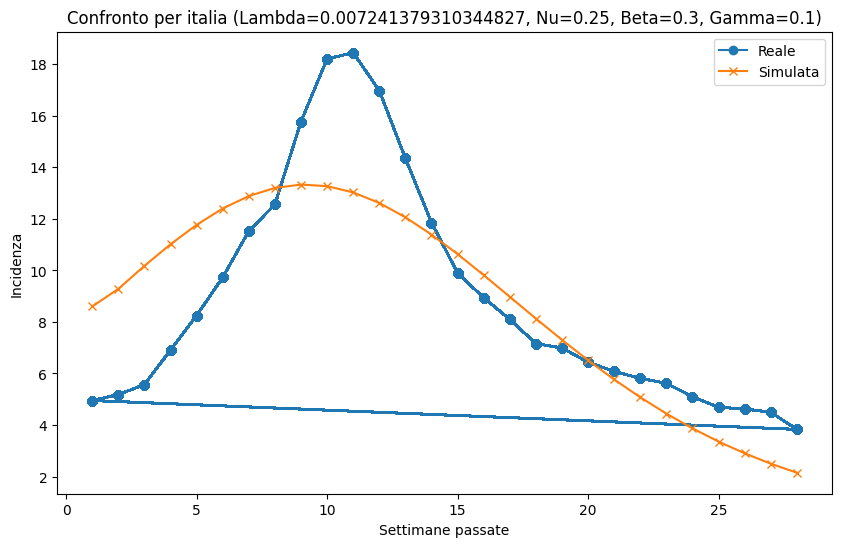

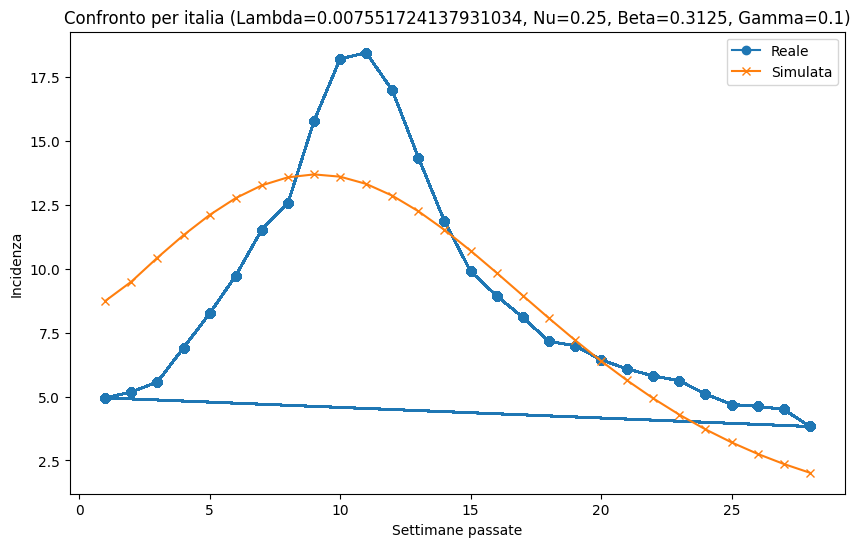

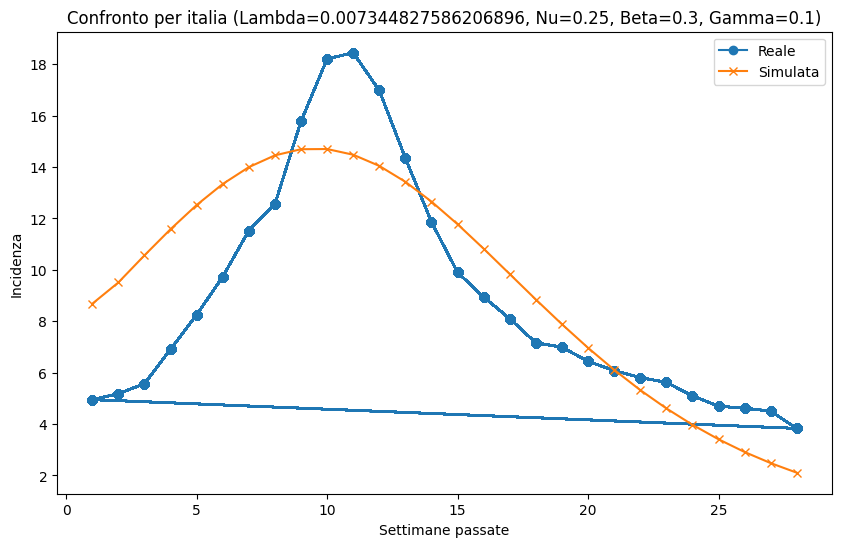

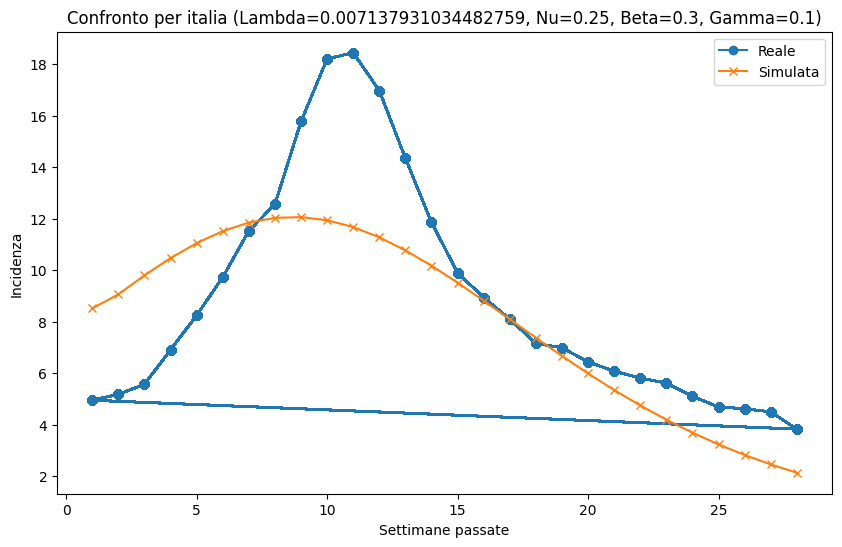

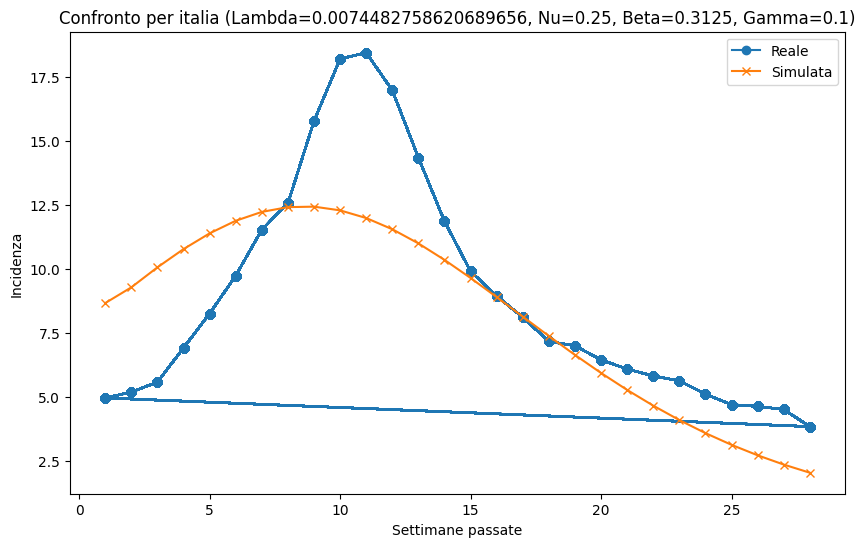

In [31]:

import matplotlib.pyplot as plt

for i, row in errori_ordinati.head(5).iterrows():
    lam, nu, beta, gamma = row['Lambda'], row['Nu'], row['Beta'], row['Gamma']
    
    df_simulazione = df_risultati_regionali[
        (df_risultati_regionali['Lambda'] == lam) & 
        (df_risultati_regionali['Nu'] == nu) & 
        (df_risultati_regionali['Beta'] == beta) & 
        (df_risultati_regionali['Gamma'] == gamma)
    ]
    
    for regione in df_confronto['regione'].unique():
        real_data = df_confronto[df_confronto['regione'] == regione]
        simulated_data = df_simulazione[df_simulazione['regione'] == regione]
        
        plt.figure(figsize=(10, 6))
        plt.plot(real_data['settimana_relativa'], real_data['incidenza_reale'], label='Reale', marker='o')
        plt.plot(simulated_data['settimana_relativa'], simulated_data['incidenza_simulata'], label='Simulata', marker='x')
        plt.title(f"Confronto per {regione} (Lambda={lam}, Nu={nu}, Beta={beta}, Gamma={gamma})")
        plt.xlabel("Settimane passate")
        plt.ylabel("Incidenza")
        plt.legend()
        plt.show()


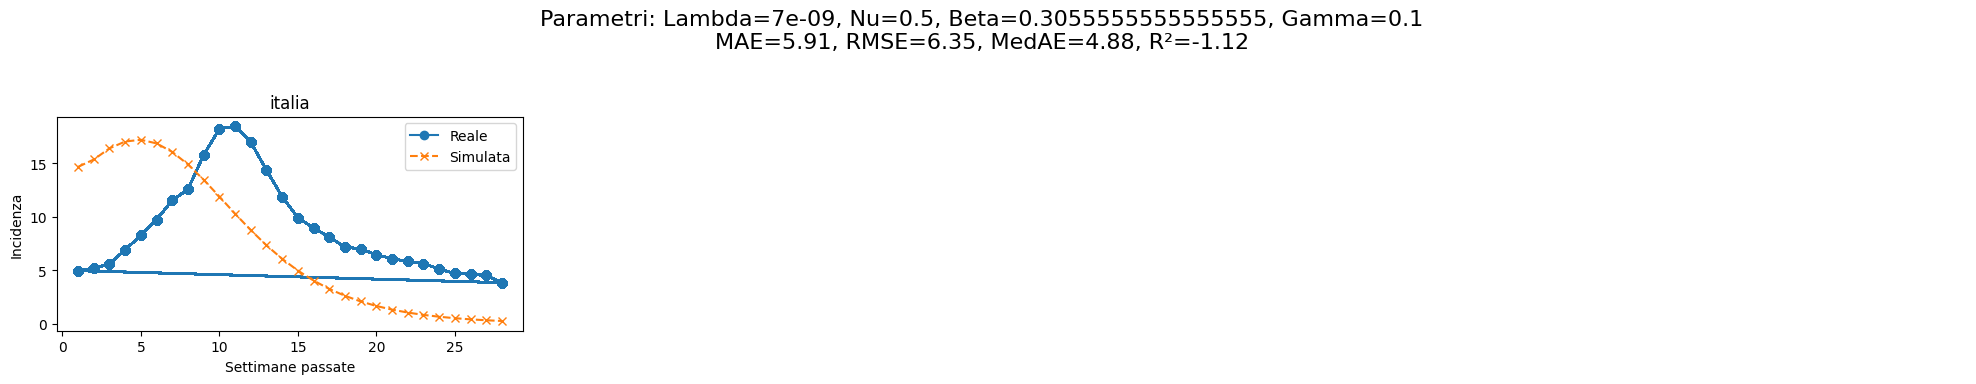

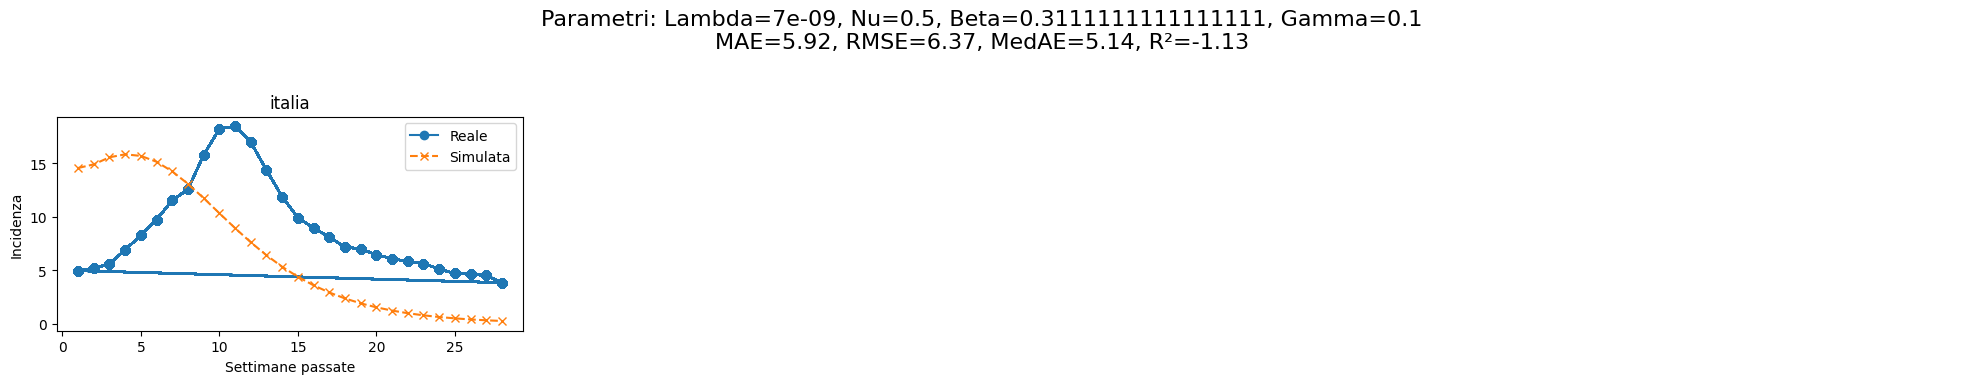

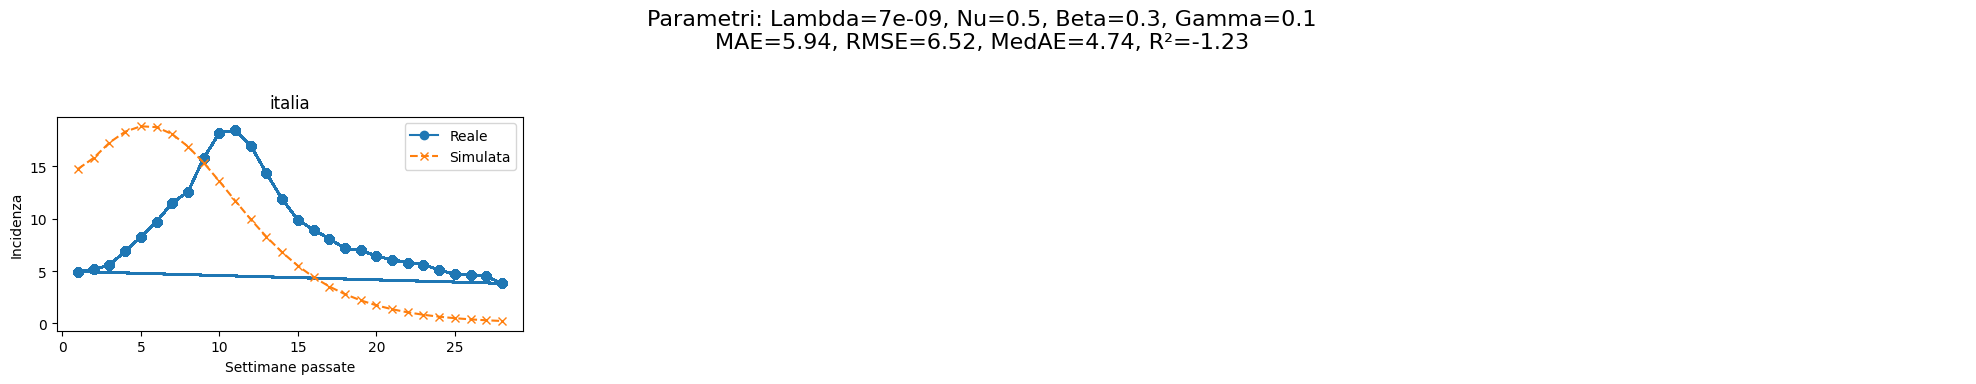

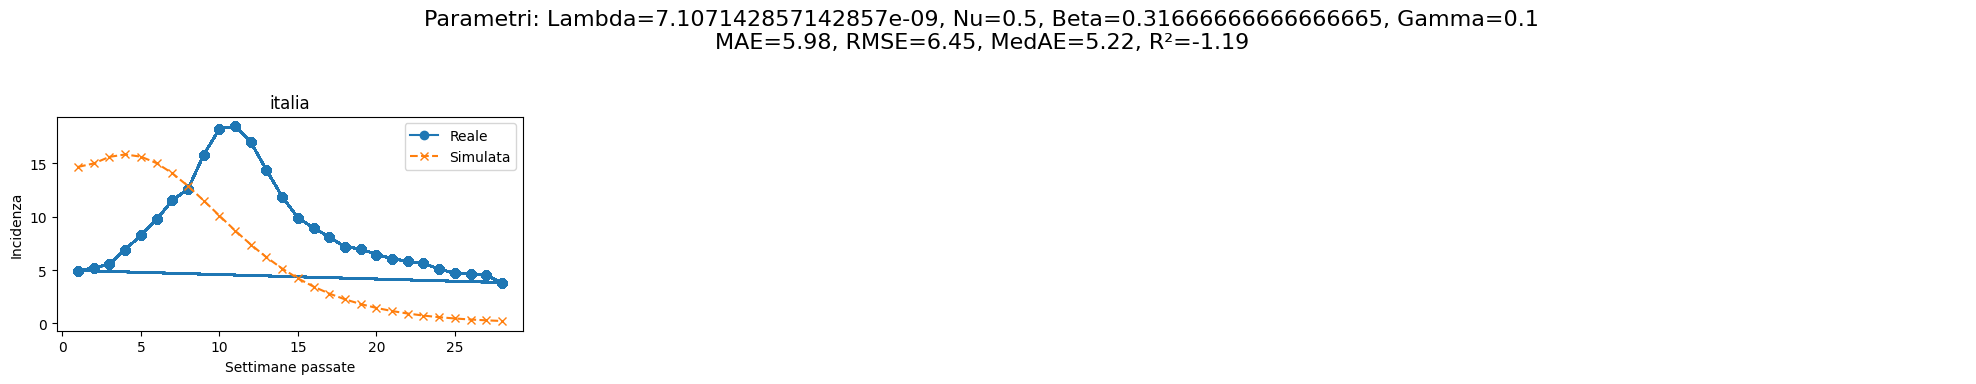

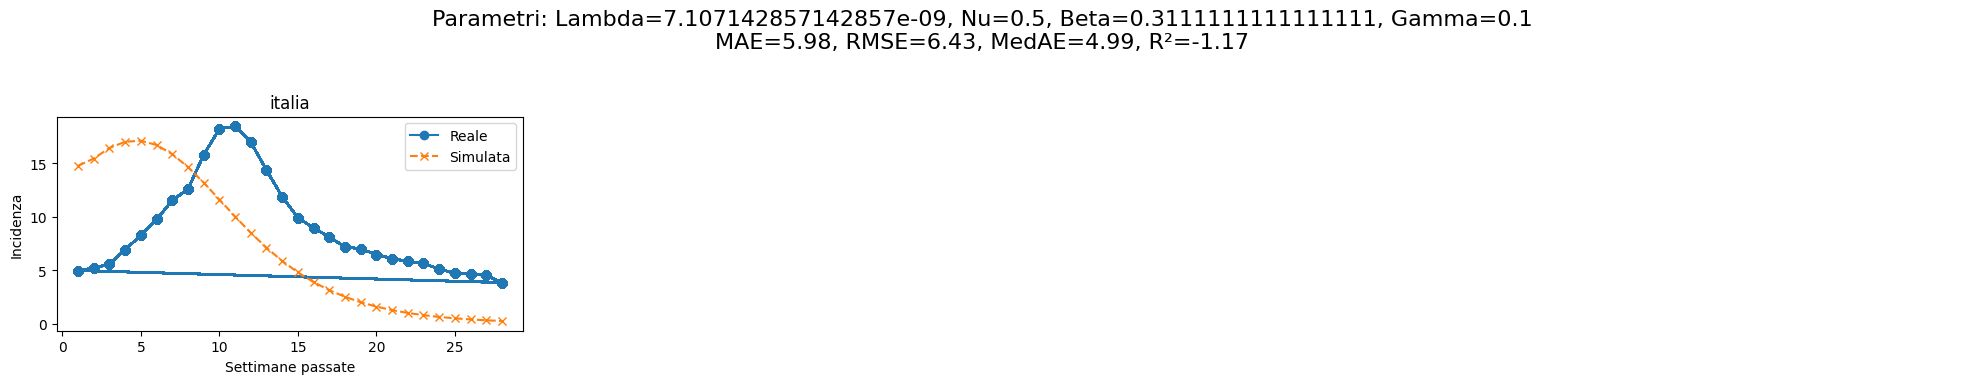

In [ ]:
import matplotlib.pyplot as plt

plots_per_row = 4  

for i, row in errori_ordinati.head(5).iterrows():
    lam, nu, beta, gamma = row['Lambda'], row['Nu'], row['Beta'], row['Gamma']
    mae, rmse, medae, r2 = row['MAE'], row['RMSE'], row['MedAE'], row['R2']
    # Filtra i dati simulati per questa combinazione
    df_simulazione = df_confronto[
        (df_confronto['Lambda'] == lam) & 
        (df_confronto['Nu'] == nu) & 
        (df_confronto['Beta'] == beta) & 
        (df_confronto['Gamma'] == gamma)
    ]
    
    unique_regions = df_confronto['regione'].unique()
    num_regions = len(unique_regions)
    rows = (num_regions + plots_per_row - 1) // plots_per_row  
    
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 5, rows * 4))
    
    axes = axes.flatten()  

    for idx, regione in enumerate(unique_regions):
        real_data = df_confronto[df_confronto['regione'] == regione]
        simulated_data = df_simulazione[df_simulazione['regione'] == regione]
        
        if real_data.empty or simulated_data.empty:
            continue
        
        ax = axes[idx]
        ax.plot(real_data['settimana_relativa'], real_data['incidenza_reale'], label='Reale', marker='o', linestyle='-')
        ax.plot(simulated_data['settimana_relativa'], simulated_data['incidenza_simulata'], label='Simulata', marker='x', linestyle='--')
        ax.set_title(f"{regione}")
        ax.set_xlabel("Settimane passate")
        ax.set_ylabel("Incidenza")
        ax.legend()
    
    for ax in axes[num_regions:]:
        ax.axis('off')
    
    fig.suptitle(f"Parametri: Lambda={lam}, Nu={nu}, Beta={beta}, Gamma={gamma}\n"
                 f"MAE={mae:.2f}, RMSE={rmse:.2f}, MedAE={medae:.2f}, R²={r2:.2f}", 
                 fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()


# OTTIMIZZAZIONE DI TIPO BAYESIANO

In [44]:
'''
stavolta stimeremo lambda, nu e beta utilizzando le markov chain monte carlo, e anziché effettuare un numero di simulazioni
pari al numero di combinazioni di parametri prefissato per tutto l'arco di tempo disponibile nei dati di addestramento,
stabiliremo delle distribuzioni a priori per i parametri e simuleremo per una sola settimana. A questo punto confronteremo
i risultati delle simulazioni con i dati reali per quella settimana, e aggiorneremo le distribuzioni dei parametri cercando di 
avvicinarci che aumentino la probabilità (likelyhood) di simulare qualcosa che si avvicina a quei dati reali

DA IMPLEMENTARE EVENTUALMENTE
trasformazione logaritmica dei parametri per rendere asimmetriche le distribuzioni e prevenire campioni minori di zero
'''

# associamo ogni codice a una regione e al suo numero di abitanti

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli venezia giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle d aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}
popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia romagna"]["abitanti"],
    "06": regioni_info["friuli venezia giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa bolzano"]["abitanti"],
    "13": regioni_info["pa trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle d aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  
}

region_name_to_code = {
    'Abruzzo': '01',
    'Basilicata': '02',
    'Calabria': '03',
    'Campania': '04',
    'Emilia-Romagna': '05',
    'Friuli-Venezia Giulia': '06',
    'Lazio': '07',
    'Liguria': '08',
    'Lombardia': '09',
    'Marche': '10',
    'Molise': '11',
    'pa_bolzano': '12',
    'Trentino-Alto Adige': '13',
    'Piemonte': '14',
    'Puglia': '15',
    'Sardegna': '16',
    'Sicilia': '17',
    'Toscana': '18',
    'Umbria': '19',
    "Valle d'Aosta": '20',
    'Veneto': '21',
    'Italia': 'IT'
}


import os
import pandas as pd



folder_path = 'C:\\Users\\celin\\OneDrive\\Desktop\\polito\\drive-download-20241207T142618Z-001\\codice tesi\\2023-2024'

import os
import pandas as pd

def carica_dati_reali(folder_path):
    dati_reali = []
    regione_files = {}
    incidenza_nazionale = {}

    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            base_name = file_name[:-4]
            region_name, year_week, _ = base_name.split('-')
            year, week = map(int, year_week.split('_'))
            
            # tiene solo il file più recente per ogni regione, a patto che sia nel formato corretto
            if region_name not in regione_files or (year, week) > regione_files[region_name]['year_week']:
                regione_files[region_name] = {
                    'file_path': os.path.join(folder_path, file_name),
                    'year_week': (year, week)
                }

    # leggiamo i dati nazionali
    if "italia" in regione_files:
        file_path = regione_files["italia"]["file_path"]
        df_nazionale = pd.read_csv(file_path)
        for _, row in df_nazionale.iterrows():
            week_key = f"{row['anno']}_W{int(row['settimana']):02d}"
            incidenza_nazionale[week_key] = row["incidenza"]

    
    for region_name, info in regione_files.items():
        file_path = info['file_path']
        df = pd.read_csv(file_path)
        
        # aggiungiamo per comodità una colonna col nome normalizzato della regione
        df["regione"] = region_name.lower().replace("_", " ").strip()
        dati_reali.append(df)

    
    df_dati_reali = pd.concat(dati_reali, ignore_index=True)

    
    region_name_mapping = {
        "provincia autonoma di bolzano": "pa_bolzano",
        "provincia autonoma di trento": "pa_trento",
        "valle d'aosta": "valle d aosta",
        "emilia-romagna": "emilia romagna"
    }
    df_dati_reali["regione"] = df_dati_reali["regione"].replace(region_name_mapping)

    # debug per trovare le regioni che non sono nella cartella
    regioni_presenti = df_dati_reali["regione"].unique()
    regioni_totali = [
        "abruzzo", "basilicata", "calabria", "campania", "emilia romagna", "friuli venezia giulia", "italia",
        "lazio", "liguria", "lombardia", "marche", "molise", "piemonte", "puglia", "sardegna",
        "sicilia", "toscana", "pa_bolzano", "pa_trento", "umbria", "valle d aosta", "veneto"
    ]
    regioni_mancanti = set(regioni_totali) - set(regioni_presenti)

    # se una regione non è nella cartella, usiamo l'incidenza IT
    dati_mancanti = []
    for regione in regioni_mancanti:
        print(f"[DEBUG] Regione mancante: {regione}. Utilizzo l'incidenza nazionale per approssimare i dati.")
        for week_key, incidenza in incidenza_nazionale.items():
            anno, settimana = week_key.split("_W")
            dati_mancanti.append({
                "anno": int(anno),
                "settimana": int(settimana),
                "incidenza": incidenza,
                "regione": regione
            })

    # aggiungiamo i dati approssimati
    df_dati_reali = pd.concat([df_dati_reali, pd.DataFrame(dati_mancanti)], ignore_index=True)

    # Debug
    print("Numero di righe totali nel DataFrame reale:", len(df_dati_reali))
    print("Regioni presenti:", df_dati_reali["regione"].unique())

    return df_dati_reali






prova = carica_dati_reali(folder_path)

# Calcolo della prevalenza giornaliera utilizzando beta
prova['prevalenza_giornaliera'] = prova['incidenza'] / (0.35 * 7) # sostituisci qui il valore di beta ottimale


dati_provinciali = []

for regione, gruppo_regionale in prova.groupby("regione"):
    if regione not in regioni_info:
        print(f"Attenzione: la regione '{regione}' non è presente in regioni_info. Salto questa regione.")
        continue

    info_regione = regioni_info[regione]
    pop_totale_regione = info_regione["abitanti"]
    province_della_regione = info_regione["province"]

    for _, riga in gruppo_regionale.iterrows():
        prevalenza_regionale = riga["prevalenza_giornaliera"]  # Prevalenza giornaliera regionale su 1000
        #giorno = riga["giorno"]

        numero_infetti_regione = prevalenza_regionale * pop_totale_regione / 1000

        for provincia, pop_provincia in province_della_regione.items():
            numero_infetti_provinciali = numero_infetti_regione * pop_provincia / pop_totale_regione  

            dati_provinciali.append({
                "anno": riga["anno"],
                "settimana": riga["settimana"],
                #"giorno": giorno,
                "provincia": provincia,
                "regione": regione,
                "numero_infetti": numero_infetti_provinciali
            })

df_dati_provinciali = pd.DataFrame(dati_provinciali)

df_dati_provinciali['Territorio'] = df_dati_provinciali['provincia']
df_dati_provinciali['CasiDistribuiti'] = df_dati_provinciali['numero_infetti']

# Debugging
print("Dati provinciali calcolati:")
print(df_dati_provinciali.head())




df_dati_provinciali.to_csv("debug2.csv")

def prepare_static_data():
    pop_df = pd.read_csv('Data\\FinalForCommuting\\pop.csv')
    province_classification_df = pd.read_csv('Data\\General\\ProvincieRegioneClassificazione.csv')
    flowMatrix = pd.read_csv('Data\\FinalForCommuting\\A_adj_province.csv', sep=";", index_col=0)

    pop_df['Territorio'] = pop_df['Territorio'].apply(normalizeNameProvince)
    popPROV = dict(zip(pop_df['Territorio'], pop_df['Value']))
    orderedPROV = pop_df['Territorio'].tolist()

    flowMatrix.index = flowMatrix.index.to_series().apply(normalizeNameProvince)
    flowMatrix.columns = flowMatrix.columns.to_series().apply(normalizeNameProvince)
    flowMatrix = flowMatrix.loc[orderedPROV, orderedPROV]
    Whk = flowMatrix.to_numpy()
    np.fill_diagonal(Whk, 0)  
    Whk = Whk / Whk.sum(1).reshape(-1, 1)  # Normalizzazione

    nh = np.array([popPROV[prov] for prov in orderedPROV])

    return nh, Whk, orderedPROV, popPROV


def get_initial_cases_for_week(df_dati_provinciali, anno_corrente, settimana_corrente, orderedPROV, nu=0.45):
    """
    Dato df_dati_provinciali con colonne: Territorio, anno, settimana, CasiDistribuiti
    Filtra i dati per anno_corrente e settimana_corrente, e calcola initial_case_i ed initial_case_e.
    """
    
    week_df = df_dati_provinciali[
        (df_dati_provinciali['anno'] == anno_corrente) & 
        (df_dati_provinciali['settimana'] == settimana_corrente)
    ].copy()

    if week_df.empty:
        print(f"Nessun dato per anno={anno_corrente}, settimana={settimana_corrente}. Utilizzo valori nulli.")
        week_df = pd.DataFrame({"Territorio": orderedPROV, "CasiDistribuiti":[0]*len(orderedPROV), 
                                "anno": anno_corrente, "settimana": settimana_corrente})
    
    week_df['Territorio'] = week_df['Territorio'].apply(normalizeNameProvince)
    flu_init_dict = dict(zip(week_df['Territorio'], week_df['CasiDistribuiti']))

    # se qualche provincia manca, inizializziamo a zero
    initial_case_i = np.array([flu_init_dict.get(prov, 0) for prov in orderedPROV])

    # Calcolo di E iniziale a partire da I iniziale. Supponendo E = I/nu (dove 1/nu è la durata media dell'incubazione in giorni),
    # se nu=0.22 significa che la durata media è ~4.54 giorni.
    initial_case_e = initial_case_i * (1 / nu)

    return initial_case_i, initial_case_e


# Esempio per debug

df_dati_provinciali = df_dati_provinciali.sort_values(by=['anno', 'settimana'])

nh, Whk, orderedPROV, popPROV = prepare_static_data()

# mettiamo ad esempio che vogliamo i dati per anno=2023, settimana=48
anno_corrente = 2023
settimana_corrente = 48
initial_case_i, initial_case_e = get_initial_cases_for_week(df_dati_provinciali, anno_corrente, settimana_corrente, orderedPROV, nu=0.22)

print("Initial cases (I):", initial_case_i)
print("Initial cases (E):", initial_case_e)


[DEBUG] Regione mancante: calabria. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: pa_trento. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: valle d aosta. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: pa_bolzano. Utilizzo l'incidenza nazionale per approssimare i dati.
Numero di righe totali nel DataFrame reale: 601
Regioni presenti: ['abruzzo' 'basilicata' 'campania' 'emilia romagna'
 'friuli venezia giulia' 'italia' 'lazio' 'liguria' 'lombardia' 'marche'
 'molise' 'pa bolzano' 'pa trento' 'piemonte' 'puglia' 'sardegna'
 'sicilia' 'toscana' 'umbria' 'veneto' 'calabria' 'pa_trento'
 'valle d aosta' 'pa_bolzano']
Attenzione: la regione 'italia' non è presente in regioni_info. Salto questa regione.
Attenzione: la regione 'pa_bolzano' non è presente in regioni_info. Salto questa regione.
Attenzione: la regione 'pa_trento' non è presente in regioni_info. Salto questa regione.
Dati prov

C:\Users\celin\AppData\Local\Temp\ipykernel_14400\3883163672.py:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dati_reali = pd.concat(dati_reali, ignore_index=True)


In [ ]:
import numpy as np
import pandas as pd
import emcee
from scipy.stats import norm
from datetime import datetime, timedelta, date

# bisogna aver già definito:
# parameters(nh, Whk)
# initialStatesMemory(p, initial_case_i, initial_case_e, start_date_str, initialN, initialR)
# oneStep((S, E, I, N, R), p)
# get_initial_cases_for_week(...) - per ricavare I e E da dati provinciali e utilizzarli per fare 1 settimana di simulazione
# df_nazionali: DataFrame con colonne [anno, settimana, incidenza], incidenza = nuovi casi/1000 persone
# df_dati_provinciali: DataFrame per data assimilation, ovvero per "correggere" i dati simulati con quelli reali per la nuova settimana

def simulate_one_week(lam, nu, beta, gamma, p, S, E, I, N, R, days=7):
    p.Lambda = np.array([lam, lam*1.3, lam*1.2])
    p.Nu = nu
    p.Beta = beta
    p.Gamma = gamma

    weekly_new_infections = 0
    for _ in range(days):
        simulated_exposed = E.sum(axis=0)
        daily_new_infected = simulated_exposed * nu
        weekly_new_infections += daily_new_infected.sum()
        try:
            S, E, I, N, R = oneStepCorretto((S, E, I, N, R), p)
            #S, E, I, N, R = oneStep((S, E, I, N, R), p)
        except AssertionError:
            # Se la popolazione non si conserva arrestiamo tutto
            return None, None, None, None, None, -1

    return S, E, I, N, R, weekly_new_infections

def log_prior(theta, prior_info):
    lam, nu, beta = theta
    # usiamo delle prior semplici ma leggermente informative
    if 4e-3 < lam < 1.5e-2 and 0.2 < nu < 0.7 and 0.1 < beta < 0.6:
        return 0.0
    return -np.inf

def log_likelihood(theta, data_osservata_per_1000, S, E, I, N, R, p, gamma_fixed=0.1, nh=None):
    lam, nu, beta = theta
    S_f, E_f, I_f, N_f, R_f, weekly_infections = simulate_one_week(lam, nu, beta, gamma_fixed, p, S.copy(), E.copy(), I.copy(), N.copy(), R.copy())
    if weekly_infections == -1:
        return -np.inf
    if (S_f is None) or (E_f is None):
        return -np.inf

    if (S_f<0).any() or (E_f<0).any() or (I_f<0).any() or (N_f<0).any() or (R_f<0).any():
        return -np.inf

    total_pop = nh.sum()
    incidenza_simulata_per_1000 = (weekly_infections / total_pop) * 1000

    sigma = 5.0
    ll = norm.logpdf(data_osservata_per_1000, loc=incidenza_simulata_per_1000, scale=sigma)
    return ll

def log_posterior(theta, data_osservata_per_1000, S, E, I, N, R, p, prior_info, gamma_fixed=0.1, nh=None):
    lp = log_prior(theta, prior_info)
    if np.isinf(lp):
        return -np.inf
    ll = log_likelihood(theta, data_osservata_per_1000, S, E, I, N, R, p, gamma_fixed=gamma_fixed, nh=nh)
    return lp + ll

# ===================== OTTIMIZZAZIONE BAYESIANA =====================

# carichiamo i dati che rimarranno costanti per tutta la calibrazione
pop_df = pd.read_csv('Data/FinalForCommuting/pop.csv')
pop_df['Territorio'] = pop_df['Territorio'].apply(lambda x: x.lower().replace(" ", ""))
orderedPROV = pop_df['Territorio'].tolist()
popPROV = dict(zip(pop_df['Territorio'], pop_df['Value']))
nh = np.array([popPROV[prov] for prov in orderedPROV])

Whk = pd.read_csv('Data/FinalForCommuting/A_adj_province.csv', sep=";", index_col=0)
Whk.index = Whk.index.to_series().apply(lambda x: x.lower().replace(" ", ""))
Whk.columns = Whk.columns.to_series().apply(lambda x: x.lower().replace(" ", ""))
Whk = Whk.loc[orderedPROV, orderedPROV].to_numpy()
np.fill_diagonal(Whk, 0)
Whk = Whk / Whk.sum(1).reshape(-1,1)

#df_nazionali = pd.read_csv("path_to_national_data.csv") 
df_nazionali = prova[prova["regione"] == 'italia']
df_nazionali = df_nazionali[["anno", "settimana", "incidenza"]]
# df_nazionali: colonne: anno, settimana, incidenza (nuovi casi per 1000 persone)
df_nazionali = df_nazionali.sort_values(["anno","settimana"])

p = parameters(nh, Whk)
p.Gamma = 0.1  # fissiamo gamma


anno_iniziale, settimana_iniziale = df_nazionali[['anno','settimana']].values[0]
first_date = date.fromisocalendar(anno_iniziale, settimana_iniziale, 1)
first_date_str = first_date.strftime("%d-%m-%Y")
start_date = datetime.strptime(first_date_str, "%d-%m-%Y")



initial_case_i, initial_case_e = get_initial_cases_for_week(df_dati_provinciali, anno_iniziale, settimana_iniziale, orderedPROV, nu=0.22)
initialN=0; initialR=0
S, E, I, N, R, current_date = initialStatesMemory(p, initial_case_i, initial_case_e, first_date_str, initialN, initialR)

previous_posterior_samples = None
gamma_fixed = 0.1
sequenza_settimanale = df_nazionali[['anno','settimana']].values
num_settimane = len(sequenza_settimanale)

#queste liste verranno usate per salvare media e intervalli di confidenza per i parametri
lam_means, nu_means, beta_means = [], [], []
lam_lower, lam_upper = [], []
nu_lower, nu_upper = [], []
beta_lower, beta_upper = [], []

# definiamo liste per salvare incidenza simulata e reale
real_incidence = []  # Incidenza reale per 1000 persone (dai dati)
simulated_means = []  # Media dell'incidenza simulata per 1000 persone
simulated_lower = []  # Limite inferiore del 95% CI
simulated_upper = []  # Limite superiore del 95% CI


for week_index in range(num_settimane):
    anno_corrente, settimana_corrente = sequenza_settimanale[week_index]
    data_osservata_per_1000 = df_nazionali[
        (df_nazionali['anno'] == anno_corrente) & 
        (df_nazionali['settimana'] == settimana_corrente)
    ]['incidenza'].values[0]

    # debug prima di MCMC
    print(f"--- Settimana {week_index+1} ---")
    print(f"Anno: {anno_corrente}, Settimana: {settimana_corrente}")
    print("Data simulazione attuale:", current_date.strftime('%d-%m-%Y'))
    print("Stati iniziali della settimana:",
          "S:", S.sum(), "E:", E.sum(), "I:", I.sum(), "N:", N.sum(), "R:", R.sum())
    print(f"Incidenza reale per 1000 persone: {data_osservata_per_1000}")

    # definiamo la prior
    if previous_posterior_samples is None:
        prior_info = {"type":"weak"}
    else:
        lam_mean = np.mean(previous_posterior_samples[:,0])
        lam_std = np.std(previous_posterior_samples[:,0]) or 0.1
        nu_mean = np.mean(previous_posterior_samples[:,1])
        nu_std = np.std(previous_posterior_samples[:,1]) or 0.1
        beta_mean = np.mean(previous_posterior_samples[:,2])
        beta_std = np.std(previous_posterior_samples[:,2]) or 0.1
        prior_info = {
            "type":"normal",
            "lam_mean": lam_mean, "lam_std": lam_std,
            "nu_mean": nu_mean, "nu_std": nu_std,
            "beta_mean": beta_mean, "beta_std": beta_std
        }

    def logpost_fn(theta):
        return log_posterior(theta, data_osservata_per_1000, S, E, I, N, R, p, prior_info, gamma_fixed=gamma_fixed, nh=nh)

    n_walkers = 40
    initial_guess = [7e-3, 0.3, 0.3]
    p0 = [initial_guess + 0.5e-3*np.random.randn(3) for i in range(n_walkers)]

    sampler = emcee.EnsembleSampler(n_walkers, 3, logpost_fn)
    state = sampler.run_mcmc(p0, 400, progress=True)  # quante iterazioni di burn-in?
    sampler.reset()
    sampler.run_mcmc(state, 1000, progress=True)  # catena principale, quante iterazioni?
    samples = sampler.get_chain(flat=True)
    previous_posterior_samples = samples

    lam_val = np.mean(samples[:,0])
    nu_val = np.mean(samples[:,1])
    beta_val = np.mean(samples[:,2])

    # Calcoliamo medie e intervalli di confidenza
    lam_samples = samples[:, 0]
    nu_samples = samples[:, 1]
    beta_samples = samples[:, 2]

    lam_means.append(np.mean(lam_samples))
    lam_lower.append(np.percentile(lam_samples, 2.5))
    lam_upper.append(np.percentile(lam_samples, 97.5))

    nu_means.append(np.mean(nu_samples))
    nu_lower.append(np.percentile(nu_samples, 2.5))
    nu_upper.append(np.percentile(nu_samples, 97.5))

    beta_means.append(np.mean(beta_samples))
    beta_lower.append(np.percentile(beta_samples, 2.5))
    beta_upper.append(np.percentile(beta_samples, 97.5))

    print("Parametri medi dopo MCMC:",
          f"lambda={lam_means[-1]:.2e}, nu={nu_means[-1]:.3f}, beta={beta_means[-1]:.3f}")

    # adesso, proviamo a fare una simulazione coi parametri medi trovati fra tutte le iterazioni
    S, E, I, N, R, weekly_infections = simulate_one_week(lam_val, nu_val, beta_val, gamma_fixed, p, S, E, I, N, R, days=7)
    print("Dopo simulazione settimana:")
    if weekly_infections == -1:
        print("Parametri medi portano a popolazione non conservata, -inf likelihood")
    else:
        print("Weekly infections:", weekly_infections)
    print("Stati finali settimana:",
          "S:", S.sum(), "E:", E.sum(), "I:", I.sum(), "N:", N.sum(), "R:", R.sum())

    # calcoliamo la likelyhood di alcune combinazioni di parametri rispetto ai dati reali. Questo serve ad avere una idea di quanto
    # sia realistica la distribuzione di parametri che abbiamo ottenuto. Una LL molto negativa e prossima a -inf indica che la 
    # distribuzione attuale di parametri non riesce a simulare bene i dati reali
    test_params = [
        (lam_val*0.8, nu_val, beta_val),
        (lam_val*1.2, nu_val, beta_val),
        (lam_val, nu_val*1.1, beta_val),
        (lam_val, nu_val, beta_val*0.9)
    ]
    for (lt, nt, bt) in test_params:
        ll = log_likelihood((lt, nt, bt), data_osservata_per_1000, S, E, I, N, R, p, gamma_fixed=gamma_fixed, nh=nh)
        print(f"Parametri test: lam={lt}, nu={nt}, beta={bt}, LL={ll}")

    # incidenza reale
    real_incidence.append(data_osservata_per_1000)

    # simuliamo ora con parametri campionati dalla posterior
    incidenza_simulata_settimanale = []  # Lista temporanea per questa settimana
    for theta in samples[np.random.choice(len(samples), 300)]:  # 300 campioni casuali
        lam, nu, beta = theta
        S_f, E_f, I_f, N_f, R_f, weekly_infections = simulate_one_week(
            lam, nu, beta, gamma_fixed, p, S.copy(), E.copy(), I.copy(), N.copy(), R.copy()
        )
        if weekly_infections != -1:  # solo se la simulazione è valida salviamo i dati ottenuti
            incidenza_per_1000 = (weekly_infections / nh.sum()) * 1000
            incidenza_simulata_settimanale.append(incidenza_per_1000)

    # calcola media e intervalli di confidenza per l'incidenza simulata
    if incidenza_simulata_settimanale:
        simulated_means.append(np.mean(incidenza_simulata_settimanale))
        simulated_lower.append(np.percentile(incidenza_simulata_settimanale, 2.5))
        simulated_upper.append(np.percentile(incidenza_simulata_settimanale, 97.5))
    else:
        simulated_means.append(None)
        simulated_lower.append(None)
        simulated_upper.append(None)


    # ora aggiorniamo E e I secondo i dati reali in preparazione per la prossima settimana di simulazione
    new_i, new_e = get_initial_cases_for_week(df_dati_provinciali, anno_corrente, settimana_corrente, orderedPROV, nu=nu_val)
    eta = p.eta
    E = eta.reshape(-1,1)*new_e
    I = eta.reshape(-1,1)*new_i
    total_pop = eta.reshape(-1,1)*nh.reshape(1,-1)
    S = total_pop - E - I - N - R
    print("Dopo data assimilation:",
          "S:", S.sum(), "E:", E.sum(), "I:", I.sum(), "N:", N.sum(), "R:", R.sum())

    
    current_date += timedelta(days=7)

print("Stima sequenziale completata.")


--- Settimana 1 ---
Anno: 2023, Settimana: 42
Data simulazione attuale: 16-10-2023
Stati iniziali della settimana: S: 59372264.724857144 E: 17985.471428571433 I: 3956.8037142857147 N: 0.0 R: 0.0
Incidenza reale per 1000 persone: 4.95


100%|██████████| 1000/1000 [01:57<00:00,  8.48it/s]


Parametri medi dopo MCMC: lambda=1.21e-02, nu=0.615, beta=0.446
Dopo simulazione settimana:
Weekly infections: 53802.971283258805
Stati finali settimana: S: 59322242.1969703 E: 14205.028032151287 I: 17365.201868924407 N: 31556.346541323554 R: 8838.226587296562
Parametri test: lam=0.009679263073001182, nu=0.6146603206802834, beta=0.44578182901932595, LL=-2.847978774496015
Parametri test: lam=0.01451889460950177, nu=0.6146603206802834, beta=0.44578182901932595, LL=-2.764270973448383
Parametri test: lam=0.012099078841251476, nu=0.6761263527483118, beta=0.44578182901932595, LL=-2.797230081196351
Parametri test: lam=0.012099078841251476, nu=0.6146603206802834, beta=0.40120364611739334, LL=-2.7964761285452404
Dopo data assimilation: S: 59343418.24045781 E: 6437.382699287422 I: 3956.8037142857147 N: 31556.346541323554 R: 8838.226587296562
--- Settimana 2 ---
Anno: 2023, Settimana: 43
Data simulazione attuale: 23-10-2023
Stati iniziali della settimana: S: 59343418.24045781 E: 6437.382699287422

100%|██████████| 1000/1000 [00:24<00:00, 41.62it/s]


Parametri medi dopo MCMC: lambda=1.18e-02, nu=0.599, beta=0.437
Dopo simulazione settimana:
Weekly infections: 23708.82460144462
Stati finali settimana: S: 59319528.156943105 E: 6618.641612546811 I: 8098.58261387628 N: 30150.43083927482 R: 29811.187991199346
Parametri test: lam=0.009418540508648217, nu=0.599337143052574, beta=0.4367790821953696, LL=-2.979303770665223
Parametri test: lam=0.014127810762972322, nu=0.599337143052574, beta=0.4367790821953696, LL=-2.9330613028086416
Parametri test: lam=0.01177317563581027, nu=0.6592708573578314, beta=0.4367790821953696, LL=-2.9516929465649833
Parametri test: lam=0.01177317563581027, nu=0.599337143052574, beta=0.39310117397583266, LL=-2.951424831507902
Dopo data assimilation: S: 59323196.00147614 E: 6908.724493380483 I: 4140.655199999999 N: 30150.43083927482 R: 29811.187991199346
--- Settimana 3 ---
Anno: 2023, Settimana: 44
Data simulazione attuale: 30-10-2023
Stati iniziali della settimana: S: 59323196.00147614 E: 6908.724493380483 I: 4140.

100%|██████████| 1000/1000 [00:24<00:00, 40.19it/s]


Parametri medi dopo MCMC: lambda=1.24e-02, nu=0.627, beta=0.459
Dopo simulazione settimana:
Weekly infections: 26509.195002192013
Stati finali settimana: S: 59296465.06489725 E: 7130.46607009255 I: 8696.15107245449 N: 31324.498568661846 R: 50590.819391549856
Parametri test: lam=0.009954974520425007, nu=0.6268125670729784, beta=0.4590195733710587, LL=-3.0454780045946723
Parametri test: lam=0.014932461780637507, nu=0.6268125670729784, beta=0.4590195733710587, LL=-2.987429587264427
Parametri test: lam=0.012443718150531257, nu=0.6894938237802762, beta=0.4590195733710587, LL=-3.011145580816187
Parametri test: lam=0.012443718150531257, nu=0.6268125670729784, beta=0.41311761603395286, LL=-3.0103578860901896
Dopo data assimilation: S: 59300736.033447504 E: 7103.245220847955 I: 4452.4033714285715 N: 31324.498568661846 R: 50590.819391549856
--- Settimana 4 ---
Anno: 2023, Settimana: 45
Data simulazione attuale: 06-11-2023
Stati iniziali della settimana: S: 59300736.033447504 E: 7103.245220847955

100%|██████████| 1000/1000 [00:23<00:00, 42.02it/s]


Parametri medi dopo MCMC: lambda=1.22e-02, nu=0.606, beta=0.449
Dopo simulazione settimana:
Weekly infections: 26611.861496880945
Stati finali settimana: S: 59273906.641158015 E: 7320.7760134682585 I: 8874.17573418393 N: 32037.963885457382 R: 72067.44320887991
Parametri test: lam=0.009750633541569723, nu=0.6063288546702461, beta=0.4485747229094588, LL=-3.3551483301956595
Parametri test: lam=0.014625950312354584, nu=0.6063288546702461, beta=0.4485747229094588, LL=-3.284297341979905
Parametri test: lam=0.012188291926962153, nu=0.6669617401372707, beta=0.4485747229094588, LL=-3.3130470065133775
Parametri test: lam=0.012188291926962153, nu=0.6063288546702461, beta=0.40371725061851294, LL=-3.3124112699098207
Dopo data assimilation: S: 58917499.786037475 E: 231958.60908859616 I: 140643.19777959186 N: 32037.963885457382 R: 72067.44320887991
--- Settimana 5 ---
Anno: 2023, Settimana: 46
Data simulazione attuale: 13-11-2023
Stati iniziali della settimana: S: 58917499.786037475 E: 231958.6090885

100%|██████████| 1000/1000 [00:50<00:00, 19.73it/s]


Parametri medi dopo MCMC: lambda=9.64e-03, nu=0.525, beta=0.493
Dopo simulazione settimana:
Weekly infections: 635869.0501017814
Stati finali settimana: S: 58364229.704716675 E: 149359.64030762098 I: 167550.62363346483 N: 470571.7054877875 R: 242495.32585445838
Parametri test: lam=0.007713271181051505, nu=0.5248956424584986, beta=0.4928953913568442, LL=-2.558553168749543
Parametri test: lam=0.011569906771577257, nu=0.5248956424584986, beta=0.4928953913568442, LL=-2.606877514376271
Parametri test: lam=0.009641588976314381, nu=0.5773852067043486, beta=0.4928953913568442, LL=-2.538432579041153
Parametri test: lam=0.009641588976314381, nu=0.5248956424584986, beta=0.4436058522211598, LL=-2.540227996496173
Dopo data assimilation: S: 58165528.77210073 E: 338128.8412141657 I: 177482.3553428572 N: 470571.7054877875 R: 242495.32585445838
--- Settimana 6 ---
Anno: 2023, Settimana: 47
Data simulazione attuale: 20-11-2023
Stati iniziali della settimana: S: 58165528.77210073 E: 338128.8412141657 I: 

100%|██████████| 1000/1000 [01:54<00:00,  8.74it/s]


Parametri medi dopo MCMC: lambda=8.95e-03, nu=0.501, beta=0.529
Dopo simulazione settimana:
Weekly infections: 787025.1807343604
Stati finali settimana: S: 57554014.80651336 E: 162617.62606717486 I: 174712.14337864876 N: 808262.4082451665 R: 694600.0157956482
Parametri test: lam=0.007159385188233005, nu=0.5006529636040241, beta=0.5289133285487531, LL=-2.717567794360449
Parametri test: lam=0.010739077782349506, nu=0.5006529636040241, beta=0.5289133285487531, LL=-2.531245264810745
Parametri test: lam=0.008949231485291255, nu=0.5507182599644266, beta=0.5289133285487531, LL=-2.5694741503055227
Parametri test: lam=0.008949231485291255, nu=0.5006529636040241, beta=0.47602199569387776, LL=-2.5654132424976903
Dopo data assimilation: S: 57250165.968701765 E: 427266.41189415293 I: 213912.19536326535 N: 808262.4082451665 R: 694600.0157956482
--- Settimana 7 ---
Anno: 2023, Settimana: 48
Data simulazione attuale: 27-11-2023
Stati iniziali della settimana: S: 57250165.968701765 E: 427266.4118941529

100%|██████████| 1000/1000 [00:52<00:00, 19.07it/s]


Parametri medi dopo MCMC: lambda=8.50e-03, nu=0.474, beta=0.522
Dopo simulazione settimana:
Weekly infections: 918863.4604898873
Stati finali settimana: S: 56567404.11997013 E: 191164.80013590786 I: 201688.31480813073 N: 1072483.8742374969 R: 1361465.89084834
Parametri test: lam=0.0068009746853911176, nu=0.4737681941224224, beta=0.5215829008920401, LL=-2.8890815921288797
Parametri test: lam=0.010201462028086675, nu=0.4737681941224224, beta=0.5215829008920401, LL=-2.574784905874175
Parametri test: lam=0.008501218356738897, nu=0.5211450135346647, beta=0.5215829008920401, LL=-2.659558969853525
Parametri test: lam=0.008501218356738897, nu=0.4737681941224224, beta=0.4694246108028361, LL=-2.6542858994944534
Dopo data assimilation: S: 56191971.00085526 E: 521307.3786793129 I: 246978.85537959184 N: 1072483.8742374969 R: 1361465.89084834
--- Settimana 8 ---
Anno: 2023, Settimana: 49
Data simulazione attuale: 04-12-2023
Stati iniziali della settimana: S: 56191971.00085526 E: 521307.3786793129 I:

100%|██████████| 1000/1000 [00:23<00:00, 42.07it/s]


Parametri medi dopo MCMC: lambda=8.09e-03, nu=0.472, beta=0.541
Dopo simulazione settimana:
Weekly infections: 1042590.6404154593
Stati finali settimana: S: 55476927.89685552 E: 193759.84226359733 I: 205466.2114217825 N: 1305349.2258404745 R: 2212703.8236186313
Parametri test: lam=0.006470494700998447, nu=0.4718138804506274, beta=0.5407834899039234, LL=-3.1600363113868637
Parametri test: lam=0.00970574205149767, nu=0.4718138804506274, beta=0.5407834899039234, LL=-2.7320821541582188
Parametri test: lam=0.008088118376248059, nu=0.5189952684956902, beta=0.5407834899039234, LL=-2.867586372757974
Parametri test: lam=0.008088118376248059, nu=0.4718138804506274, beta=0.4867051409135311, LL=-2.856785047198091
Dopo data assimilation: S: 55055182.956984654 E: 557795.3873521563 I: 263175.6062040817 N: 1305349.2258404745 R: 2212703.8236186313
--- Settimana 9 ---
Anno: 2023, Settimana: 50
Data simulazione attuale: 11-12-2023
Stati iniziali della settimana: S: 55055182.956984654 E: 557795.3873521563

100%|██████████| 1000/1000 [00:24<00:00, 41.33it/s]


Parametri medi dopo MCMC: lambda=8.42e-03, nu=0.473, beta=0.510
Dopo simulazione settimana:
Weekly infections: 1154270.0155697942
Stati finali settimana: S: 54226747.44523266 E: 231960.88353436525 I: 254021.59846919685 N: 1481644.8356717587 R: 3199832.2370920265
Parametri test: lam=0.0067327729232420745, nu=0.47330092663531287, beta=0.510280179046635, LL=-3.5278774368148516
Parametri test: lam=0.01009915938486311, nu=0.47330092663531287, beta=0.510280179046635, LL=-2.830297718124909
Parametri test: lam=0.008415966154052592, nu=0.5206310192988441, beta=0.510280179046635, LL=-3.0484864481920586
Parametri test: lam=0.008415966154052592, nu=0.47330092663531287, beta=0.45925216114197154, LL=-3.035963614813031
Dopo data assimilation: S: 53477456.19510205 E: 838439.5270525232 I: 396834.20508163265 N: 1481644.8356717587 R: 3199832.2370920265
--- Settimana 10 ---
Anno: 2023, Settimana: 51
Data simulazione attuale: 18-12-2023
Stati iniziali della settimana: S: 53477456.19510205 E: 838439.5270525

100%|██████████| 1000/1000 [00:25<00:00, 39.42it/s]


Parametri medi dopo MCMC: lambda=7.25e-03, nu=0.428, beta=0.557
Dopo simulazione settimana:
Weekly infections: 1453904.7956729222
Stati finali settimana: S: 52607599.73410167 E: 254391.19237999554 I: 253953.40390875007 N: 1860618.2187338104 R: 4417644.450875781
Parametri test: lam=0.005801266709286158, nu=0.42821919833715594, beta=0.5567326195221781, LL=-4.714352846432642
Parametri test: lam=0.008701900063929235, nu=0.42821919833715594, beta=0.5567326195221781, LL=-3.890597485132151
Parametri test: lam=0.007251583386607697, nu=0.4710411181708716, beta=0.5567326195221781, LL=-4.164551225185183
Parametri test: lam=0.007251583386607697, nu=0.42821919833715594, beta=0.5010593575699603, LL=-4.152128663202929
Dopo data assimilation: S: 51646741.17881407 E: 1028695.8425477706 I: 440507.3090285715 N: 1860618.2187338104 R: 4417644.450875781
--- Settimana 11 ---
Anno: 2023, Settimana: 52
Data simulazione attuale: 25-12-2023
Stati iniziali della settimana: S: 51646741.17881407 E: 1028695.84254777

100%|██████████| 1000/1000 [00:30<00:00, 33.23it/s]


Parametri medi dopo MCMC: lambda=6.70e-03, nu=0.374, beta=0.561
Dopo simulazione settimana:
Weekly infections: 1567742.20692194
Stati finali settimana: S: 50806795.002099216 E: 300899.8123406846 I: 265052.0499282742 N: 2144424.8561157724 R: 5877035.279516056
Parametri test: lam=0.00535642102906695, nu=0.37377985121505825, beta=0.5614318181104255, LL=-4.720573404095583
Parametri test: lam=0.008034631543600424, nu=0.37377985121505825, beta=0.5614318181104255, LL=-4.018384316907285
Parametri test: lam=0.006695526286333687, nu=0.4111578363365641, beta=0.5614318181104255, LL=-4.22641813504683
Parametri test: lam=0.006695526286333687, nu=0.37377985121505825, beta=0.505288636299383, LL=-4.241858813357762
Dopo data assimilation: S: 49756940.31300372 E: 1176175.7532950635 I: 439630.79806938785 N: 2144424.8561157724 R: 5877035.279516056
--- Settimana 12 ---
Anno: 2024, Settimana: 1
Data simulazione attuale: 01-01-2024
Stati iniziali della settimana: S: 49756940.31300372 E: 1176175.7532950635 I: 

100%|██████████| 1000/1000 [00:25<00:00, 39.56it/s]


Parametri medi dopo MCMC: lambda=6.29e-03, nu=0.321, beta=0.582
Dopo simulazione settimana:
Weekly infections: 1572468.564902399
Stati finali settimana: S: 49015665.04821849 E: 344982.45317789156 I: 252354.61081814585 N: 2289773.8593259333 R: 7491431.028459536
Parametri test: lam=0.005033402438043462, nu=0.32098948308474706, beta=0.5816017695280755, LL=-4.173610218798383
Parametri test: lam=0.007550103657065193, nu=0.32098948308474706, beta=0.5816017695280755, LL=-3.699341882471481
Parametri test: lam=0.006291753047554327, nu=0.3530884313932218, beta=0.5816017695280755, LL=-3.8097416953939742
Parametri test: lam=0.006291753047554327, nu=0.32098948308474706, beta=0.523441592575268, LL=-3.849093076936776
Dopo data assimilation: S: 47946750.782703355 E: 1261366.0826581167 I: 404885.24685306125 N: 2289773.8593259333 R: 7491431.028459536
--- Settimana 13 ---
Anno: 2024, Settimana: 2
Data simulazione attuale: 08-01-2024
Stati iniziali della settimana: S: 47946750.782703355 E: 1261366.0826581

100%|██████████| 1000/1000 [00:25<00:00, 38.72it/s]


Parametri medi dopo MCMC: lambda=6.01e-03, nu=0.278, beta=0.581
Dopo simulazione settimana:
Weekly infections: 1513222.714554963
Stati finali settimana: S: 47297916.34841753 E: 396977.80238897377 I: 249088.30429330203 N: 2299257.762105994 R: 9150966.782794198
Parametri test: lam=0.004808109946057094, nu=0.2782770341832976, beta=0.5807258524478609, LL=-3.3004010116655627
Parametri test: lam=0.00721216491908564, nu=0.2782770341832976, beta=0.5807258524478609, LL=-3.0340916833745872
Parametri test: lam=0.006010137432571367, nu=0.3061047376016274, beta=0.5807258524478609, LL=-3.0739663601897638
Parametri test: lam=0.006010137432571367, nu=0.2782770341832976, beta=0.5226532672030748, LL=-3.116956763052266
Dopo data assimilation: S: 46365739.28610784 E: 1234664.416857278 I: 343578.7521346939 N: 2299257.762105994 R: 9150966.782794198
--- Settimana 14 ---
Anno: 2024, Settimana: 3
Data simulazione attuale: 15-01-2024
Stati iniziali della settimana: S: 46365739.28610784 E: 1234664.416857278 I: 3

100%|██████████| 1000/1000 [02:34<00:00,  6.48it/s]


Parametri medi dopo MCMC: lambda=6.11e-03, nu=0.263, beta=0.572
Dopo simulazione settimana:
Weekly infections: 1418527.92008836
Stati finali settimana: S: 45776258.16040342 E: 405617.6224733366 I: 242014.55313384498 N: 2203851.5914009362 R: 10766465.072588464
Parametri test: lam=0.0048861575714766875, nu=0.2630061975984923, beta=0.5718903943036395, LL=-2.822688255426206
Parametri test: lam=0.007329236357215031, nu=0.2630061975984923, beta=0.5718903943036395, LL=-2.6778864469717316
Parametri test: lam=0.006107696964345859, nu=0.2893068173583416, beta=0.5718903943036395, LL=-2.693878063516557
Parametri test: lam=0.006107696964345859, nu=0.2630061975984923, beta=0.5147013548732756, LL=-2.7212013363656378
Dopo data assimilation: S: 44981819.98710118 E: 1141776.146191046 I: 300294.20271836733 N: 2203851.5914009362 R: 10766465.072588464
--- Settimana 15 ---
Anno: 2024, Settimana: 4
Data simulazione attuale: 22-01-2024
Stati iniziali della settimana: S: 44981819.98710118 E: 1141776.146191046 

100%|██████████| 1000/1000 [00:31<00:00, 31.91it/s]


Parametri medi dopo MCMC: lambda=6.52e-03, nu=0.271, beta=0.575
Dopo simulazione settimana:
Weekly infections: 1333182.8067361237
Stati finali settimana: S: 44422960.41990821 E: 367452.90664790326 I: 224240.90169425533 N: 2079839.5847096145 R: 12299713.187040022
Parametri test: lam=0.0052131246096774895, nu=0.2706578816394819, beta=0.5753512700961643, LL=-2.6490451153794483
Parametri test: lam=0.007819686914516233, nu=0.2706578816394819, beta=0.5753512700961643, LL=-2.566682409975018
Parametri test: lam=0.006516405762096862, nu=0.2977236698034301, beta=0.5753512700961643, LL=-2.5761555960685243
Parametri test: lam=0.006516405762096862, nu=0.2706578816394819, beta=0.5178161430865479, LL=-2.589244584048794
Dopo data assimilation: S: 43872620.27553008 E: 898773.7527325338 I: 243260.19998775513 N: 2079839.5847096145 R: 12299713.187040022
--- Settimana 16 ---
Anno: 2024, Settimana: 5
Data simulazione attuale: 29-01-2024
Stati iniziali della settimana: S: 43872620.27553008 E: 898773.75273253

100%|██████████| 1000/1000 [00:27<00:00, 36.91it/s]


Parametri medi dopo MCMC: lambda=7.07e-03, nu=0.329, beta=0.562
Dopo simulazione settimana:
Weekly infections: 1180373.558678394
Stati finali settimana: S: 43340711.719405614 E: 250308.75017859883 I: 195203.22615498636 N: 1889616.3511122286 R: 13718366.95314857
Parametri test: lam=0.005656729051140321, nu=0.3289288361361288, beta=0.5617357045334953, LL=-2.712618825815058
Parametri test: lam=0.00848509357671048, nu=0.3289288361361288, beta=0.5617357045334953, LL=-2.6020727283380536
Parametri test: lam=0.007070911313925401, nu=0.3618217197497417, beta=0.5617357045334953, LL=-2.626352832839764
Parametri test: lam=0.007070911313925401, nu=0.3289288361361288, beta=0.5055621340801458, LL=-2.6338680113648207
Dopo data assimilation: S: 42928386.618759096 E: 645510.168531126 I: 212326.9084489796 N: 1889616.3511122286 R: 13718366.95314857
--- Settimana 17 ---
Anno: 2024, Settimana: 6
Data simulazione attuale: 05-02-2024
Stati iniziali della settimana: S: 42928386.618759096 E: 645510.168531126 I:

100%|██████████| 1000/1000 [00:25<00:00, 39.54it/s]


Parametri medi dopo MCMC: lambda=7.73e-03, nu=0.434, beta=0.534
Dopo simulazione settimana:
Weekly infections: 1001325.56501194
Stati finali settimana: S: 42422254.694272876 E: 150316.52800540678 I: 167973.30498956895 N: 1662781.815520538 R: 14990880.657211611
Parametri test: lam=0.006180840801950711, nu=0.4336419676743261, beta=0.5337314143863028, LL=-2.79456147001146
Parametri test: lam=0.009271261202926064, nu=0.4336419676743261, beta=0.5337314143863028, LL=-2.648742371569365
Parametri test: lam=0.0077260510024383874, nu=0.47700616444175875, beta=0.5337314143863028, LL=-2.695221787103672
Parametri test: lam=0.0077260510024383874, nu=0.4336419676743261, beta=0.4803582729476725, LL=-2.69234382916538
Dopo data assimilation: S: 42106901.24039948 E: 441981.54152551724 I: 191661.74534285718 N: 1662781.815520538 R: 14990880.657211611
--- Settimana 18 ---
Anno: 2024, Settimana: 7
Data simulazione attuale: 12-02-2024
Stati iniziali della settimana: S: 42106901.24039948 E: 441981.54152551724 

100%|██████████| 1000/1000 [00:25<00:00, 38.63it/s]


Parametri medi dopo MCMC: lambda=8.71e-03, nu=0.508, beta=0.518
Dopo simulazione settimana:
Weekly infections: 798941.3600155467
Stati finali settimana: S: 41640144.160943985 E: 109797.26096546219 I: 144643.25253430562 N: 1408343.6488624536 R: 16091278.676693793
Parametri test: lam=0.006970209332585123, nu=0.5079207076710062, beta=0.517627560171779, LL=-2.7470659358517073
Parametri test: lam=0.010455313998877684, nu=0.5079207076710062, beta=0.517627560171779, LL=-2.6095406139252866
Parametri test: lam=0.008712761665731403, nu=0.5587127784381068, beta=0.517627560171779, LL=-2.6565874019857674
Parametri test: lam=0.008712761665731403, nu=0.5079207076710062, beta=0.46586480415460113, LL=-2.6500982631166856
Dopo data assimilation: S: 41402126.29829496 E: 326581.0819120568 I: 165877.2942367347 N: 1408343.6488624536 R: 16091278.676693793
--- Settimana 19 ---
Anno: 2024, Settimana: 8
Data simulazione attuale: 19-02-2024
Stati iniziali della settimana: S: 41402126.29829496 E: 326581.0819120568

100%|██████████| 1000/1000 [00:26<00:00, 37.79it/s]


Parametri medi dopo MCMC: lambda=9.39e-03, nu=0.514, beta=0.490
Dopo simulazione settimana:
Weekly infections: 642580.0910319826
Stati finali settimana: S: 40986037.806412876 E: 100089.48276215751 I: 134429.1454855542 N: 1165010.8386605382 R: 17008639.72667887
Parametri test: lam=0.007511592956928212, nu=0.5139167737851048, beta=0.49025304118615487, LL=-2.735729113285477
Parametri test: lam=0.011267389435392317, nu=0.5139167737851048, beta=0.49025304118615487, LL=-2.5973478900707914
Parametri test: lam=0.009389491196160265, nu=0.5653084511636154, beta=0.49025304118615487, LL=-2.6438835591069383
Parametri test: lam=0.009389491196160265, nu=0.5139167737851048, beta=0.44122773706753937, LL=-2.6385182657028103
Dopo data assimilation: S: 40741479.5250244 E: 316448.6436321009 I: 162628.26600408164 N: 1165010.8386605382 R: 17008639.72667887
--- Settimana 20 ---
Anno: 2024, Settimana: 9
Data simulazione attuale: 26-02-2024
Stati iniziali della settimana: S: 40741479.5250244 E: 316448.643632100

100%|██████████| 1000/1000 [00:26<00:00, 37.69it/s]


Parametri medi dopo MCMC: lambda=9.81e-03, nu=0.512, beta=0.504
Dopo simulazione settimana:
Weekly infections: 627871.4306256138
Stati finali settimana: S: 40331825.28479046 E: 98231.45324044331 I: 127360.7161294411 N: 1039905.1890949027 R: 17796884.356744763
Parametri test: lam=0.007847201506392357, nu=0.512385489157092, beta=0.5038964386644704, LL=-2.6808095735544457
Parametri test: lam=0.011770802259588535, nu=0.512385489157092, beta=0.5038964386644704, LL=-2.569296526353136
Parametri test: lam=0.009809001882990446, nu=0.5636240380728013, beta=0.5038964386644704, LL=-2.605411761056809
Parametri test: lam=0.009809001882990446, nu=0.512385489157092, beta=0.4535067947980234, LL=-2.601024531262357
Dopo data assimilation: S: 40092201.374812886 E: 307604.16751070897 I: 157611.91183673468 N: 1039905.1890949027 R: 17796884.356744763
--- Settimana 21 ---
Anno: 2024, Settimana: 10
Data simulazione attuale: 04-03-2024
Stati iniziali della settimana: S: 40092201.374812886 E: 307604.16751070897 

100%|██████████| 1000/1000 [00:28<00:00, 34.75it/s]


Parametri medi dopo MCMC: lambda=9.80e-03, nu=0.498, beta=0.496
Dopo simulazione settimana:
Weekly infections: 598385.1535824793
Stati finali settimana: S: 39704397.359119855 E: 97023.02962126606 I: 124253.41363081473 N: 957590.7731543857 R: 18510942.42447368
Parametri test: lam=0.00784068528450133, nu=0.49760421247269615, beta=0.4958997250441863, LL=-2.655588395148552
Parametri test: lam=0.011761027926751993, nu=0.49760421247269615, beta=0.4958997250441863, LL=-2.560623361095506
Parametri test: lam=0.009800856605626662, nu=0.5473646337199658, beta=0.4958997250441863, LL=-2.590580251460591
Parametri test: lam=0.009800856605626662, nu=0.49760421247269615, beta=0.4463097525397677, LL=-2.5874473819535178
Dopo data assimilation: S: 39465213.736202076 E: 307464.4571208781 I: 152995.6090489796 N: 957590.7731543857 R: 18510942.42447368
--- Settimana 22 ---
Anno: 2024, Settimana: 11
Data simulazione attuale: 11-03-2024
Stati iniziali della settimana: S: 39465213.736202076 E: 307464.4571208781 

100%|██████████| 1000/1000 [00:26<00:00, 37.16it/s]


Parametri medi dopo MCMC: lambda=9.87e-03, nu=0.523, beta=0.513
Dopo simulazione settimana:
Weekly infections: 596979.5006353022
Stati finali settimana: S: 39089782.98058572 E: 85915.71210193585 I: 114292.11895179328 N: 919089.8135538552 R: 19185126.3748067
Parametri test: lam=0.007899013512202149, nu=0.5231689762754042, beta=0.5128474685759628, LL=-2.665481262346411
Parametri test: lam=0.011848520268303221, nu=0.5231689762754042, beta=0.5128474685759628, LL=-2.571717757414599
Parametri test: lam=0.009873766890252685, nu=0.5754858739029446, beta=0.5128474685759628, LL=-2.603357641784962
Parametri test: lam=0.009873766890252685, nu=0.5231689762754042, beta=0.4615627217183665, LL=-2.598922345392907
Dopo data assimilation: S: 38887189.55618714 E: 264449.4876972054 I: 138351.76775510208 N: 919089.8135538552 R: 19185126.3748067
--- Settimana 23 ---
Anno: 2024, Settimana: 12
Data simulazione attuale: 18-03-2024
Stati iniziali della settimana: S: 38887189.55618714 E: 264449.4876972054 I: 1383

100%|██████████| 1000/1000 [00:27<00:00, 36.35it/s]


Parametri medi dopo MCMC: lambda=9.83e-03, nu=0.549, beta=0.487
Dopo simulazione settimana:
Weekly infections: 529710.2695253348
Stati finali settimana: S: 38547817.662468165 E: 74111.11189084452 I: 108952.63555915417 N: 846184.6969129655 R: 19817140.893168874
Parametri test: lam=0.007860742672157299, nu=0.5491090016304158, beta=0.48687594066262063, LL=-2.674111497528657
Parametri test: lam=0.011791114008235948, nu=0.5491090016304158, beta=0.48687594066262063, LL=-2.5791207070094524
Parametri test: lam=0.009825928340196624, nu=0.6040199017934574, beta=0.48687594066262063, LL=-2.61244789129061
Parametri test: lam=0.009825928340196624, nu=0.5491090016304158, beta=0.4381883465963586, LL=-2.607630805886815
Dopo data assimilation: S: 38352524.87365895 E: 244241.39028370546 I: 134115.1459755102 N: 846184.6969129655 R: 19817140.893168874
--- Settimana 24 ---
Anno: 2024, Settimana: 13
Data simulazione attuale: 25-03-2024
Stati iniziali della settimana: S: 38352524.87365895 E: 244241.3902837054

100%|██████████| 1000/1000 [00:26<00:00, 37.55it/s]


Parametri medi dopo MCMC: lambda=1.04e-02, nu=0.560, beta=0.497
Dopo simulazione settimana:
Weekly infections: 507634.8436012727
Stati finali settimana: S: 38017924.33398791 E: 71207.08635347575 I: 103276.72682515011 N: 795980.7710177917 R: 20405818.081815682
Parametri test: lam=0.008298037567209421, nu=0.559845751091698, beta=0.4966968710862025, LL=-2.6277782628387922
Parametri test: lam=0.012447056350814131, nu=0.559845751091698, beta=0.4966968710862025, LL=-2.5529537058334597
Parametri test: lam=0.010372546959011776, nu=0.6158303262008679, beta=0.4966968710862025, LL=-2.5779966943806527
Parametri test: lam=0.010372546959011776, nu=0.559845751091698, beta=0.44702718397758223, LL=-2.574050472390889
Dopo data assimilation: S: 37845301.86468056 E: 222526.03005331708 I: 124580.25243265307 N: 795980.7710177917 R: 20405818.081815682
--- Settimana 25 ---
Anno: 2024, Settimana: 14
Data simulazione attuale: 01-04-2024
Stati iniziali della settimana: S: 37845301.86468056 E: 222526.03005331708 

100%|██████████| 1000/1000 [00:26<00:00, 37.25it/s]


Parametri medi dopo MCMC: lambda=1.05e-02, nu=0.550, beta=0.498
Dopo simulazione settimana:
Weekly infections: 463141.13191398804
Stati finali settimana: S: 37537779.76967614 E: 66906.99314374081 I: 94707.56927371075 N: 738904.9014716867 R: 20955907.766434714
Parametri test: lam=0.008419911171593955, nu=0.550386395077253, beta=0.4981309261155695, LL=-2.6103125819024546
Parametri test: lam=0.01262986675739093, nu=0.550386395077253, beta=0.4981309261155695, LL=-2.548173372391161
Parametri test: lam=0.010524888964492442, nu=0.6054250345849783, beta=0.4981309261155695, LL=-2.568715234990173
Parametri test: lam=0.010524888964492442, nu=0.550386395077253, beta=0.44831783350401255, LL=-2.5656145389922886
Dopo data assimilation: S: 37381132.645584255 E: 205278.9469256686 I: 112982.73958367348 N: 738904.9014716867 R: 20955907.766434714
--- Settimana 26 ---
Anno: 2024, Settimana: 15
Data simulazione attuale: 08-04-2024
Stati iniziali della settimana: S: 37381132.645584255 E: 205278.9469256686 I:

100%|██████████| 1000/1000 [00:25<00:00, 39.49it/s]


Parametri medi dopo MCMC: lambda=1.05e-02, nu=0.552, beta=0.495
Dopo simulazione settimana:
Weekly infections: 421946.67102848104
Stati finali settimana: S: 37104649.804272756 E: 59815.11720868932 I: 86124.3334988971 N: 679416.3268239328 R: 21464201.418195724
Parametri test: lam=0.008397925635123243, nu=0.5521865847329926, beta=0.49483106157312057, LL=-2.6286804152582977
Parametri test: lam=0.012596888452684862, nu=0.5521865847329926, beta=0.49483106157312057, LL=-2.563398815059924
Parametri test: lam=0.010497407043904053, nu=0.607405243206292, beta=0.49483106157312057, LL=-2.586354762917004
Parametri test: lam=0.010497407043904053, nu=0.5521865847329926, beta=0.4453479554158085, LL=-2.5829842779193157
Dopo data assimilation: S: 36946531.63671218 E: 195889.86353755096 I: 108167.75473061224 N: 679416.3268239328 R: 21464201.418195724
--- Settimana 27 ---
Anno: 2024, Settimana: 16
Data simulazione attuale: 15-04-2024
Stati iniziali della settimana: S: 36946531.63671218 E: 195889.863537550

100%|██████████| 1000/1000 [00:27<00:00, 36.73it/s]


Parametri medi dopo MCMC: lambda=1.12e-02, nu=0.554, beta=0.483
Dopo simulazione settimana:
Weekly infections: 421812.27967063437
Stati finali settimana: S: 36655389.57303247 E: 65219.64754662554 I: 92906.78989110398 N: 644567.6463765452 R: 21936123.343153253
Parametri test: lam=0.00893404076290191, nu=0.5543327539230223, beta=0.4830583605194362, LL=-2.591732309849628
Parametri test: lam=0.013401061144352867, nu=0.5543327539230223, beta=0.4830583605194362, LL=-2.5377426421908593
Parametri test: lam=0.011167550953627389, nu=0.6097660293153245, beta=0.4830583605194362, LL=-2.5542143553121113
Parametri test: lam=0.011167550953627389, nu=0.5543327539230223, beta=0.4347525244674926, LL=-2.5518737136525336
Dopo data assimilation: S: 36491340.87605263 E: 207275.52295634346 I: 114899.6114612245 N: 644567.6463765452 R: 21936123.343153253
--- Settimana 28 ---
Anno: 2024, Settimana: 17
Data simulazione attuale: 22-04-2024
Stati iniziali della settimana: S: 36491340.87605263 E: 207275.52295634346 

100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


Parametri medi dopo MCMC: lambda=1.08e-02, nu=0.556, beta=0.494
Dopo simulazione settimana:
Weekly infections: 428269.4594170261
Stati finali settimana: S: 36209972.075704664 E: 60374.863887279585 I: 87640.00743379367 N: 639176.2415083509 R: 22397043.811465908
Parametri test: lam=0.00862040925932942, nu=0.5560599676113711, beta=0.49397172935546296, LL=-2.568089562632024
Parametri test: lam=0.012930613888994127, nu=0.5560599676113711, beta=0.49397172935546296, LL=-2.5327997887120817
Parametri test: lam=0.010775511574161773, nu=0.6116659643725083, beta=0.49397172935546296, LL=-2.5431702125010243
Parametri test: lam=0.010775511574161773, nu=0.5560599676113711, beta=0.44457455641991667, LL=-2.541429015167611
Dopo data assimilation: S: 36076507.283696905 E: 180892.55503495916 I: 100587.10829387757 N: 639176.2415083509 R: 22397043.811465908
Stima sequenziale completata.


In [46]:
acceptance_rate = np.mean(sampler.acceptance_fraction)
print("Acceptance rate:", acceptance_rate)

'''
con una step size di 0.5e-3 la acceptance rate è del 48%, è troppo??
'''


Acceptance rate: 0.4791


'\ncon una step size di 0.5e-3 la acceptance rate è del 48%, è troppo??\n'

Parametri stimati (settimana X):
lambda: mean=0.010775511574161773, 95% CI=(0.004271628780315791, 0.01926072120503103)
nu: mean=0.5560599676113711, 95% CI=(0.21236887292847406, 0.9731969520386574)
beta: mean=0.49397172935546296, 95% CI=(0.13195311306992807, 0.7871750709156793)


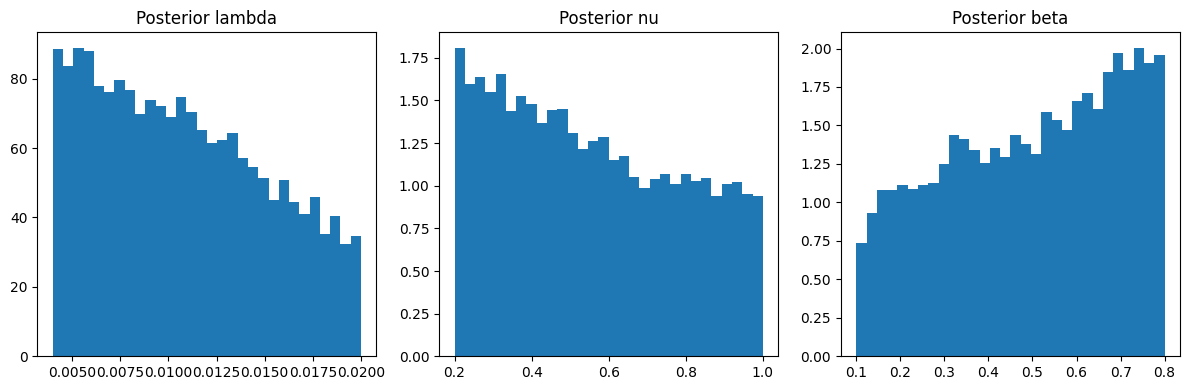

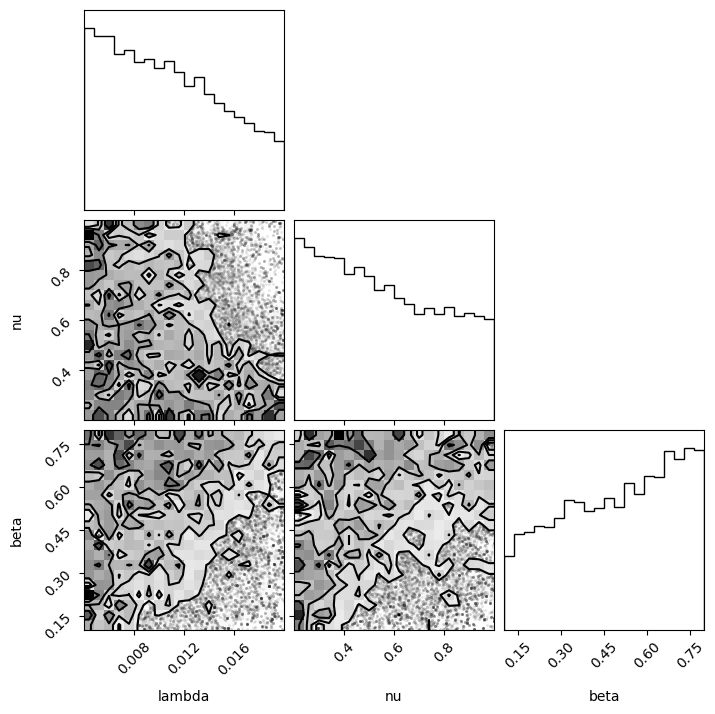

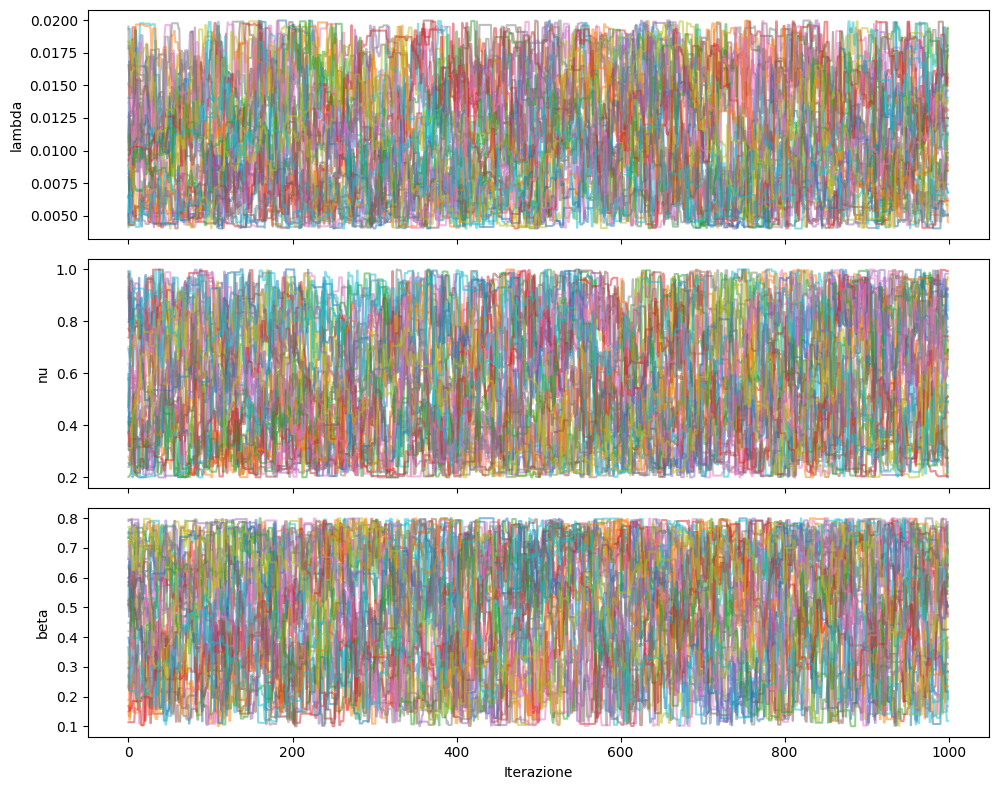

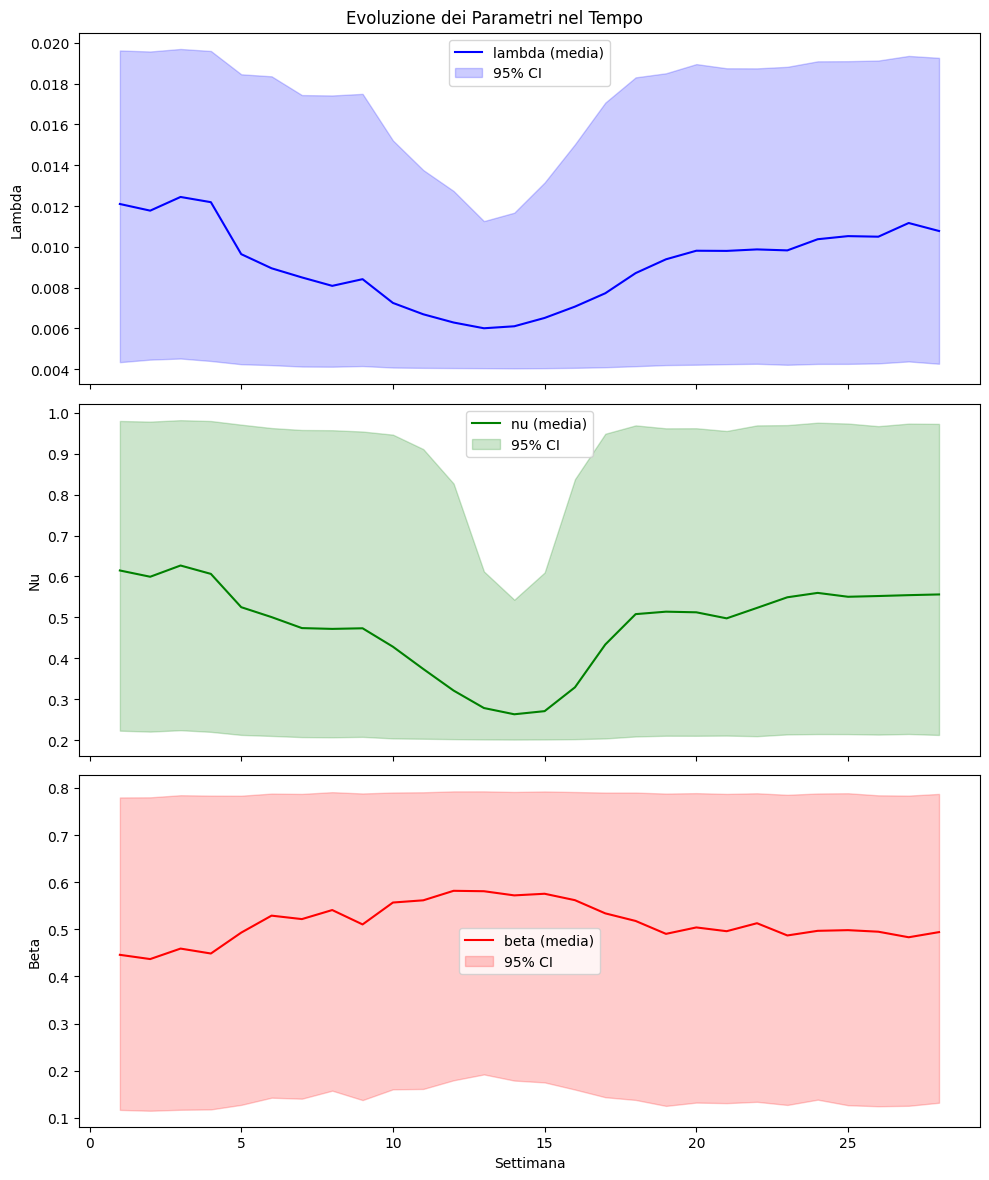

In [47]:
import numpy as np

lam_samples = samples[:, 0]
nu_samples = samples[:, 1]
beta_samples = samples[:, 2]

print("Parametri stimati (settimana X):")
print(f"lambda: mean={lam_samples.mean()}, 95% CI=({np.percentile(lam_samples, 2.5)}, {np.percentile(lam_samples, 97.5)})")
print(f"nu: mean={nu_samples.mean()}, 95% CI=({np.percentile(nu_samples, 2.5)}, {np.percentile(nu_samples, 97.5)})")
print(f"beta: mean={beta_samples.mean()}, 95% CI=({np.percentile(beta_samples, 2.5)}, {np.percentile(beta_samples, 97.5)})")

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist(lam_samples, bins=30, density=True)
axs[0].set_title('Posterior lambda')

axs[1].hist(nu_samples, bins=30, density=True)
axs[1].set_title('Posterior nu')

axs[2].hist(beta_samples, bins=30, density=True)
axs[2].set_title('Posterior beta')

plt.tight_layout()
plt.show()

import corner
fig = corner.corner(samples, labels=["lambda", "nu", "beta"])
plt.show()

import matplotlib.pyplot as plt

# Supponiamo di avere 'sampler' finale
# sampler.get_chain() restituisce un array con shape (iterations, walkers, parameters)
chains = sampler.get_chain()

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
param_names = ["lambda", "nu", "beta"]
for i in range(3):
    for w in range(chains.shape[1]):
        axs[i].plot(chains[:, w, i], alpha=0.5)
    axs[i].set_ylabel(param_names[i])

axs[-1].set_xlabel("Iterazione")
plt.tight_layout()
plt.show()

import arviz as az

data = az.from_emcee(sampler)
az.summary(data)

import matplotlib.pyplot as plt

weeks = np.arange(1, len(lam_means)+1)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Lambda
axs[0].plot(weeks, lam_means, label='lambda (media)', color='b')
axs[0].fill_between(weeks, lam_lower, lam_upper, color='b', alpha=0.2, label='95% CI')
axs[0].set_ylabel("Lambda")
axs[0].legend()

# Nu
axs[1].plot(weeks, nu_means, label='nu (media)', color='g')
axs[1].fill_between(weeks, nu_lower, nu_upper, color='g', alpha=0.2, label='95% CI')
axs[1].set_ylabel("Nu")
axs[1].legend()

# Beta
axs[2].plot(weeks, beta_means, label='beta (media)', color='r')
axs[2].fill_between(weeks, beta_lower, beta_upper, color='r', alpha=0.2, label='95% CI')
axs[2].set_ylabel("Beta")
axs[2].set_xlabel("Settimana")
axs[2].legend()

plt.suptitle("Evoluzione dei Parametri nel Tempo")
plt.tight_layout()
plt.show()


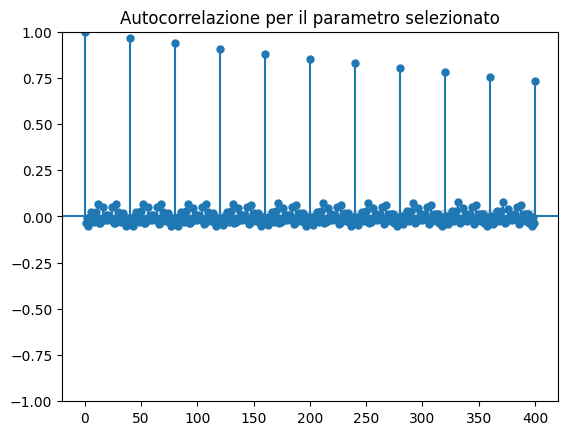

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    var_0    float64 8B 374.2
    var_1    float64 8B 444.0
    var_2    float64 8B 566.6


In [48]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(samples[:, 2], lags=400)  # seleziona [:, 0] per lambda, [:, 1] per nu, [:, 2] per beta
plt.title("Autocorrelazione per il parametro selezionato")
plt.show()

import arviz as az
data = az.from_emcee(sampler)
print(az.ess(data))  # Effective Sample Size, è una misura della non-correlazione dei campioni


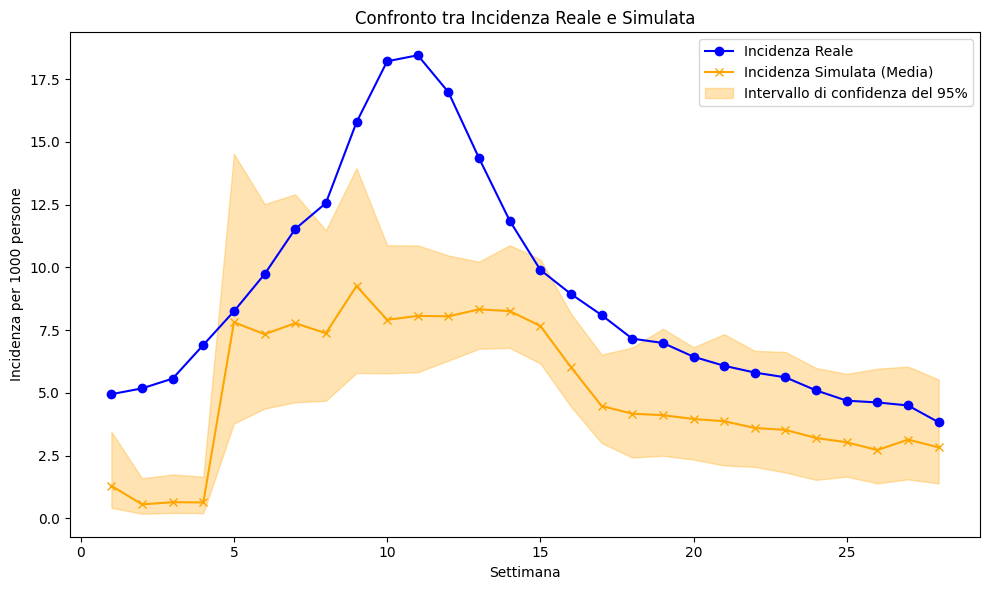

In [49]:
import matplotlib.pyplot as plt

weeks = np.arange(1, len(real_incidence)+1)

plt.figure(figsize=(10, 6))
plt.plot(weeks, real_incidence, label='Incidenza Reale', marker='o', color='blue')
plt.plot(weeks, simulated_means, label='Incidenza Simulata (Media)', marker='x', color='orange')

# intervallo di confidenza per l'incidenza simulata
plt.fill_between(weeks, simulated_lower, simulated_upper, color='orange', alpha=0.3, label='Intervallo di confidenza del 95%')

plt.xlabel("Settimana")
plt.ylabel("Incidenza per 1000 persone")
plt.title("Confronto tra Incidenza Reale e Simulata")
plt.legend()
plt.tight_layout()
plt.show()

